# "Detecting Bundling Opportunities Using Cointegration and Revenue Impact Simulation"
--

Project Objectives
--
#### 1.  Identify Cointegrated Product Category Pairs:
Use Engle-Granger cointegration tests to find product categories that move together in the long run, forming potential bundle candidates.

#### 2. Estimate Long-Run Relationships (OLS):
Fit regression models for each cointegrated pair to compute bundle ratios (slope coefficients) for bundling the pairs when the sales of one category is moving slowly.

#### 3. Detect Bundling Opportunities Based on Z-Score Spreads:
Monitor deviations from long-run trends using z-scores of residual spreads to suggest bundling weeks (signals where one category underperforms).

#### 4. Simulate Revenue Uplift from Bundling Strategy:
Apply a hypothetical uplift (e.g., 5%) to simulate increased revenue and use a paired t-test to check “Is the increase in weekly sales real adn due to bundling, or just random?”.





Loading CSV files to Dataframes
-------------------------------




In [3]:
import pandas as pd

df_order = pd.read_csv("2_orders.csv")
df_order_prior = pd.read_csv("2_order_products__prior.csv")
df_order_train = pd.read_csv("2_order_products__train.csv")
df_product = pd.read_csv("2_products.csv")
df_department = pd.read_csv("2_departments.csv")
df_aisles = pd.read_csv("2_aisles.csv")

Structural details of Dataframes
-----------------------------------------------

In [4]:
print("Shape of df_order:", df_order.shape)
print("number of unique orders/transactions/baskets:", df_order['order_id'].nunique())
print("number of unique users:", df_order['user_id'].nunique())
print("columns in df_order:", df_order.columns, "\n\n")

print("Shape of df_order_prior:", df_order_prior.shape)
print("total numbers of items analysed:", df_order_prior.shape[0])
print("columns in df_order_prior:", df_order_prior.columns, "\n\n")

print("Shape of df_order_train:", df_order_train.shape)
print("columns in df_order_train:", df_order_train.columns, "\n\n")

print("Shape of df_product:", df_product.shape)
print("total unique products:", df_product['product_id'].nunique())
print("columns in df_product:", df_product.columns, "\n\n")

print("Shape of df_department:", df_department.shape)
print("total unique categories:", df_department['department_id'].nunique())
print("columns in df_department:", df_department.columns, "\n\n")

print("Shape of df_aisles:", df_aisles.shape)
print("columns in df_aisles:", df_aisles.columns, "\n\n")

Shape of df_order: (3421083, 7)
number of unique orders/transactions/baskets: 3421083
number of unique users: 206209
columns in df_order: Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object') 


Shape of df_order_prior: (32434489, 4)
total numbers of items analysed: 32434489
columns in df_order_prior: Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object') 


Shape of df_order_train: (1384617, 4)
columns in df_order_train: Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object') 


Shape of df_product: (49688, 4)
total unique products: 49688
columns in df_product: Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object') 


Shape of df_department: (21, 2)
total unique categories: 21
columns in df_department: Index(['department_id', 'department'], dtype='object') 


Shape of df_aisles: (134, 2)
columns in df_aisles:

Consolidating the Dataframes
-------------------------------------------

First‑order rows have NaN in days_since_prior_order
Replaces missing values (NaN) in days_since_prior_order with 0, treating a user’s first order as the start point.
 

In [5]:
df_order["days_since_prior_order"].fillna(0, inplace = True)

C:\Users\NIKESH\AppData\Local\Temp\ipykernel_16804\3211794003.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_order["days_since_prior_order"].fillna(0, inplace = True)


Calculates the running total of days since a user’s first order.
Converts cumulative days into week numbers, starting from Week 1.

In [6]:
import numpy as np

# Running total of days for each user
df_order['cum_days'] = (
    df_order
    .groupby('user_id')['days_since_prior_order']
    .cumsum()
)

# Convert cumulative days to “week number” 
df_order['week_no'] = (df_order['cum_days'] // 7 + 1).astype(int)


Adds department names to product info for labeling.        
Merges prior order lines with product-department data.    
Appends order-level metadata (e.g., week number) to each product line.

In [7]:
#Merge product info to get department/category labels
df_product_merge = df_product.merge(df_department, on='department_id', how='left')

#Merge line items with product info
df_order_prior_merge = df_order_prior.merge(df_product_merge[['product_id', 'department']], on='product_id', how='left')

#Merge with order headers to get order timing
df_order_prior_merge = df_order_prior_merge.merge(df_order[['order_id', 'order_number', 'user_id','week_no']], on='order_id', how='left')

Uses week_no as a time index across users (assumes all users shop on a common timeline).    
Calculates total units sold per department for each week.   
Applies log(1 + x) transformation to stabilize variance and handle zeros — prepares data for time series tests (ADF, cointegration).

In [8]:
#Create a global week index
df_order_prior_merge['global_week'] = df_order_prior_merge['week_no']  

#Aggregate: Weekly total units sold per department
weekly_sales = (
    df_order_prior_merge.groupby(['global_week', 'department'])
         .size()
         .reset_index(name='units_sold')
         .pivot(index='global_week', columns='department', values='units_sold')
         .fillna(0)
)

# log-transform
weekly_sales_log = np.log1p(weekly_sales)  # log(1 + x) to avoid log(0)

Dropping two product categories which are not relevant for analysis.

In [9]:
weekly_sales_log = weekly_sales_log.drop(columns=['missing', 'other'])

Final Dataframe is prepared.     
Each cell = quantity sold of a category in that week

In [10]:
print(weekly_sales_log.shape)
weekly_sales_log.head()

(53, 19)


department    alcohol     babies     bakery  beverages  breakfast      bulk  \
global_week                                                                   
1            9.744550  10.282540  11.459978  12.269446  10.974934  7.742836   
2            8.717027   9.493412  10.563750  11.374169  10.083640  6.886532   
3            8.750683   9.477463  10.556203  11.379280  10.077819  6.965080   
4            8.698181   9.425452  10.509687  11.339631  10.021493  6.877296   
5            9.022926   9.694493  10.853735  11.669374  10.362620  7.239215   

department   canned goods  dairy eggs       deli  dry goods pasta     frozen  \
global_week                                                                    
1               11.424804   12.939807  11.373778        11.226776  12.188692   
2               10.460958   12.059560  10.462217        10.274154  11.247540   
3               10.461302   12.054441  10.460013        10.274672  11.238225   
4               10.391577   12.008579  10.405383        10.219684  11.189644   
5               10.772100   12.341246  10.761004        10.605099  11.570553   

department   household  international  meat seafood     pantry  personal care  \
global_week                                                                     
1            11.081265      10.085309     10.989909  12.004892      10.586155   
2            10.063308       9.159152     10.090175  11.063838       9.583282   
3            10.081717       9.118335     10.072217  11.035776       9.593083   
4            10.044249       9.054972     10.028224  11.000081       9.557046   
5            10.480129       9.420844     10.388226  11.373962       9.943045   

department       pets    produce     snacks  
global_week                                  
1            9.017605  13.511340  12.337320  
2            8.092239  12.635690  11.458078  
3            8.068090  12.623058  11.458913  
4            8.013674  12.570685  11.410439  
5            8.411166  12.903720  11.740802

Correlation Matrix
------------------

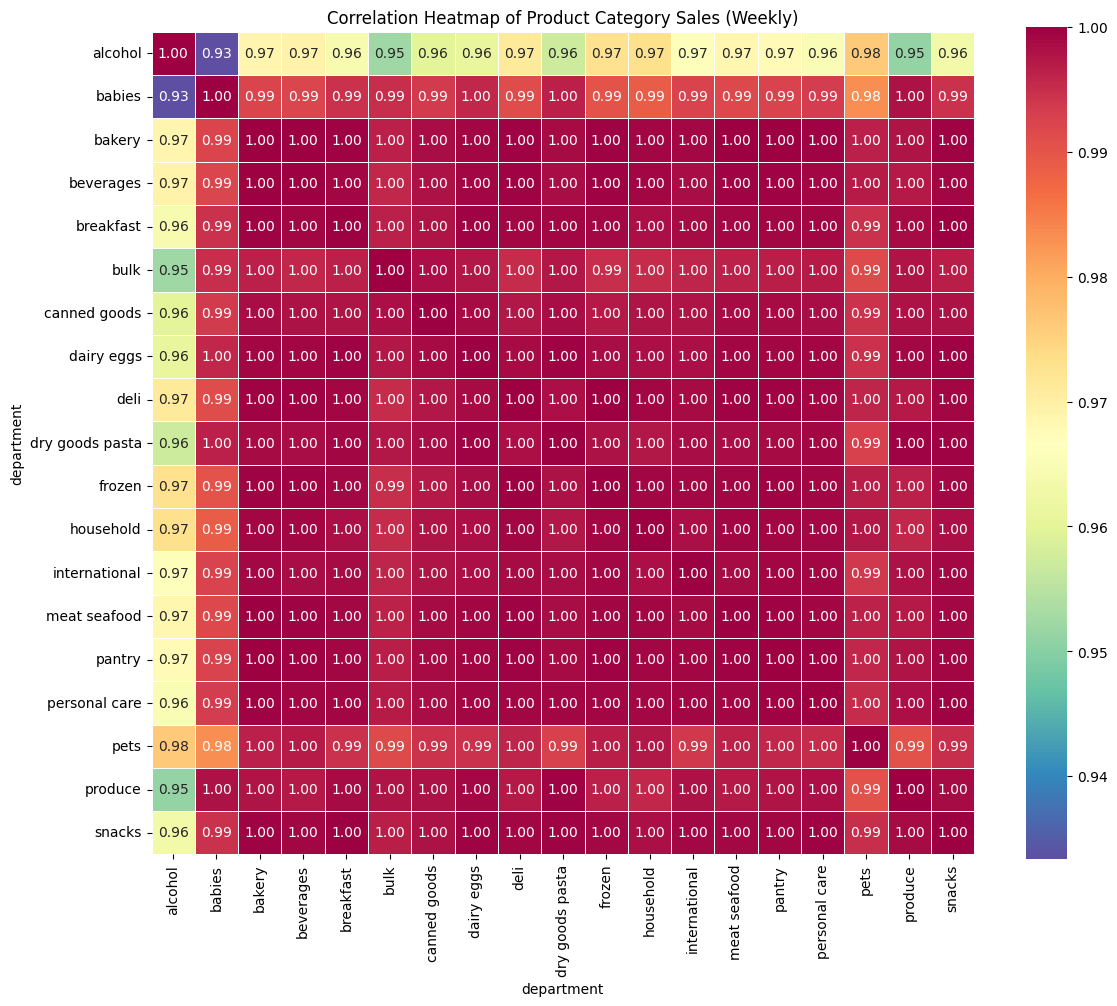

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

#Calculate correlation matrix
corr_matrix = weekly_sales_log.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Spectral_r', square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Product Category Sales (Weekly)")
plt.tight_layout()
plt.show()

Objective 1: Establish Long-Run Sales Relationships Among Product Categories
----------------------------------------------------------------------------
Stationarity and Cointegration Test


ADF Test (H₀: Series is non-stationary).  
KPSS Test (H₀: Series is stationary).  
Results are stored in adf_df and kpss_df for comparison.

Uses statsmodels.tsa.stattools.coint()       
Null hypothesis (H₀): No cointegration.

Saves result in coint_df with test stat and p-value.

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss, coint
from itertools import combinations
from tqdm.auto import tqdm

In [13]:
import warnings
warnings.filterwarnings("ignore")

ts_df = weekly_sales_log.copy()   # or = weekly_sales

# Unit‑root tests on each series
adf_results   = []
kpss_results  = []

for col in ts_df.columns:
    series = ts_df[col].dropna()

    # Augmented Dickey‑Fuller (H0: non‑stationary)
    adf_stat, adf_p, *_ = adfuller(series, autolag='AIC')
    adf_results.append({'department': col,
                        'adf_stat': adf_stat,
                        'adf_pvalue': adf_p})

    # KPSS (H0: stationary)
    kpss_stat, kpss_p, *_ = kpss(series, regression='c')
    kpss_results.append({'department': col,
                         'kpss_stat': kpss_stat,
                         'kpss_pvalue': kpss_p})

adf_df  = pd.DataFrame(adf_results)
kpss_df = pd.DataFrame(kpss_results)

print(adf_df)
print(kpss_df)

# Engle‑Granger cointegration test on pairs
# (H0: not cointegrated)

# Compute total quantity sold for each department
dept_totals = ts_df.sum(axis=0) 

pairs   = combinations(ts_df.columns, 2)
coint_results = []

for x, y in tqdm(pairs, total=len(ts_df.columns)*(len(ts_df.columns)-1)//2):

    if dept_totals[x] >= dept_totals[y]:
        dept_x, dept_y = x, y
    else:
        dept_x, dept_y = y, x 

    score, pvalue, _ = coint(ts_df[dept_x].dropna(), ts_df[dept_y].dropna())
    coint_results.append({'dept_x': dept_x,
                          'dept_y': dept_y,
                          'coint_stat': score,
                          'pvalue': pvalue})

coint_df = pd.DataFrame(coint_results)


# Filter for significant pairs
sig_pairs = (coint_df
             .query('pvalue < 0.05')
             .sort_values('pvalue')
             .reset_index(drop=True))

print(f"Found {len(sig_pairs)} cointegrated pairs at 5% level")

         department  adf_stat  adf_pvalue
0           alcohol -0.927406    0.778813
1            babies  3.934078    1.000000
2            bakery -1.627069    0.469025
3         beverages -2.135361    0.230536
4         breakfast -1.252439    0.650641
5              bulk  0.086480    0.965126
6      canned goods  1.909734    0.998544
7        dairy eggs -2.067002    0.257988
8              deli -1.534939    0.516162
9   dry goods pasta -1.564626    0.501334
10           frozen -1.404248    0.580238
11        household -1.530739    0.518254
12    international -0.500675    0.891885
13     meat seafood -1.028283    0.742810
14           pantry -1.622100    0.471628
15    personal care -1.210214    0.669186
16             pets -1.161104    0.690100
17          produce -1.294071    0.631880
18           snacks -1.438169    0.563847
         department  kpss_stat  kpss_pvalue
0           alcohol   1.146608         0.01
1            babies   1.126936         0.01
2            bakery   1.0454

  0%|          | 0/171 [00:00<?, ?it/s]

Found 23 cointegrated pairs at 5% level


In [14]:
print("Below is the list of significant cointegrated pairs")
display(sig_pairs)

Below is the list of significant cointegrated pairs


dept_x           dept_y  coint_stat    pvalue
0   dry goods pasta    personal care   -5.968686  0.000002
1            frozen             deli   -5.821453  0.000004
2            bakery     meat seafood   -5.212395  0.000066
3            pantry     meat seafood   -5.146852  0.000088
4            snacks    personal care   -5.060142  0.000127
5              deli        household   -5.024750  0.000148
6         breakfast    personal care   -4.941246  0.000211
7            snacks        breakfast   -4.678337  0.000614
8     personal care    international   -4.563608  0.000961
9         beverages             deli   -4.339504  0.002220
10       dairy eggs    personal care   -4.223165  0.003364
11           pantry           bakery   -4.220985  0.003390
12        breakfast    international   -4.191870  0.003753
13           bakery        breakfast   -3.959793  0.008188
14           snacks     meat seafood   -3.840702  0.011953
15     meat seafood    international   -3.814724  0.012955
16           snacks    international   -3.786408  0.014132
17           babies             bulk   -3.589147  0.025269
18           snacks        household   -3.547315  0.028425
19           bakery    international   -3.422342  0.039929
20           snacks  dry goods pasta   -3.362134  0.046734
21           pantry        breakfast   -3.349456  0.048283
22          produce     meat seafood   -3.338049  0.049712

Objective 2: Estimate Bundle Ratio
--
Performing OLS linear regression of y_cat on x_cat using log-transformed weekly sales between all 23 pairs.

The beta coefficient (beta_bundle_ratio) tells us how much one category’s sales (log scale) move in relation to the other.

This ratio can be interpreted as an optimal quantity of one product category to be bundled with another.

In [15]:
import statsmodels.api as sm
import pandas as pd

bundle_ratios = []

print("----- Bundle Ratio Estimation via OLS (Full Summary Shown) -----")
print(f"Total cointegrated pairs to analyze: {len(sig_pairs)}")
print("-" * 70)

for idx, row in sig_pairs.iterrows():
    x_cat = row['dept_x']
    y_cat = row['dept_y']

    X = weekly_sales_log[x_cat]
    y = weekly_sales_log[y_cat]

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    print(f"\n=== Pair {idx+1}: {y_cat} ~ {x_cat} ===")
    print(model.summary())

    bundle_ratios.append({
        'dependent': y_cat,
        'independent': x_cat,
        'beta_bundle_ratio': model.params[x_cat],
        'intercept': model.params['const'],
        'r_squared': model.rsquared
    })

bundle_ratios_df = pd.DataFrame(bundle_ratios)

print("\n--- Bundle Ratio Summary Table ---")
print(bundle_ratios_df)


----- Bundle Ratio Estimation via OLS (Full Summary Shown) -----
Total cointegrated pairs to analyze: 23
----------------------------------------------------------------------

=== Pair 1: personal care ~ dry goods pasta ===
                            OLS Regression Results                            
Dep. Variable:          personal care   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.624e+04
Date:                Wed, 30 Jul 2025   Prob (F-statistic):           2.07e-74
Time:                        18:33:52   Log-Likelihood:                 98.033
No. Observations:                  53   AIC:                            -192.1
Df Residuals:                      51   BIC:                            -188.1
Df Model:                           1                                         
Covariance Type:            nonrobust                           

Objective 3: Detect Bundling Opportunities Based on Z-Score Spreads
----------------
Calculates lagged equilibrium deviation: how much y deviated from long-run path in previous period.     
Compute Δy and Δx, i.e., weekly changes in log-sales.

Regress change in y on:
ECT_lag (adjustment toward long-run equilibrium)
Δx (short-run shock)

Alpha (α): Strength and direction of error correction (how y corrects past imbalance).
Gamma (γ): Short-term impact of changes in x on changes in y.

ECM Interpretation Notes:
If α is negative and significant, the system adjusts back toward equilibrium.
Significant γ means short-term co-movement also exists, not just long-run.


In [16]:
import statsmodels.api as sm
import pandas as pd

ecm_results = []

print("----- Error Correction Model (ECM) Estimation -----")
print(f"Total cointegrated pairs to analyze: {len(sig_pairs)}")
print("-" * 70)

for idx, row in sig_pairs.iterrows():
    x_cat = row['dept_x']
    y_cat = row['dept_y']

    y = weekly_sales_log[y_cat]
    x = weekly_sales_log[x_cat]

    # 1. Getting beta from long-run OLS
    X_lr = sm.add_constant(x)
    lr_model = sm.OLS(y, X_lr).fit()
    beta = lr_model.params[x_cat]

    # 2. Computing lagged equilibrium error (ECT = y_t-1 - beta * x_t-1)
    ECT = y.shift(1) - beta * x.shift(1)

    # 3. Computing Δy and Δx
    dy = y.diff()
    dx = x.diff()

    # 4. ECM regression: Δy ~ ECT_lag + Δx
    df_ecm = pd.DataFrame({
        'dy': dy,
        'ECT_lag': ECT,
        'dx': dx
    }).dropna()

    X_ecm = sm.add_constant(df_ecm[['ECT_lag', 'dx']])
    model = sm.OLS(df_ecm['dy'], X_ecm).fit()

    print(f"\n=== Pair {idx+1}: Δ{y_cat} ~ ECT + Δ{x_cat} ===")
    print(model.summary())

    ecm_results.append({
        'dependent': y_cat,
        'independent': x_cat,
        'alpha': model.params['ECT_lag'],
        'alpha_pval': model.pvalues['ECT_lag'],
        'gamma': model.params['dx'],
        'gamma_pval': model.pvalues['dx'],
        'r_squared': model.rsquared
    })

# Creating summary DataFrame
ecm_df = pd.DataFrame(ecm_results)

print("\n--- ECM Summary Table ---")
display(ecm_df)


----- Error Correction Model (ECM) Estimation -----
Total cointegrated pairs to analyze: 23
----------------------------------------------------------------------

=== Pair 1: Δpersonal care ~ ECT + Δdry goods pasta ===
                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     6934.
Date:                Wed, 30 Jul 2025   Prob (F-statistic):           7.81e-61
Time:                        18:33:52   Log-Likelihood:                 108.06
No. Observations:                  52   AIC:                            -210.1
Df Residuals:                      49   BIC:                            -204.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                

dependent      independent     alpha  alpha_pval     gamma  \
0     personal care  dry goods pasta -0.689366    0.000015  0.916676   
1              deli           frozen -0.660038    0.000187  0.963572   
2      meat seafood           bakery -0.588376    0.000010  1.070646   
3      meat seafood           pantry -0.516850    0.000020  1.029419   
4     personal care           snacks -0.642292    0.000010  1.035154   
5         household             deli -0.532879    0.001612  1.011697   
6     personal care        breakfast -0.569282    0.000098  0.993208   
7         breakfast           snacks -0.575622    0.000213  1.040775   
8     international    personal care -0.571350    0.000023  0.951002   
9              deli        beverages -0.552053    0.000067  0.999218   
10    personal care       dairy eggs -0.508374    0.000066  1.025068   
11           bakery           pantry -0.483442    0.000190  0.961355   
12    international        breakfast -0.403316    0.000381  0.944235   
13        breakfast           bakery -0.177048    0.193603  1.081712   
14     meat seafood           snacks -0.093923    0.229576  1.031658   
15    international     meat seafood -0.326161    0.000659  0.950319   
16    international           snacks -0.399400    0.000196  0.985843   
17             bulk           babies -0.544799    0.000296  0.789109   
18        household           snacks -0.270702    0.039417  0.978219   
19    international           bakery -0.330005    0.001717  1.016142   
20  dry goods pasta           snacks -0.258589    0.019606  1.136592   
21        breakfast           pantry -0.335449    0.007736  1.034727   
22     meat seafood          produce  0.068515    0.161578  0.977498   

      gamma_pval  r_squared  
0   1.283443e-60   0.996479  
1   2.261907e-73   0.999110  
2   1.515989e-73   0.998856  
3   6.088486e-69   0.998266  
4   6.761094e-65   0.997385  
5   2.130911e-53   0.994036  
6   2.088938e-60   0.996299  
7   1.592519e-72   0.998960  
8   1.829502e-59   0.995644  
9   1.027896e-68   0.998372  
10  2.491751e-63   0.996960  
11  2.851814e-71   0.998572  
12  4.601709e-59   0.995597  
13  2.408886e-65   0.998167  
14  6.941384e-69   0.998305  
15  2.359765e-60   0.996117  
16  3.740993e-61   0.996266  
17  1.198768e-39   0.973663  
18  2.387688e-52   0.992440  
19  6.022467e-60   0.995904  
20  1.150437e-69   0.998473  
21  5.626666e-63   0.997248  
22  1.152456e-68   0.998373

### Bundling Signal Detection
---------------------------------------
Regress dependent category on the independent to get predicted relationship (spread).\
Residuals (spread) show deviation from the long-run trend.\
Z-scores help identify unusually negative deviations.\
Weeks where the dependent category underperforms the expected relationship (z < -1.5) are potential bundling signals.\
Save all significant weeks along with their z-scores.\
Print bundling recommendations per pair.

Interpretation:\
Z < -1.5 indicates the dependent product is underperforming relative to its usual link with the independent product.\
This may be a good week to bundle them — i.e., promote the lagging one alongside the stronger performer.




In [17]:
import statsmodels.api as sm
from scipy.stats import zscore

# Creating dictionary to hold bundling suggestions
bundling_signals = {}

print("----- Bundling Signal Detection -----\n")

for idx, row in sig_pairs.iterrows():
    indep = row['dept_x']
    dep = row['dept_y']
    
    # Regressing dep ~ indep to get long-run relationship
    X = sm.add_constant(weekly_sales_log[indep])
    y = weekly_sales_log[dep]
    model = sm.OLS(y, X).fit()
    
    # Residuals = actual - predicted (spread)
    spread = model.resid
    z_scores = zscore(spread)
    
    # Identifing bundling signals where z < -2
    signal_weeks = weekly_sales_log.index[z_scores < -1.5].tolist()
    signal_zs = z_scores[z_scores < -1.5]
    
    if len(signal_weeks) > 0:
        bundling_signals[f"{dep} ~ {indep}"] = list(zip(signal_weeks, signal_zs))

        print(f"Pair {dep} ~ {indep}:")
        for week, z in zip(signal_weeks, signal_zs):
            print(f"  ⚠️ Week {week}: z = {z:.2f} → Suggest bundling '{dep}' with '{indep}'")
        print()
    else:
        print(f"Pair {dep} ~ {indep}: No bundling suggestions (z-score never < -1.5)\n")

all_signals_df = pd.DataFrame([
    {"pair": pair, "week": week, "z_score": z}
    for pair, signals in bundling_signals.items()
    for week, z in signals
])


----- Bundling Signal Detection -----

Pair personal care ~ dry goods pasta:
  ⚠️ Week 35: z = -1.79 → Suggest bundling 'personal care' with 'dry goods pasta'
  ⚠️ Week 51: z = -1.63 → Suggest bundling 'personal care' with 'dry goods pasta'
  ⚠️ Week 52: z = -2.66 → Suggest bundling 'personal care' with 'dry goods pasta'

Pair deli ~ frozen:
  ⚠️ Week 46: z = -1.66 → Suggest bundling 'deli' with 'frozen'
  ⚠️ Week 53: z = -2.79 → Suggest bundling 'deli' with 'frozen'

Pair meat seafood ~ bakery:
  ⚠️ Week 1: z = -2.85 → Suggest bundling 'meat seafood' with 'bakery'
  ⚠️ Week 47: z = -1.91 → Suggest bundling 'meat seafood' with 'bakery'
  ⚠️ Week 48: z = -2.55 → Suggest bundling 'meat seafood' with 'bakery'
  ⚠️ Week 51: z = -2.34 → Suggest bundling 'meat seafood' with 'bakery'

Pair meat seafood ~ pantry:
  ⚠️ Week 1: z = -3.37 → Suggest bundling 'meat seafood' with 'pantry'
  ⚠️ Week 5: z = -1.51 → Suggest bundling 'meat seafood' with 'pantry'
  ⚠️ Week 51: z = -1.62 → Suggest bundlin

Plotting

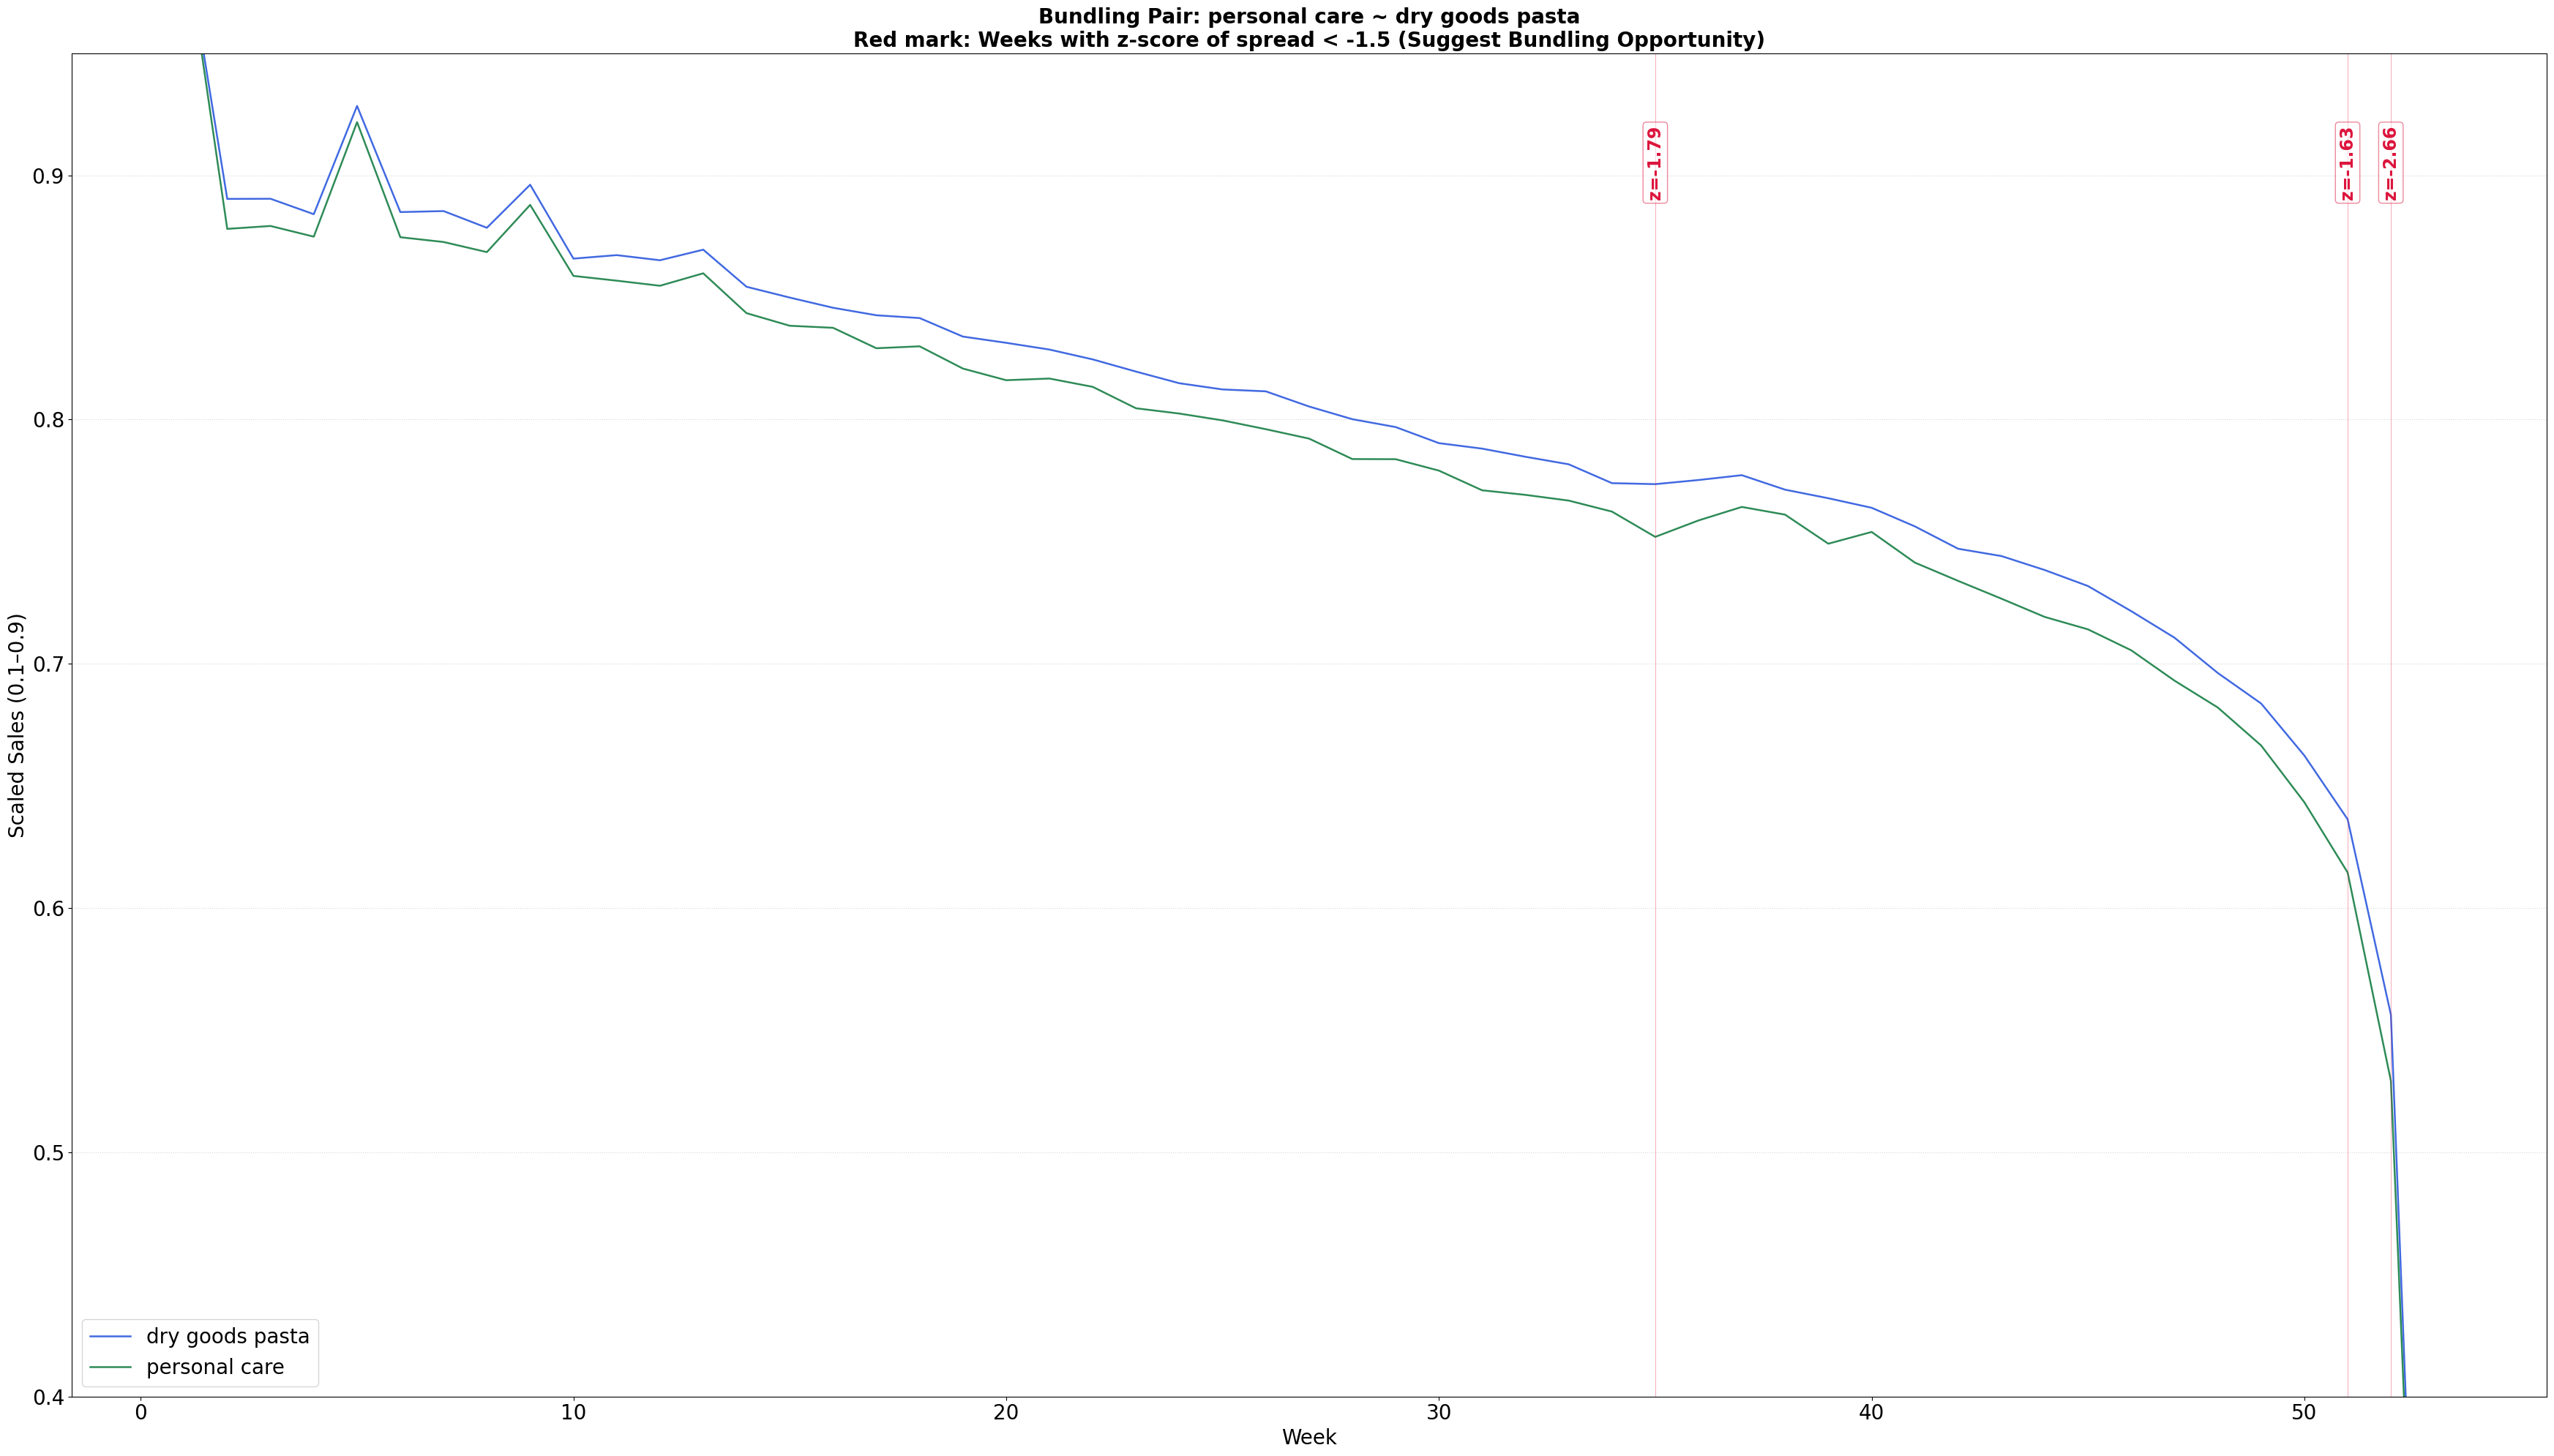

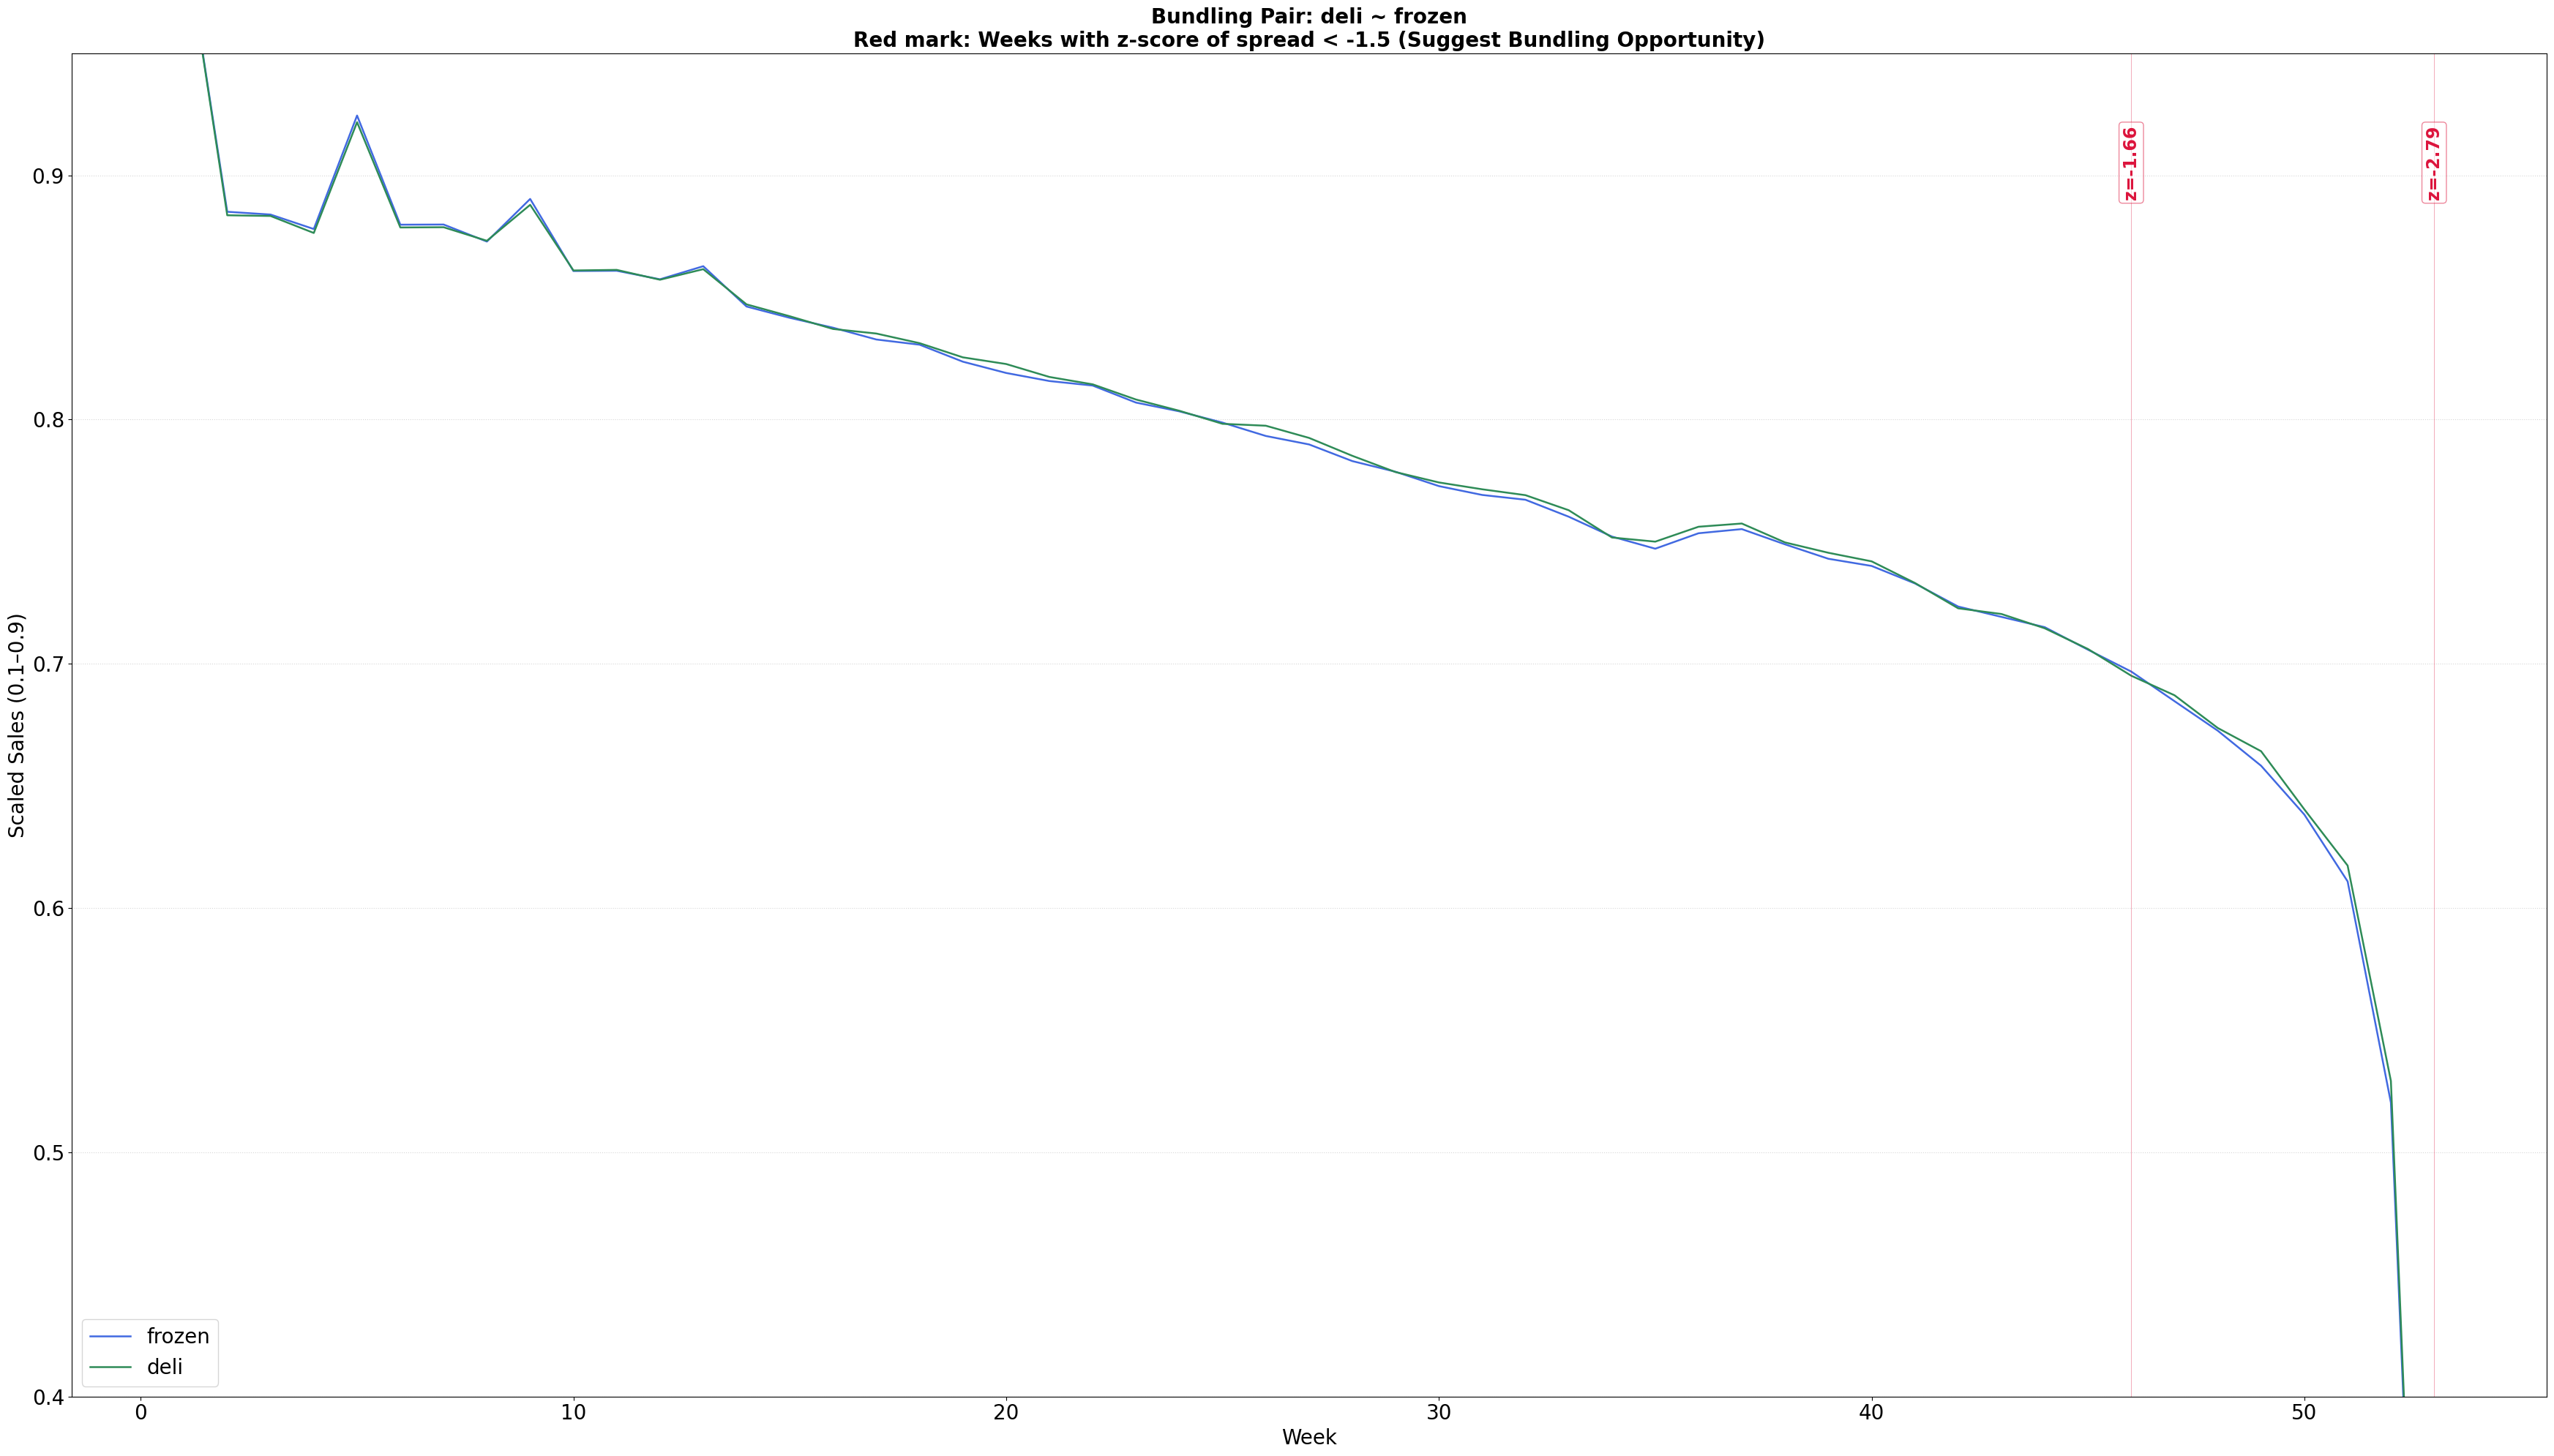

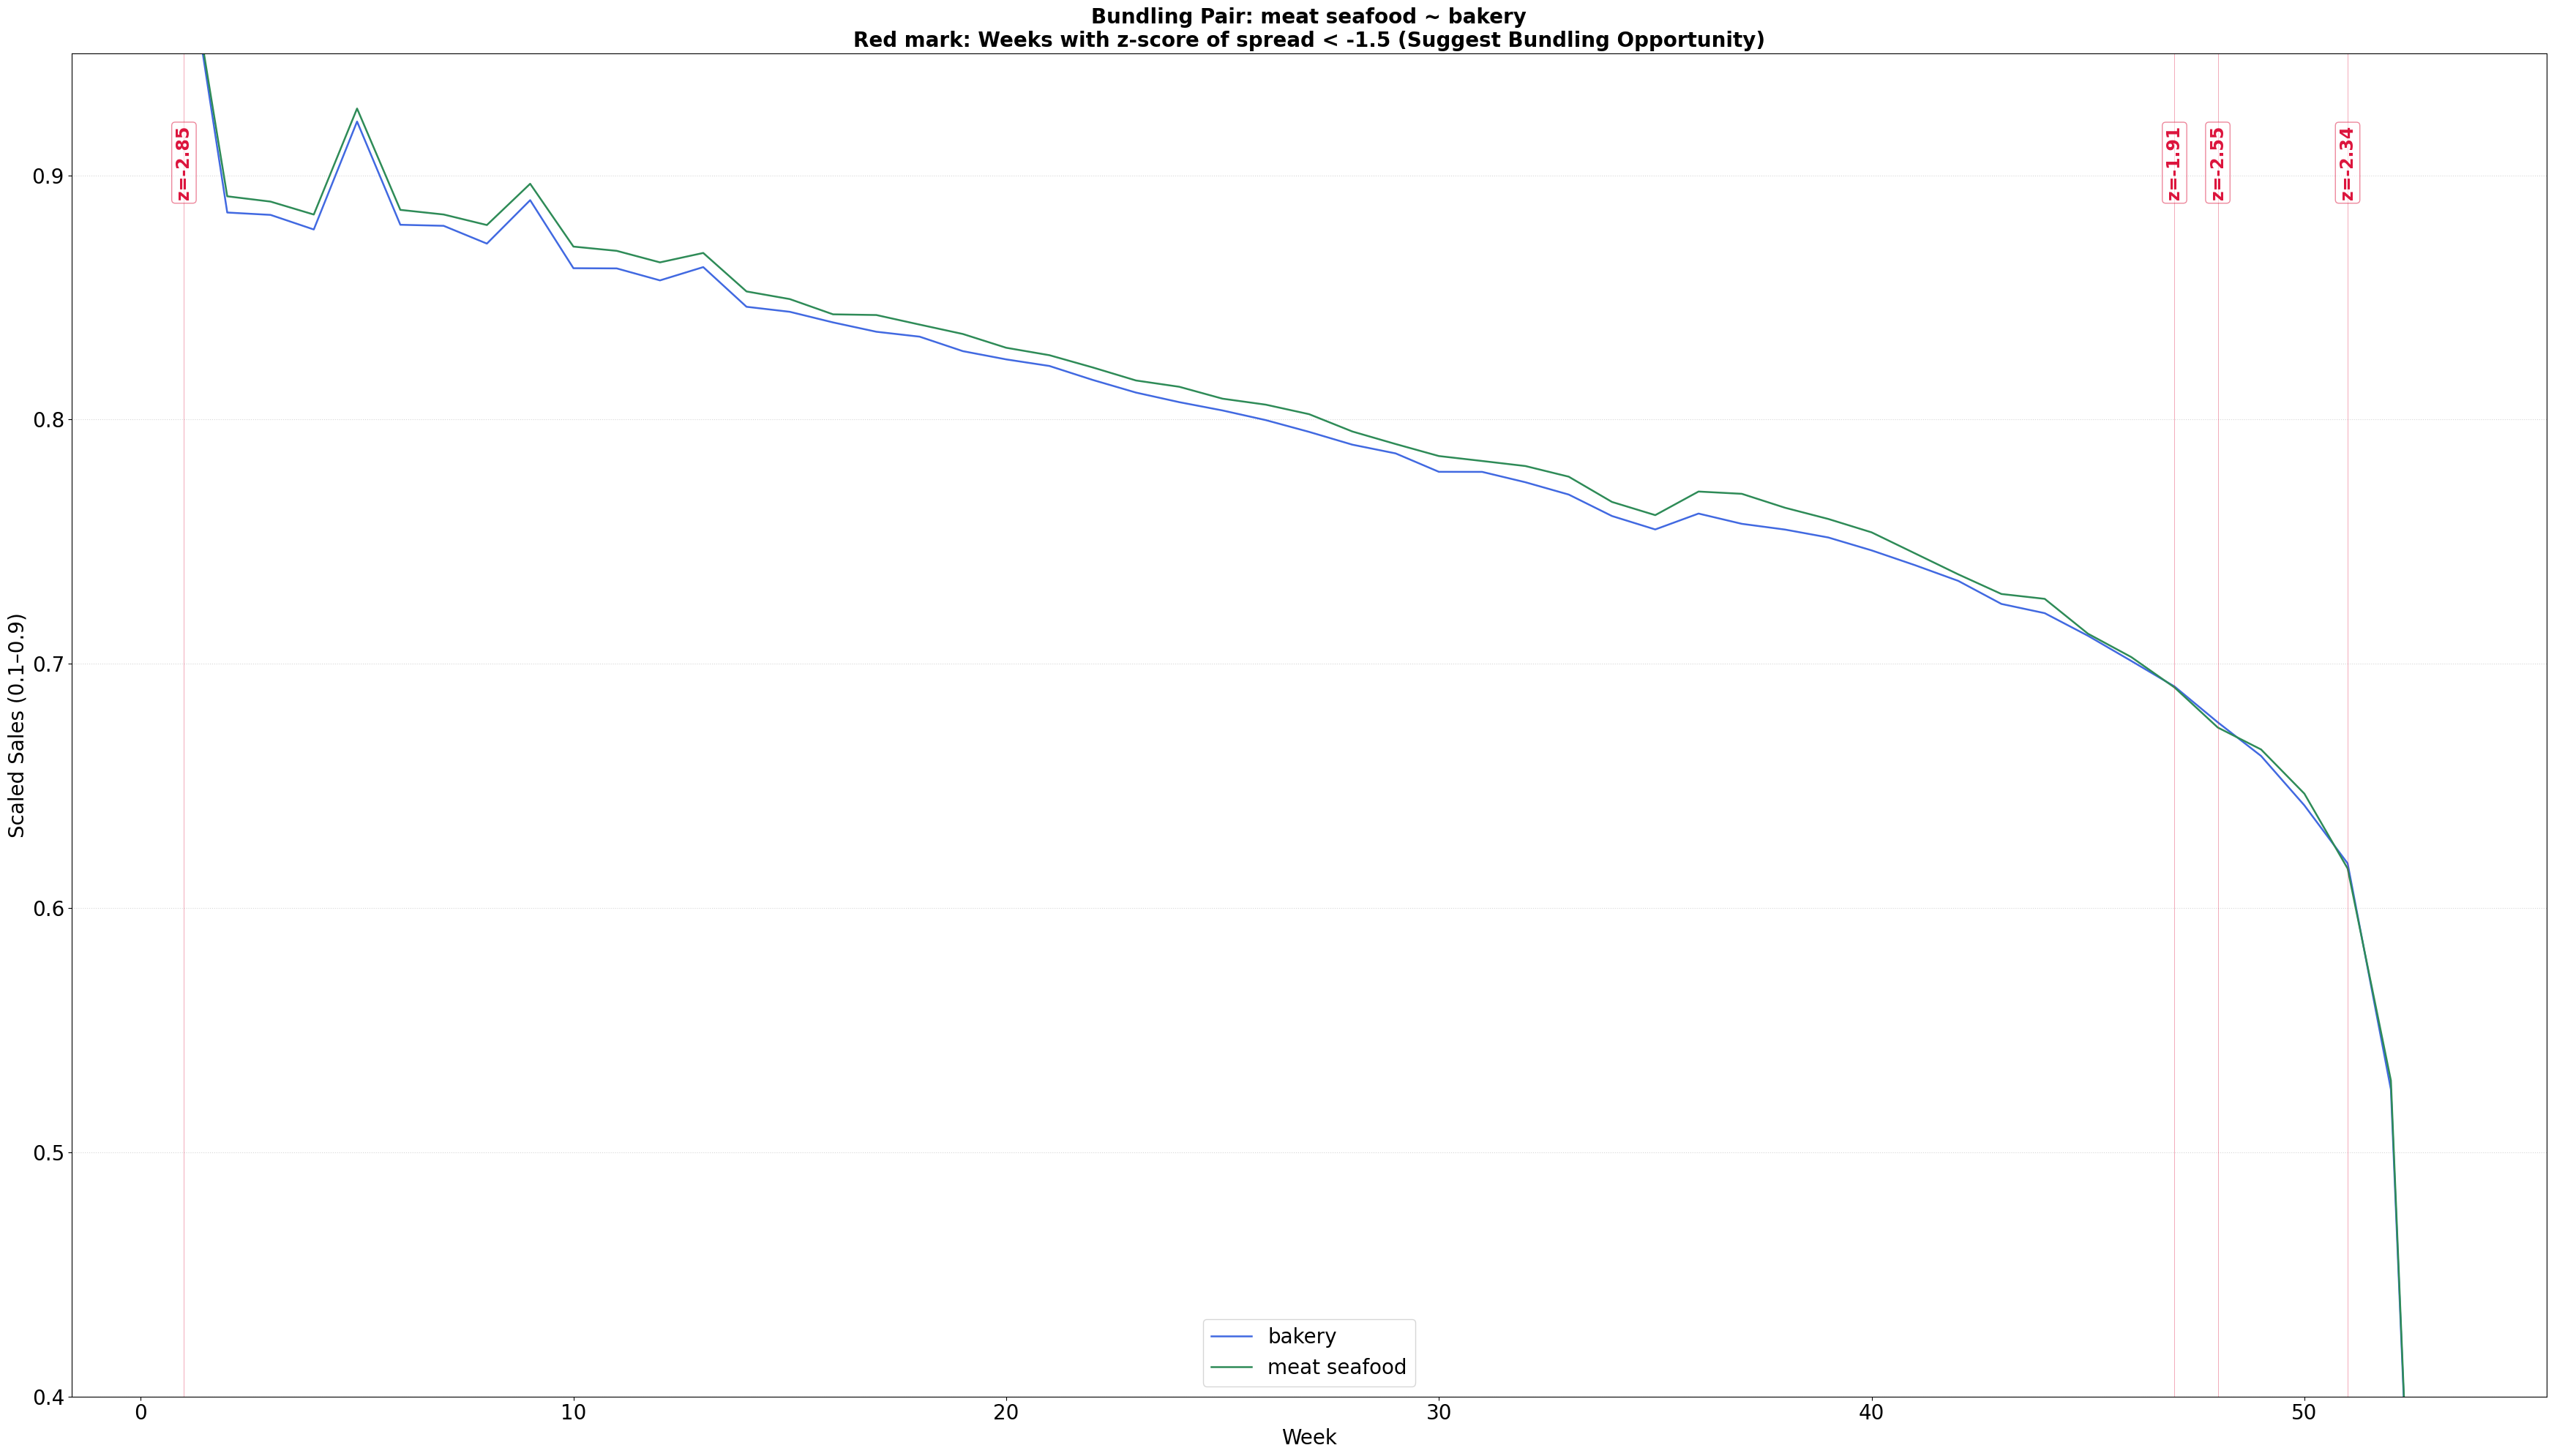

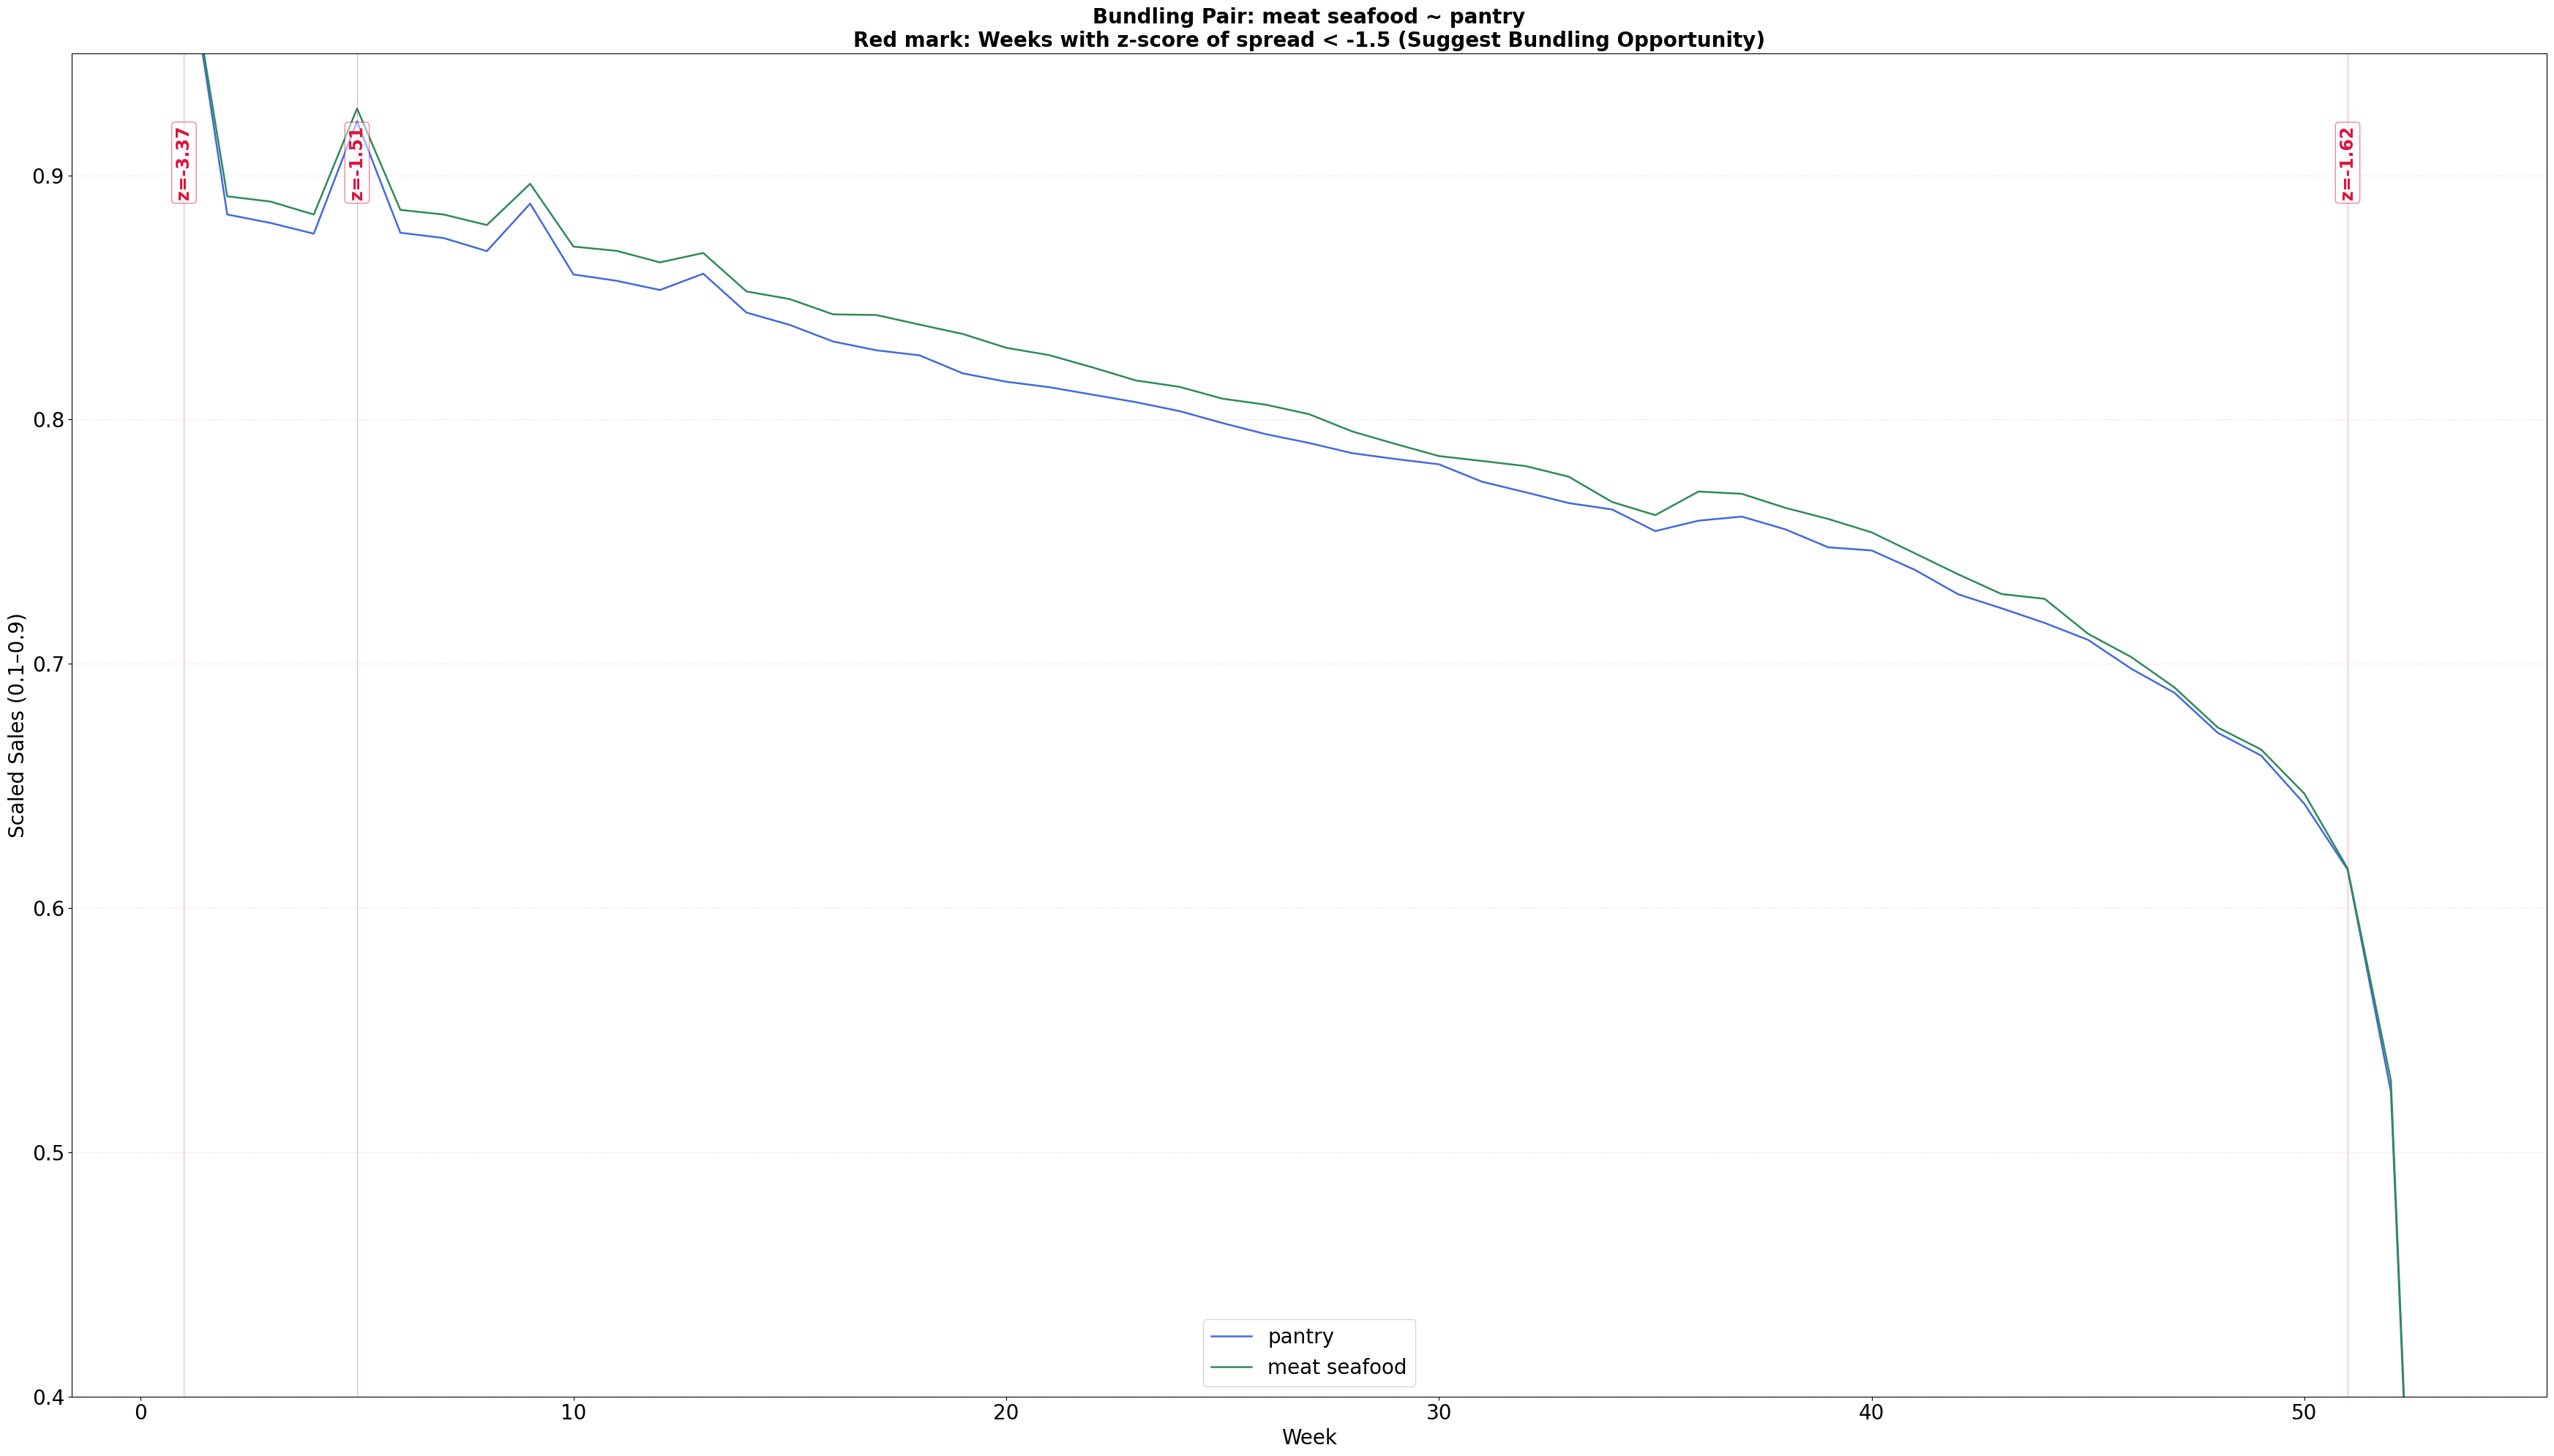

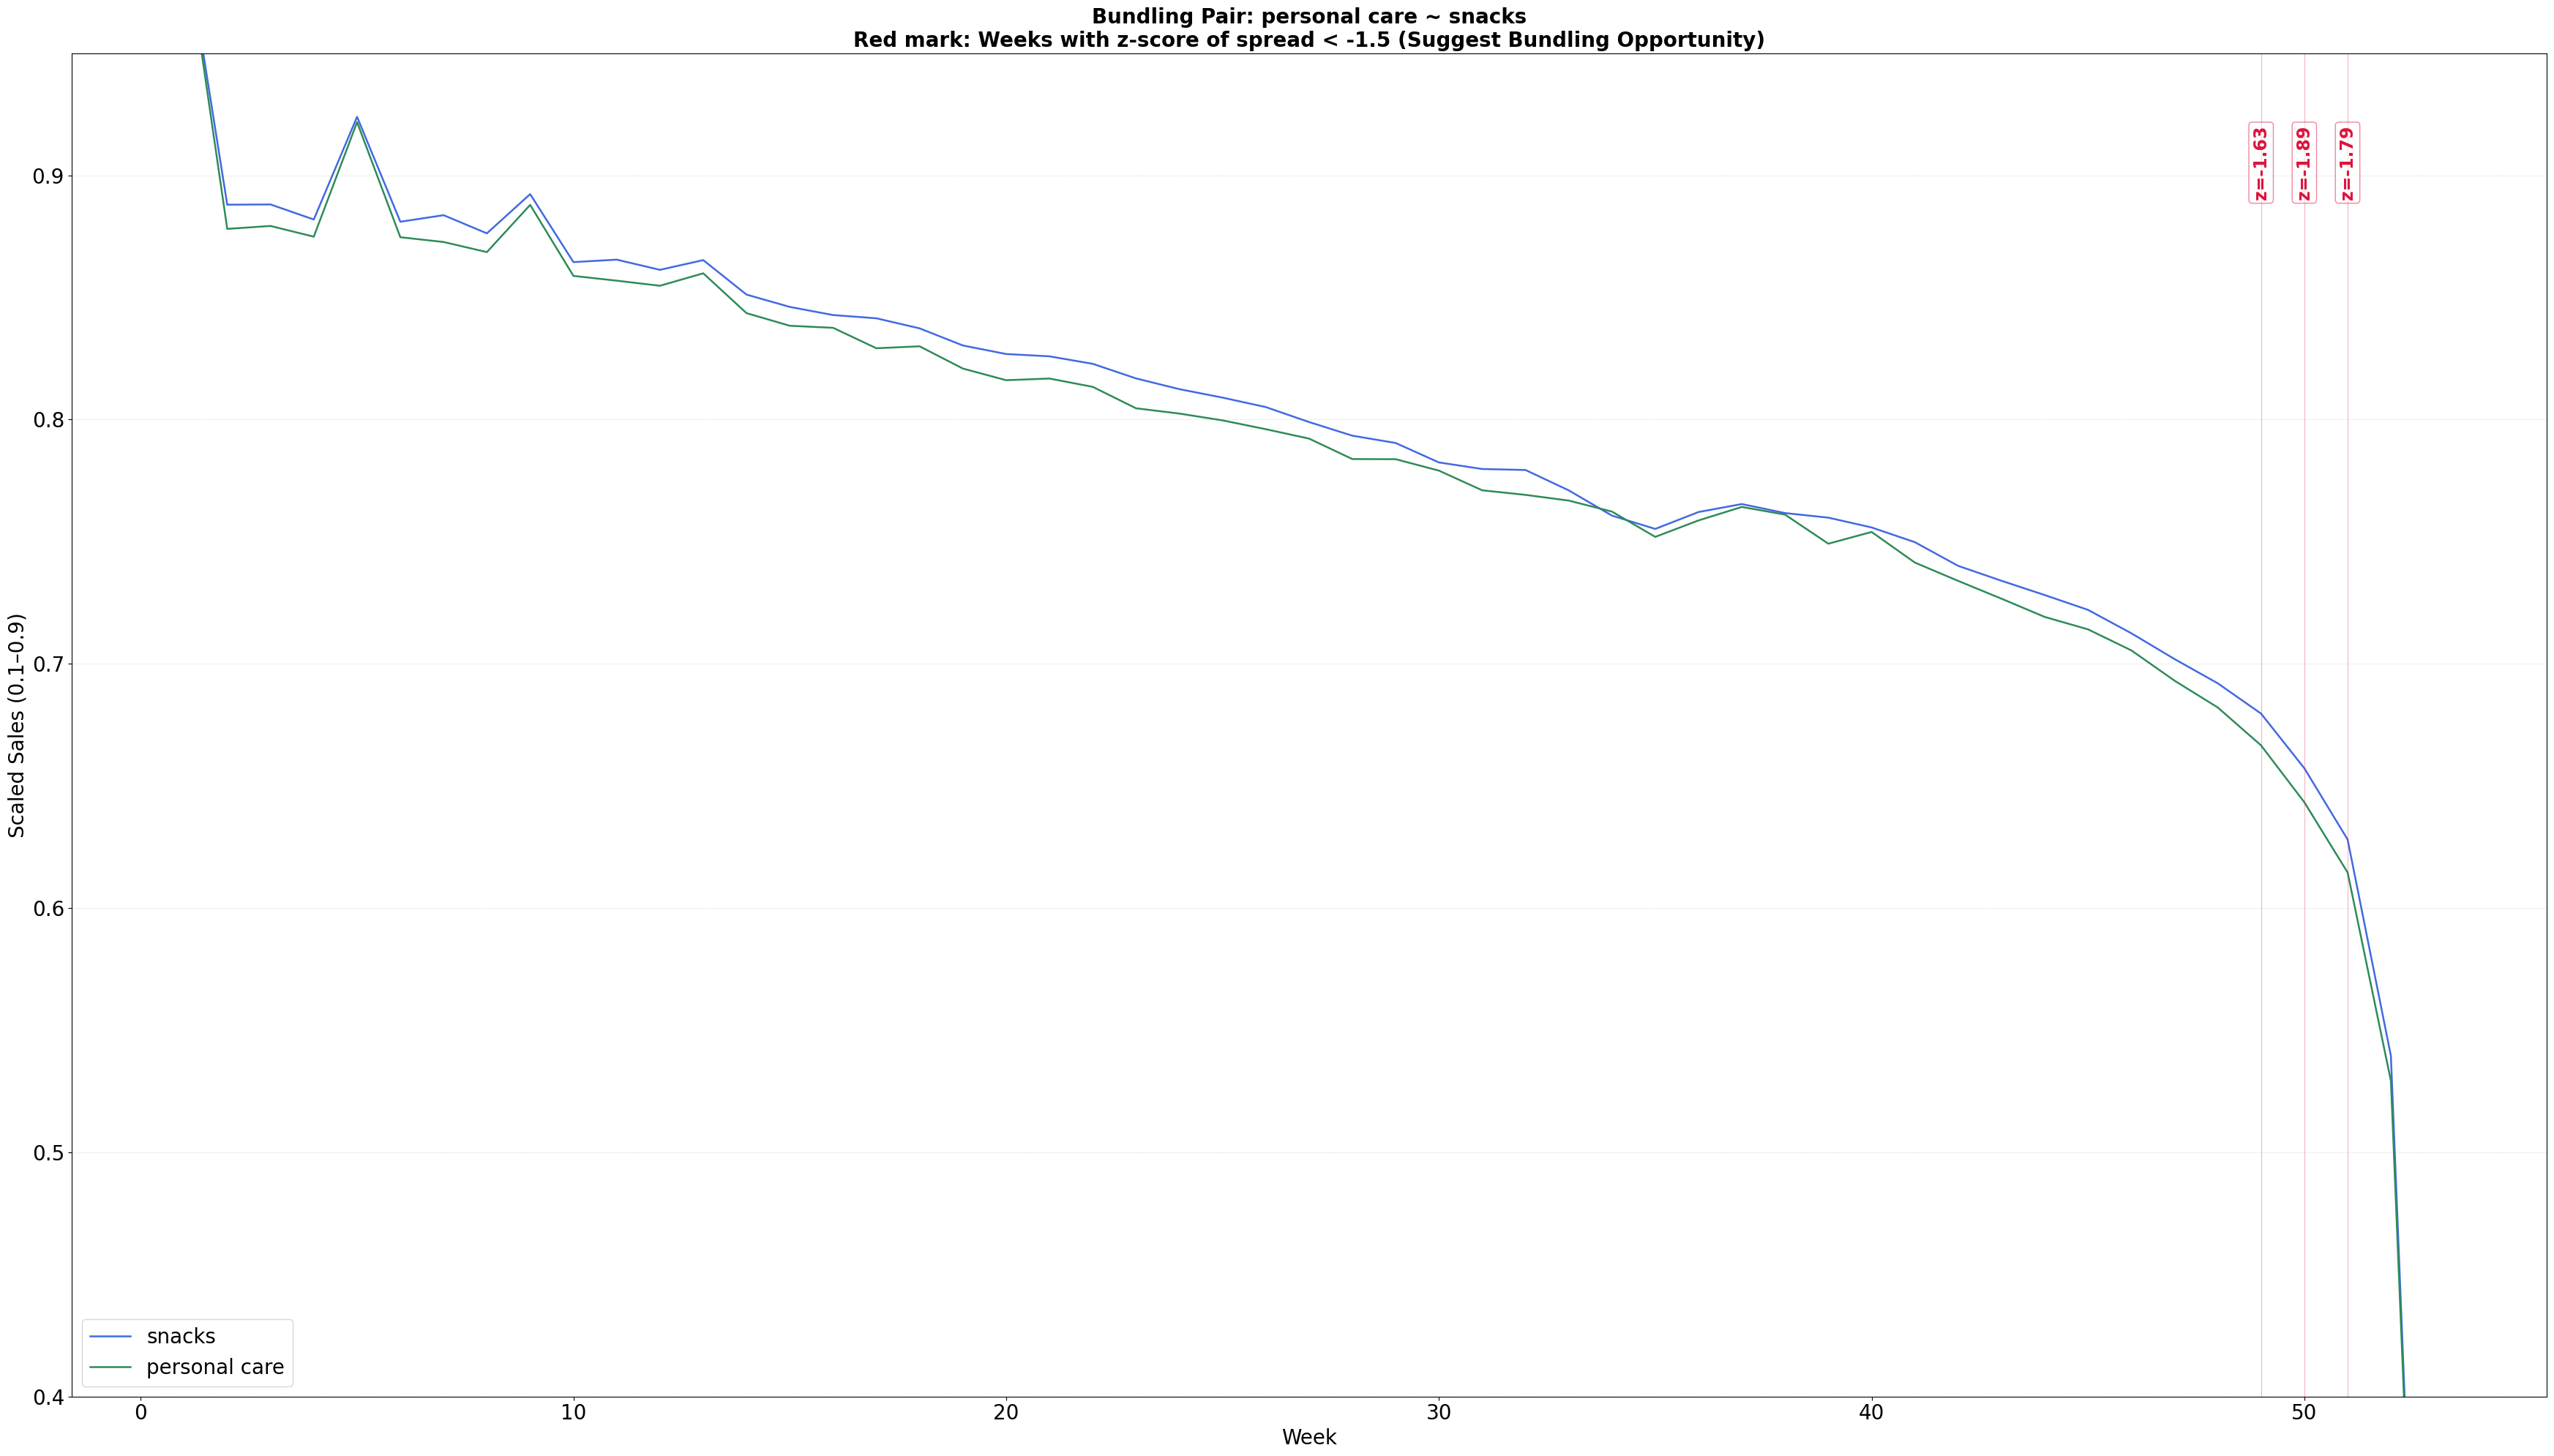

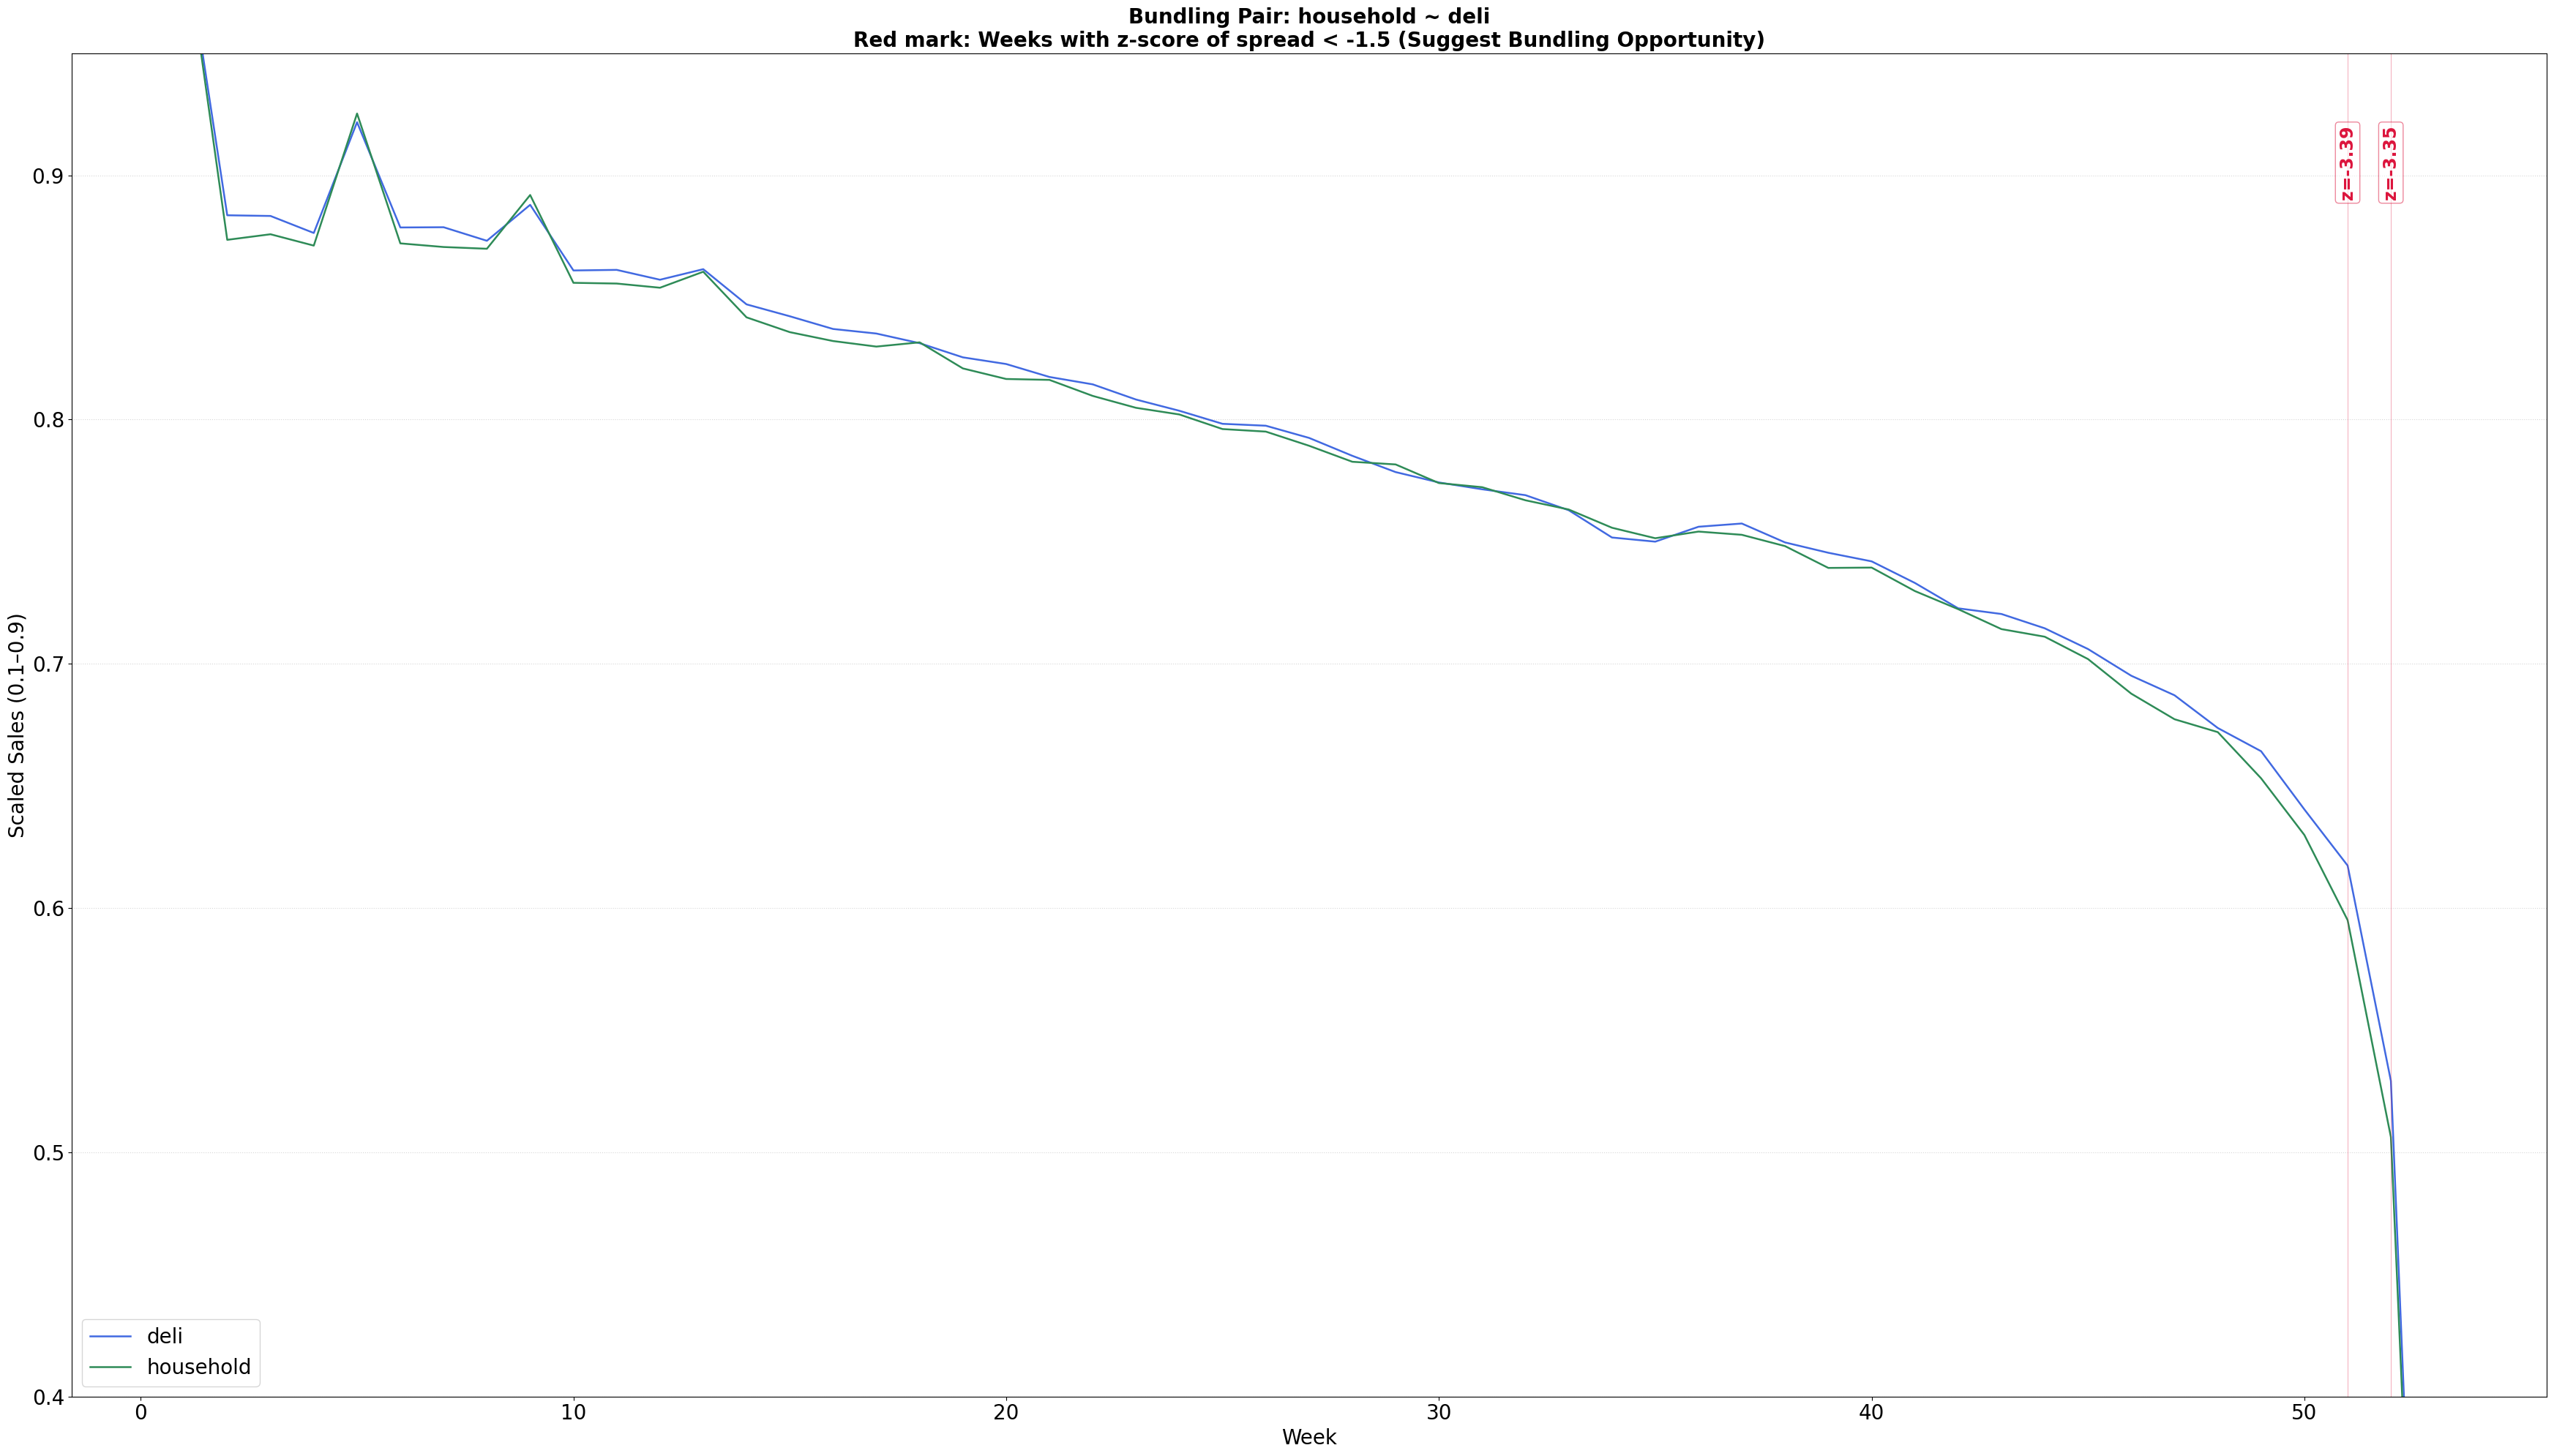

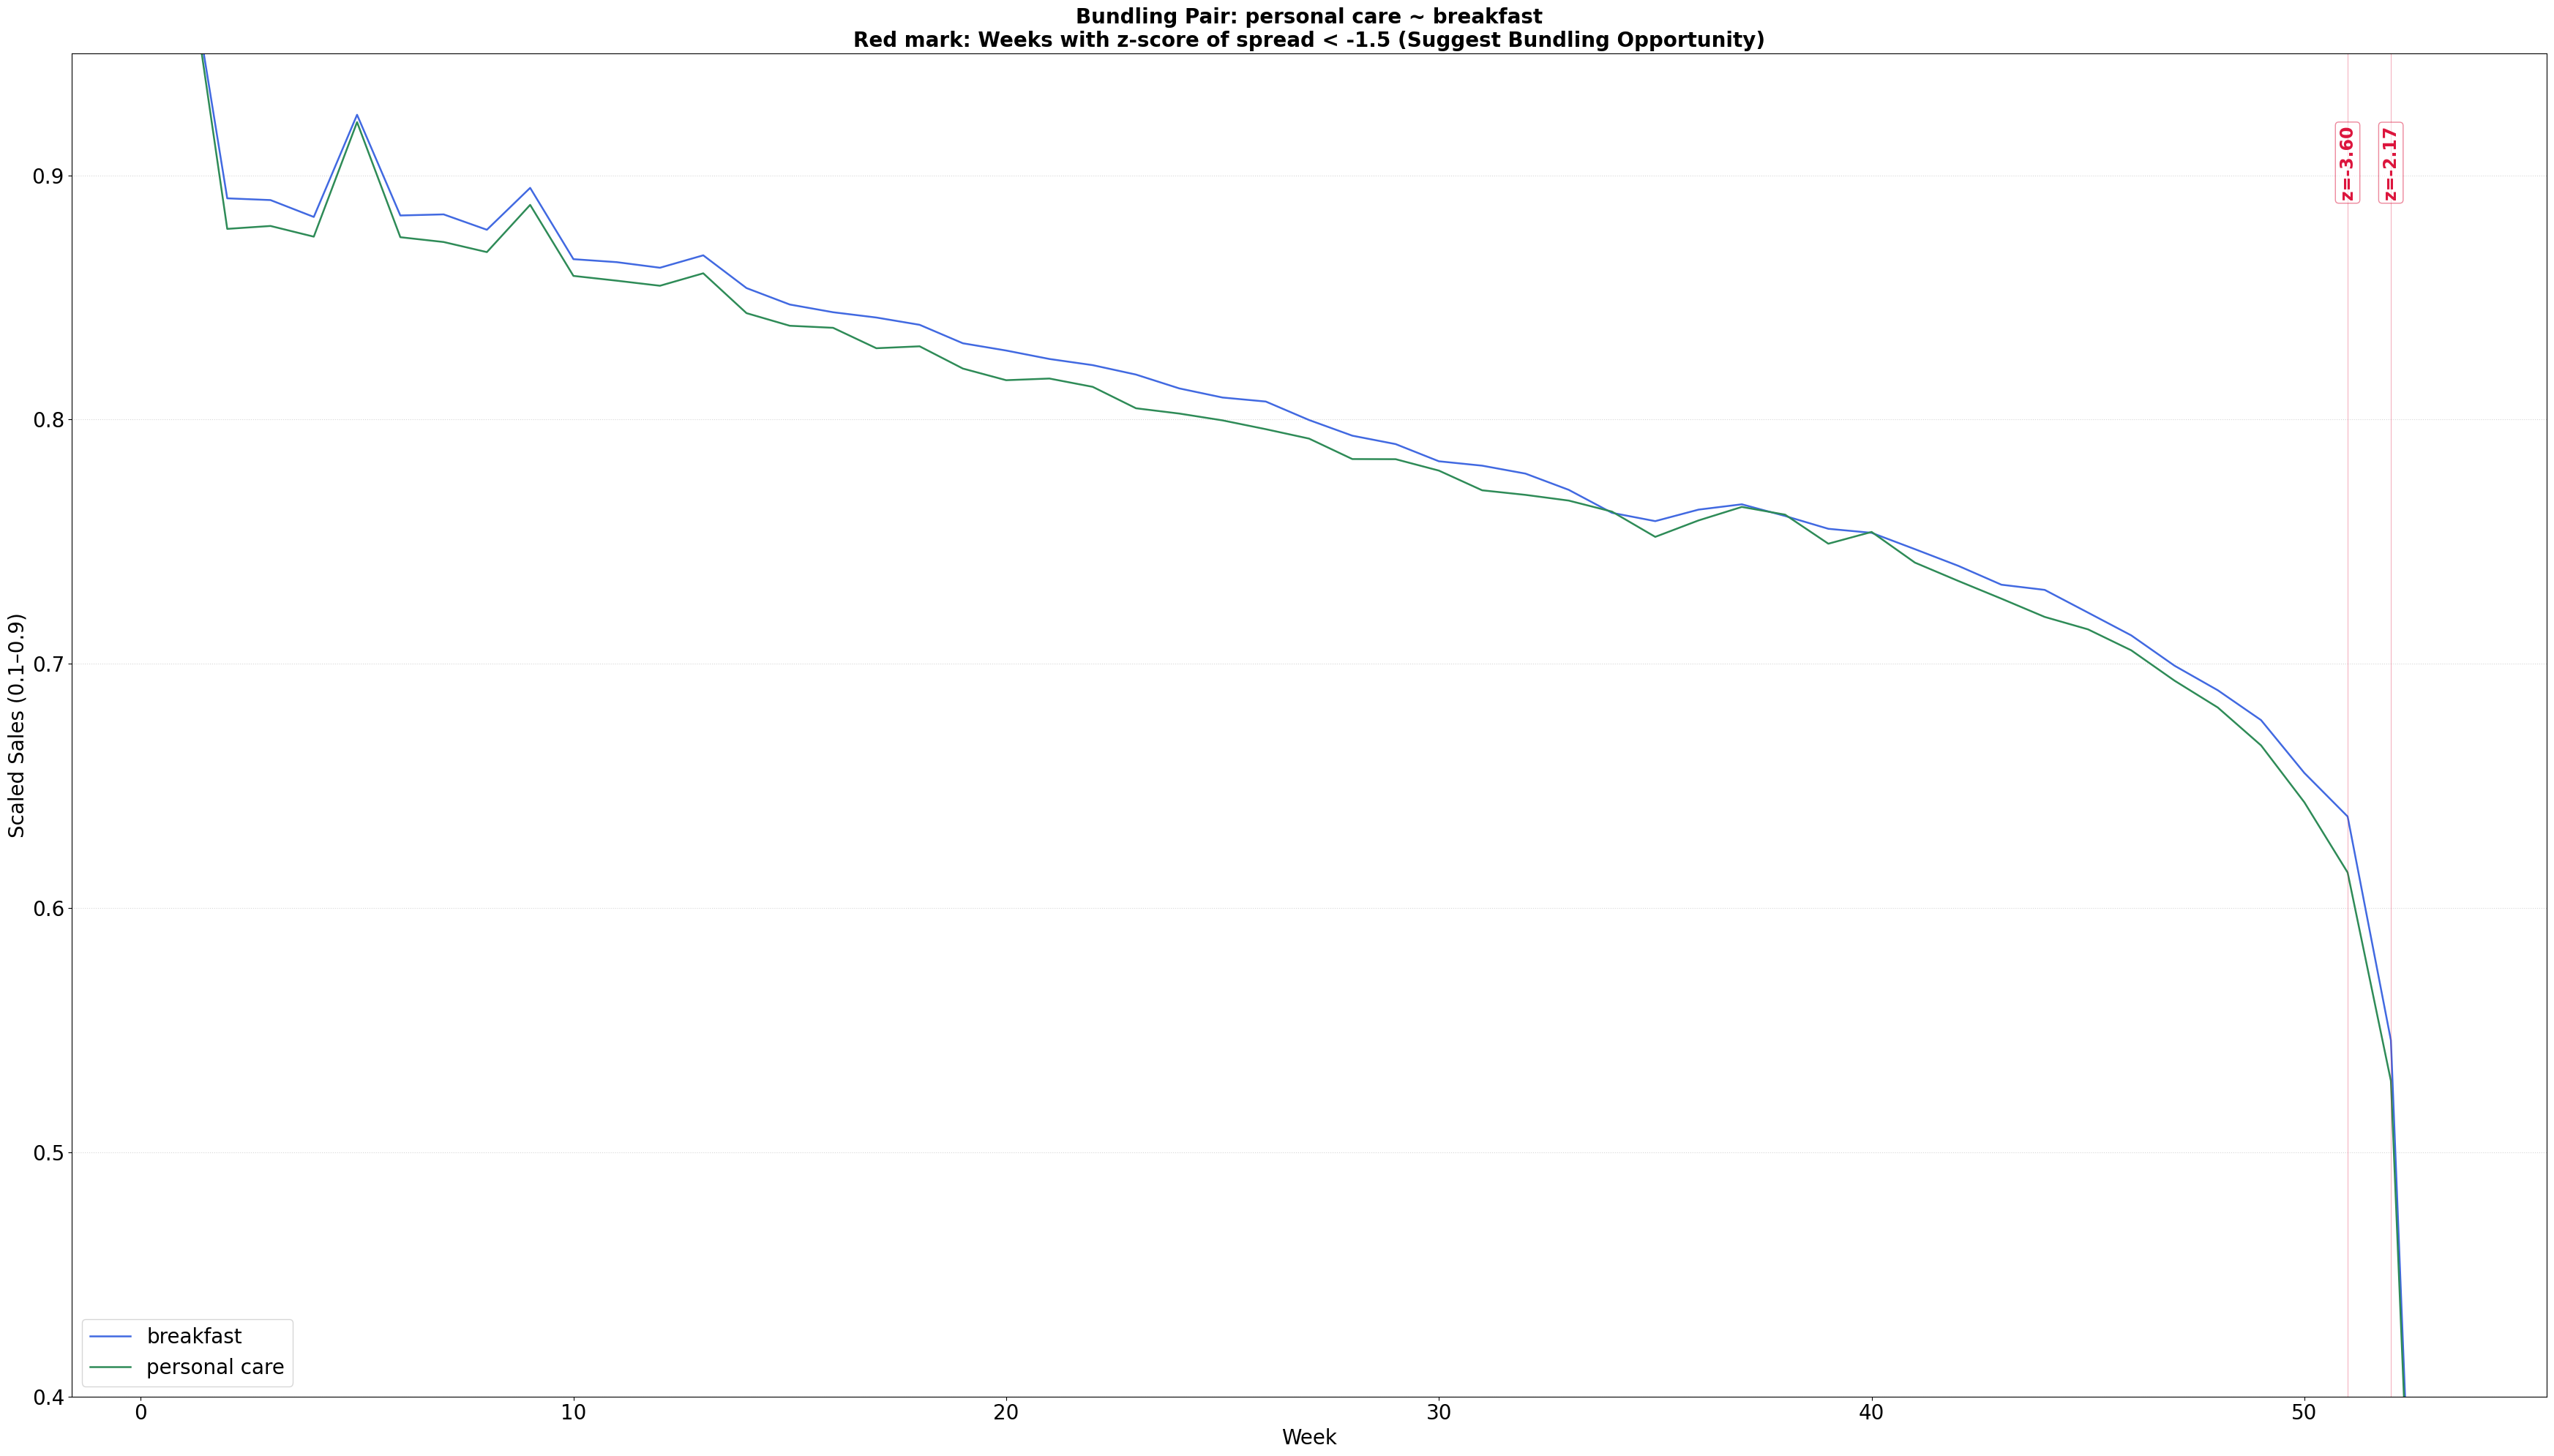

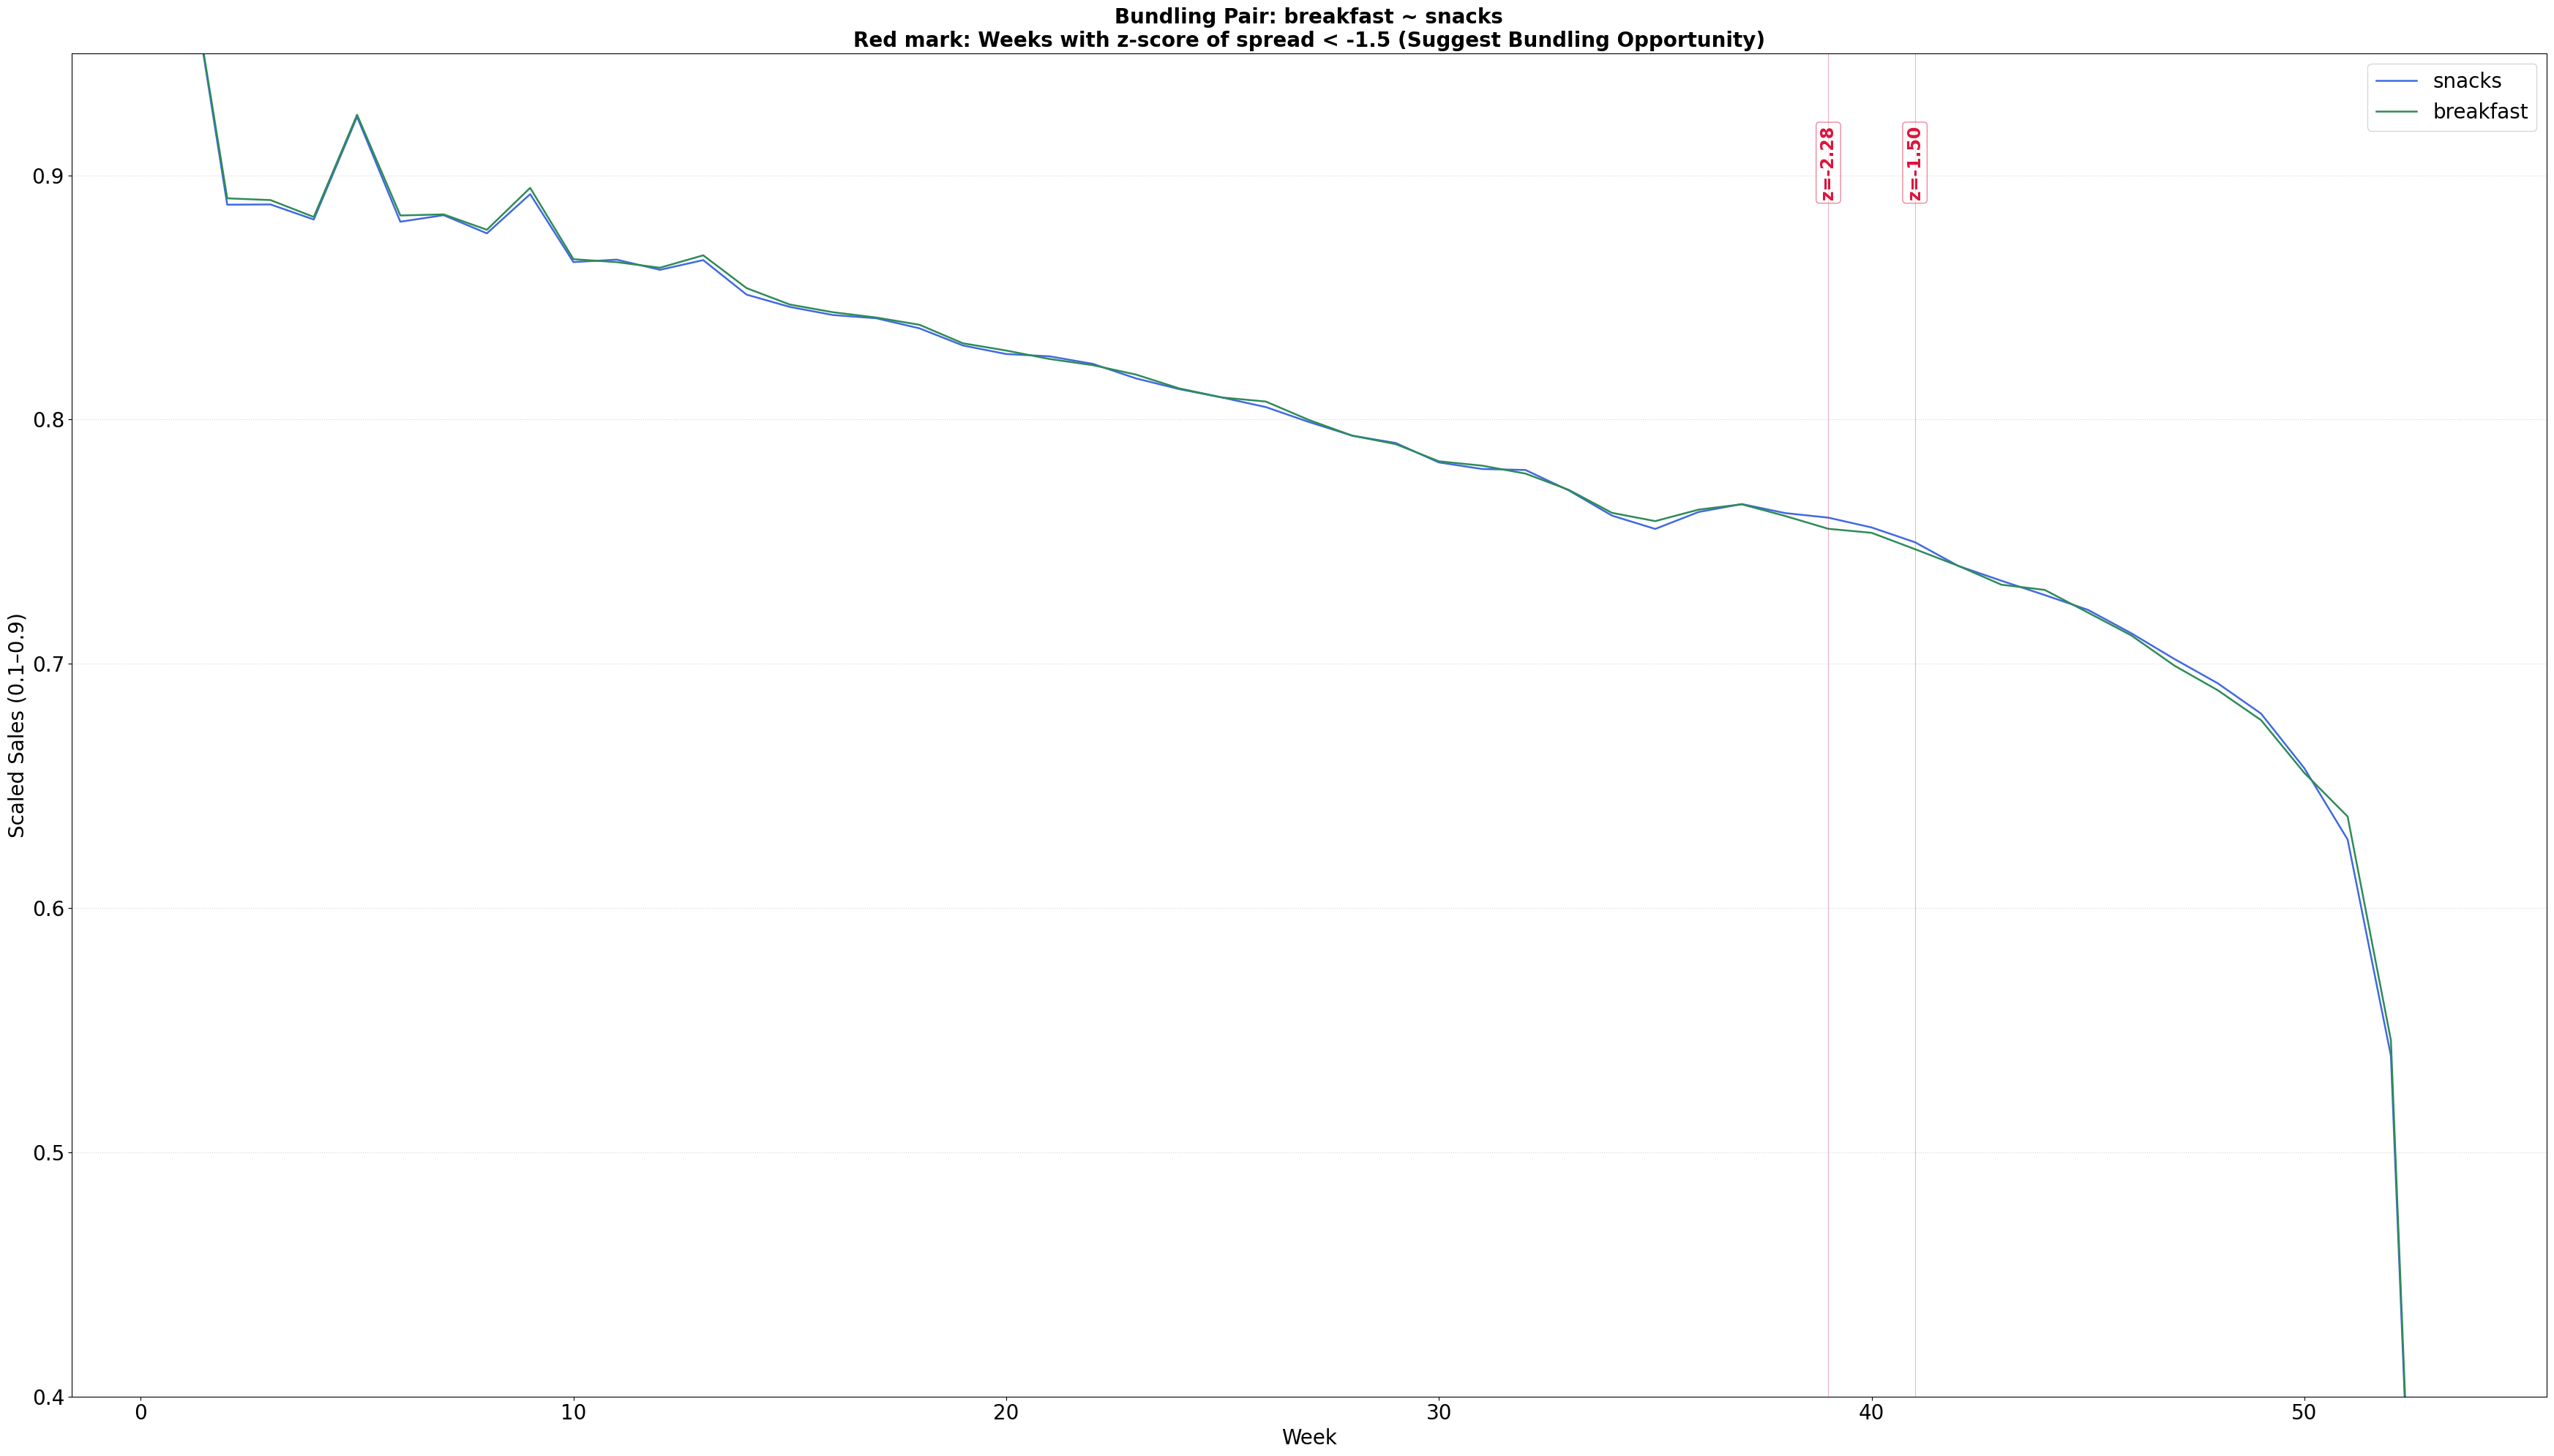

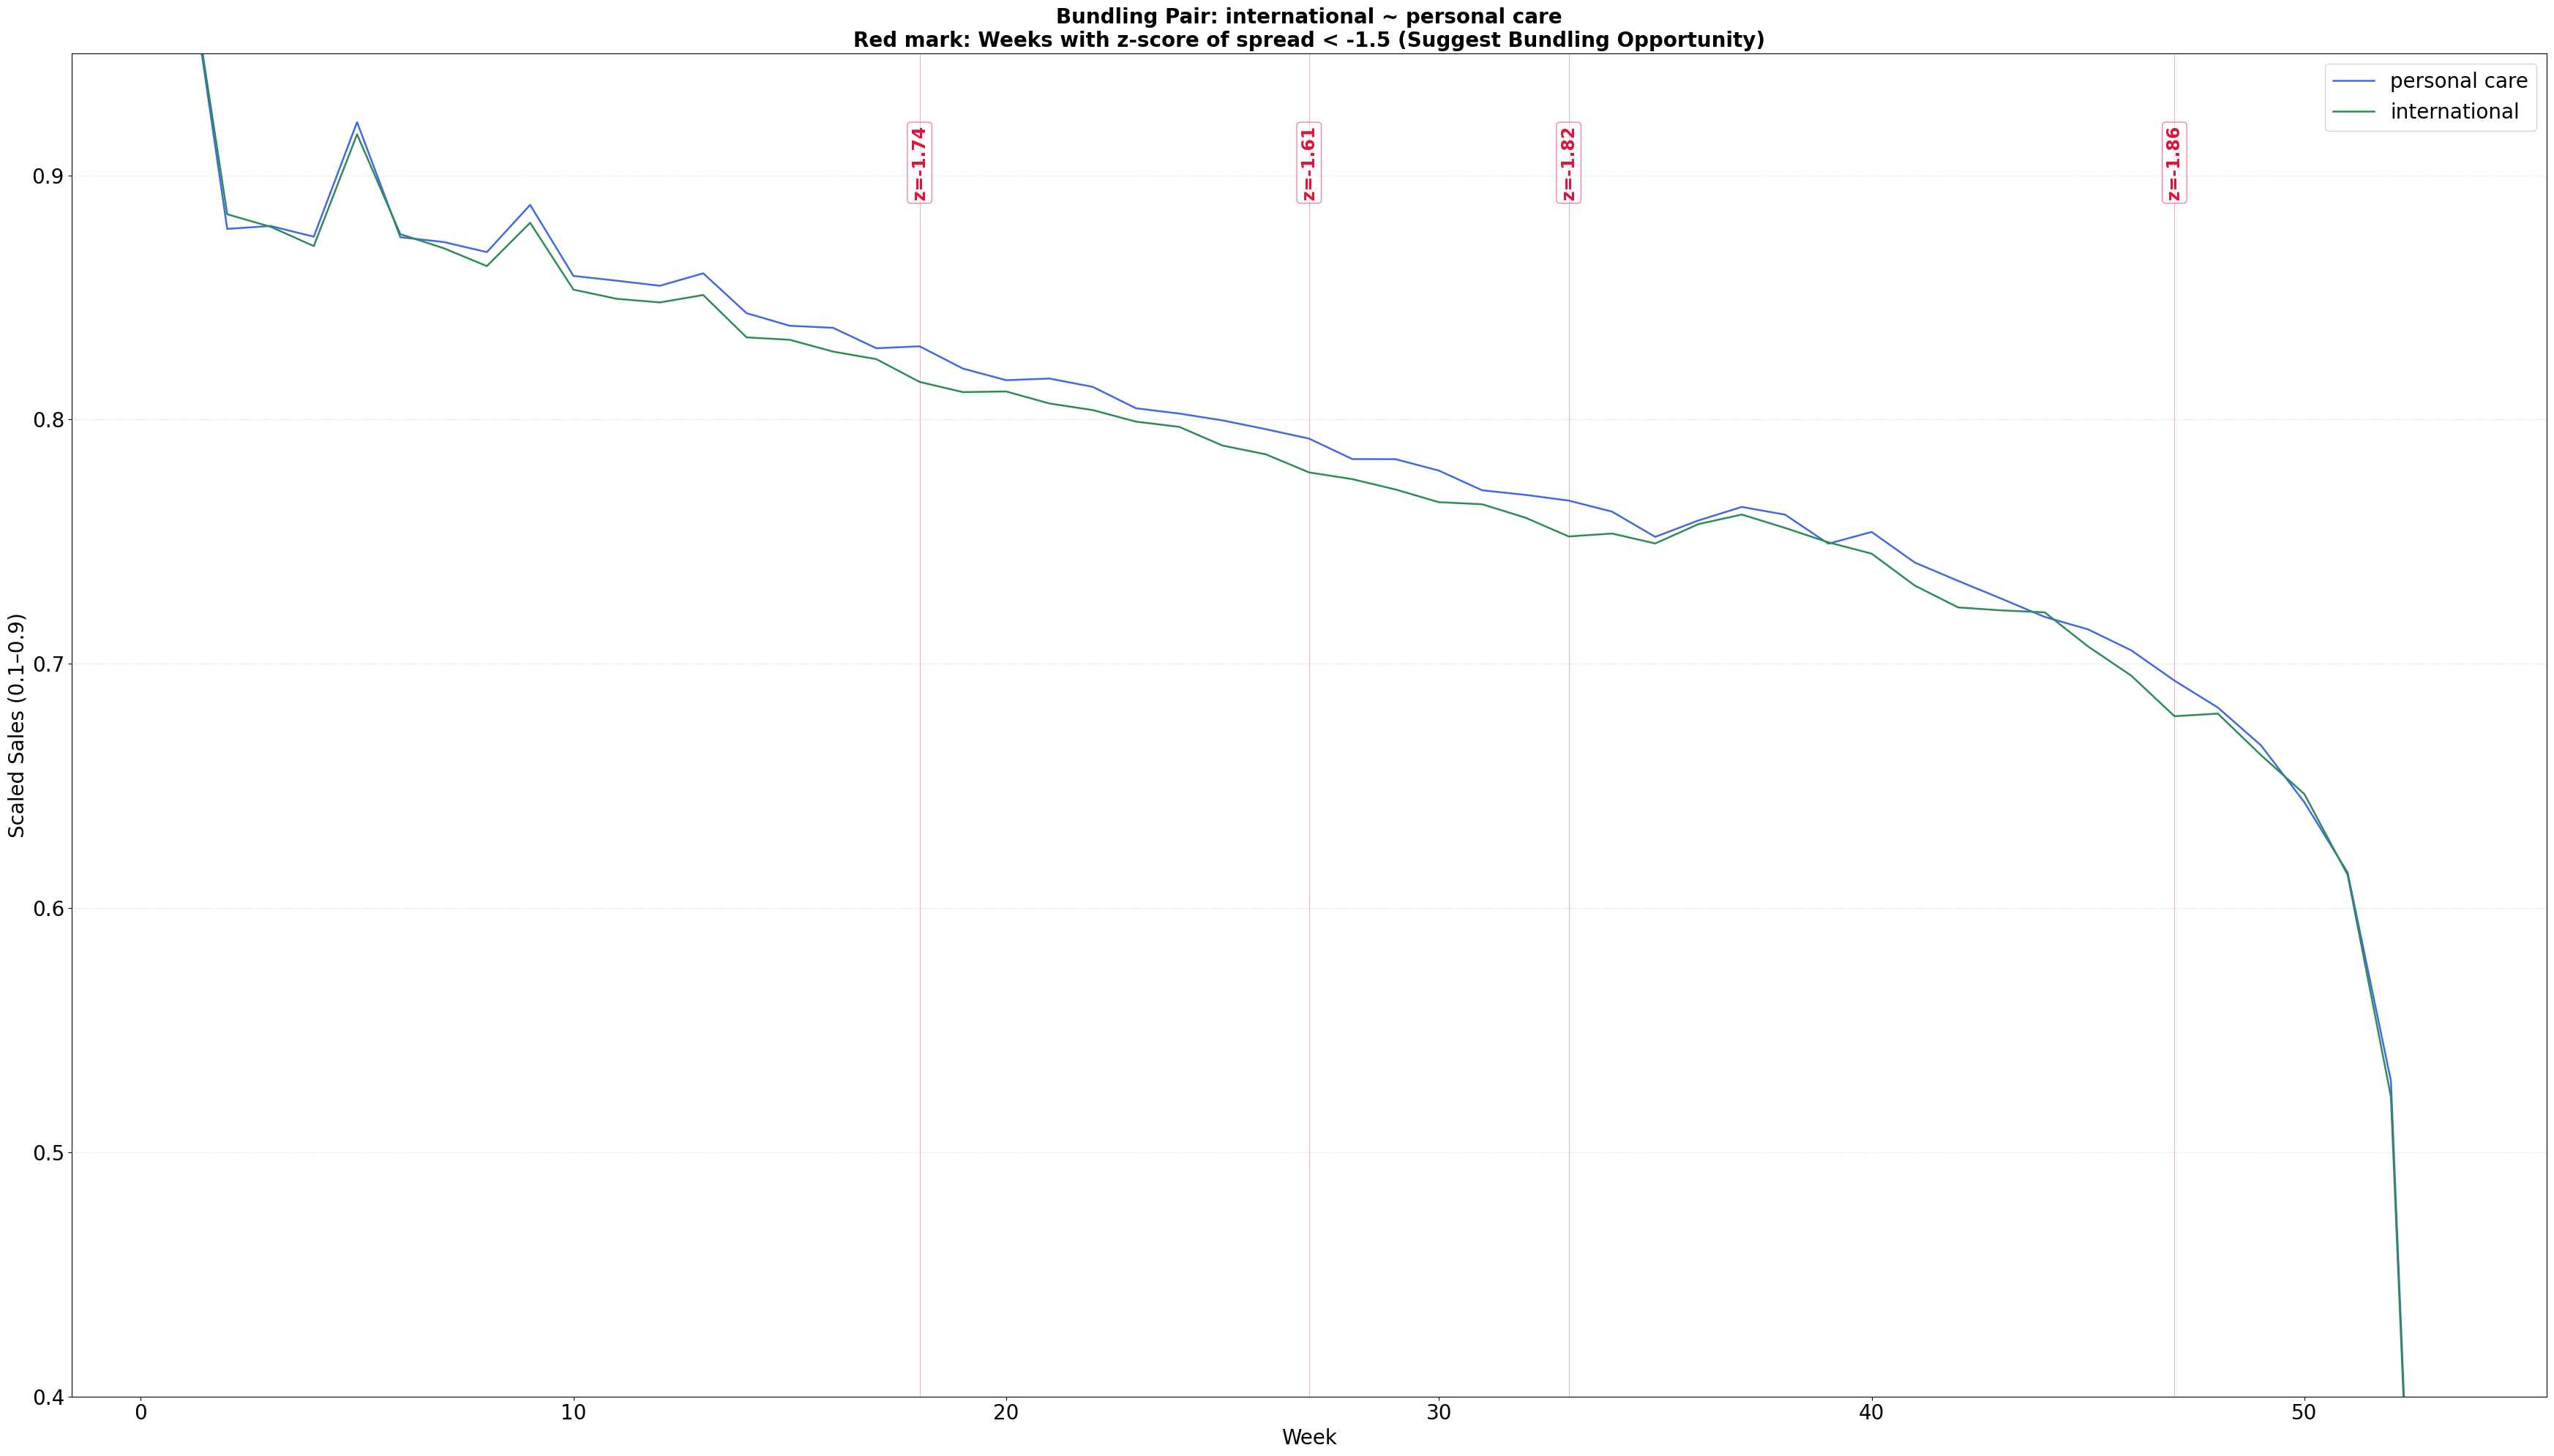

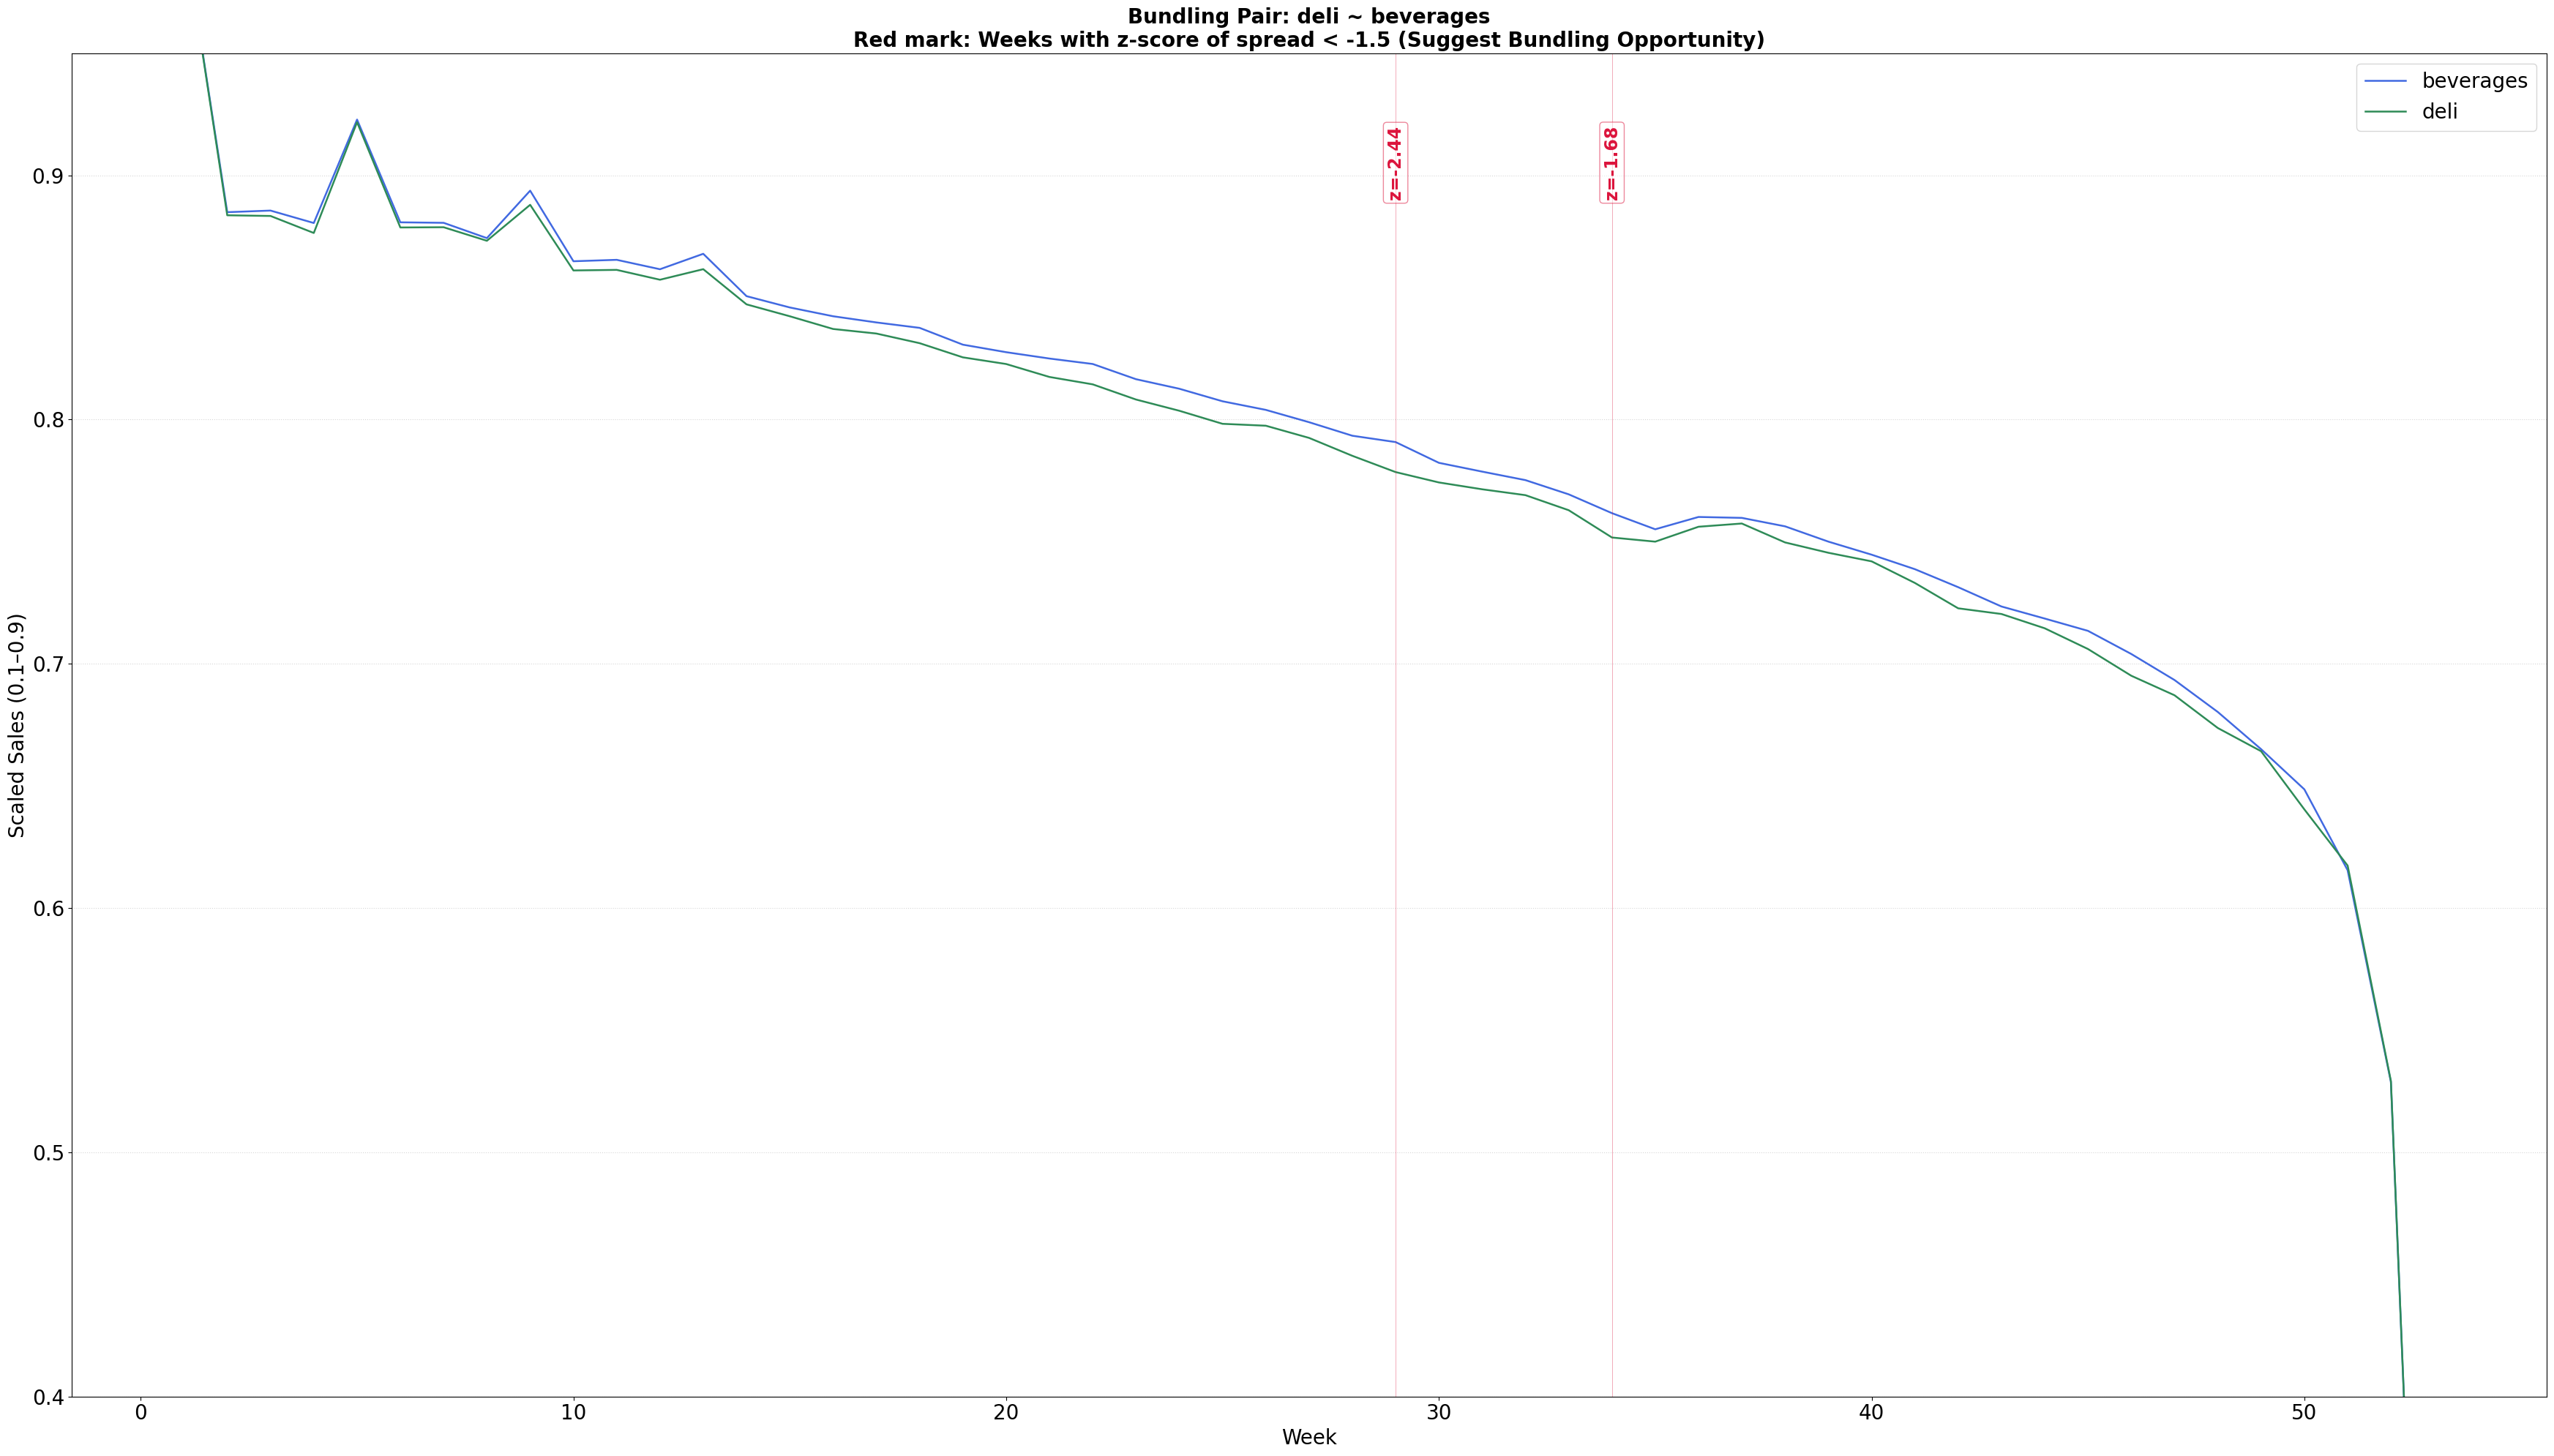

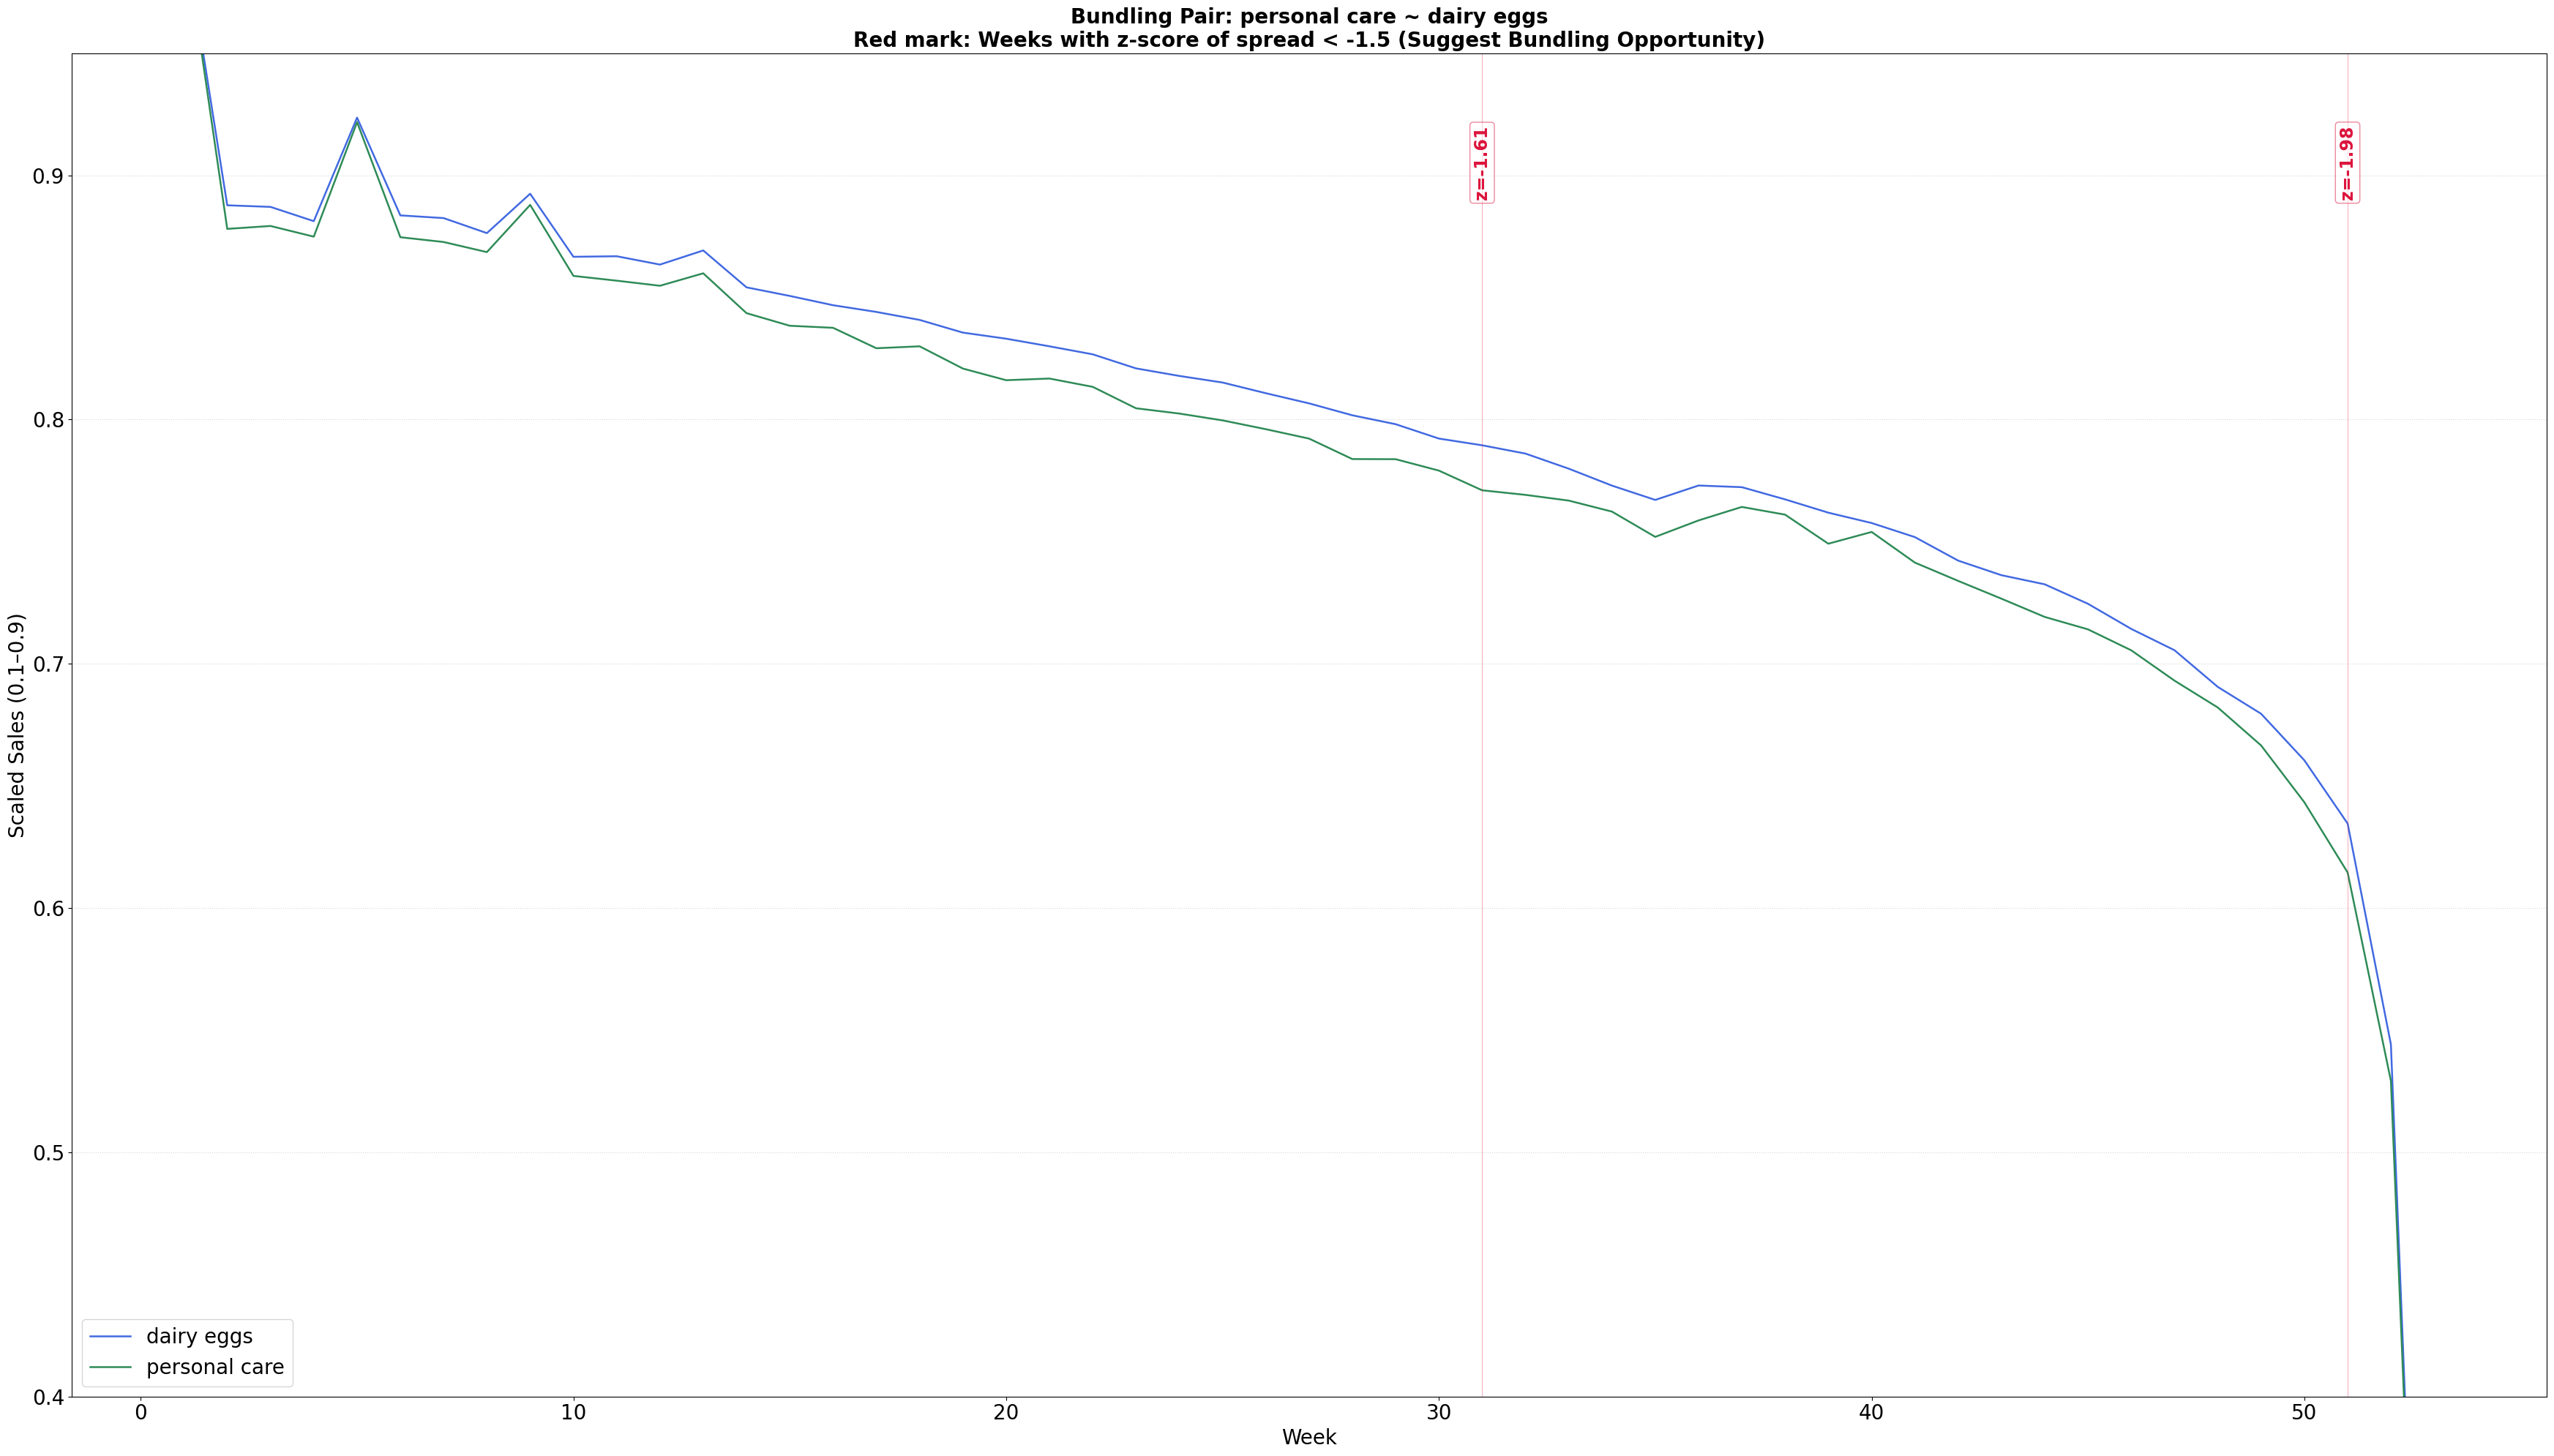

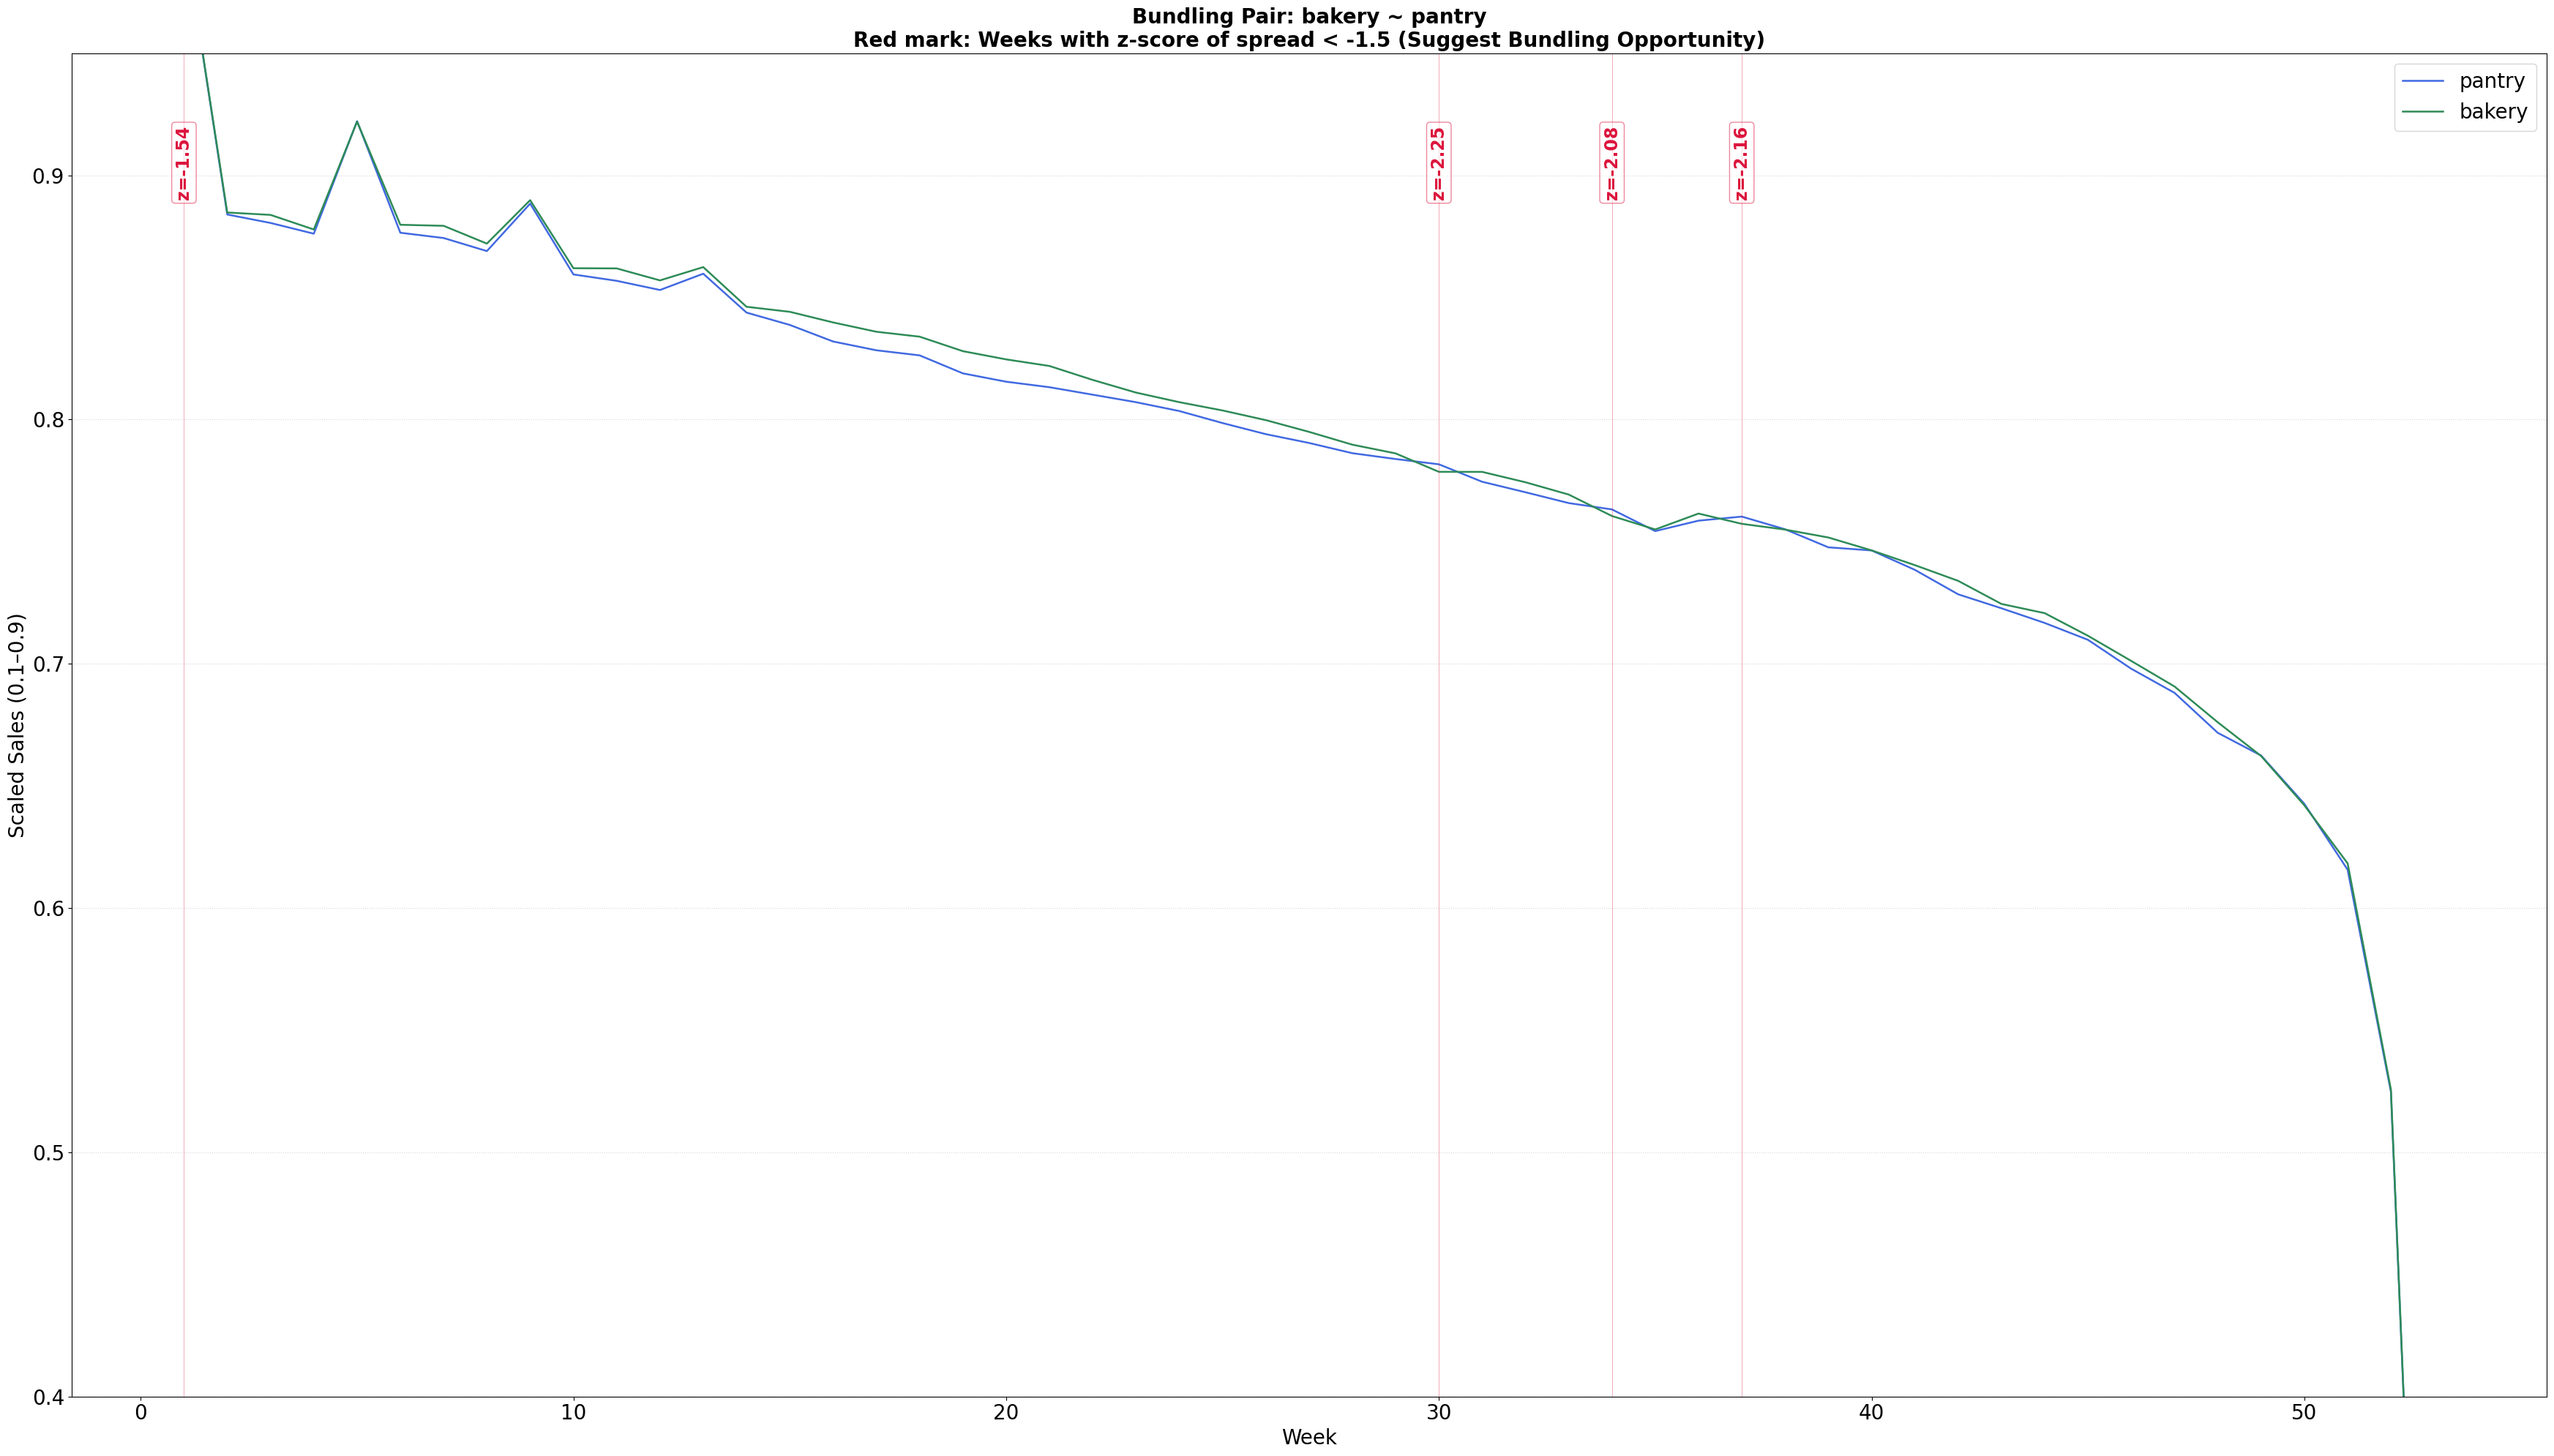

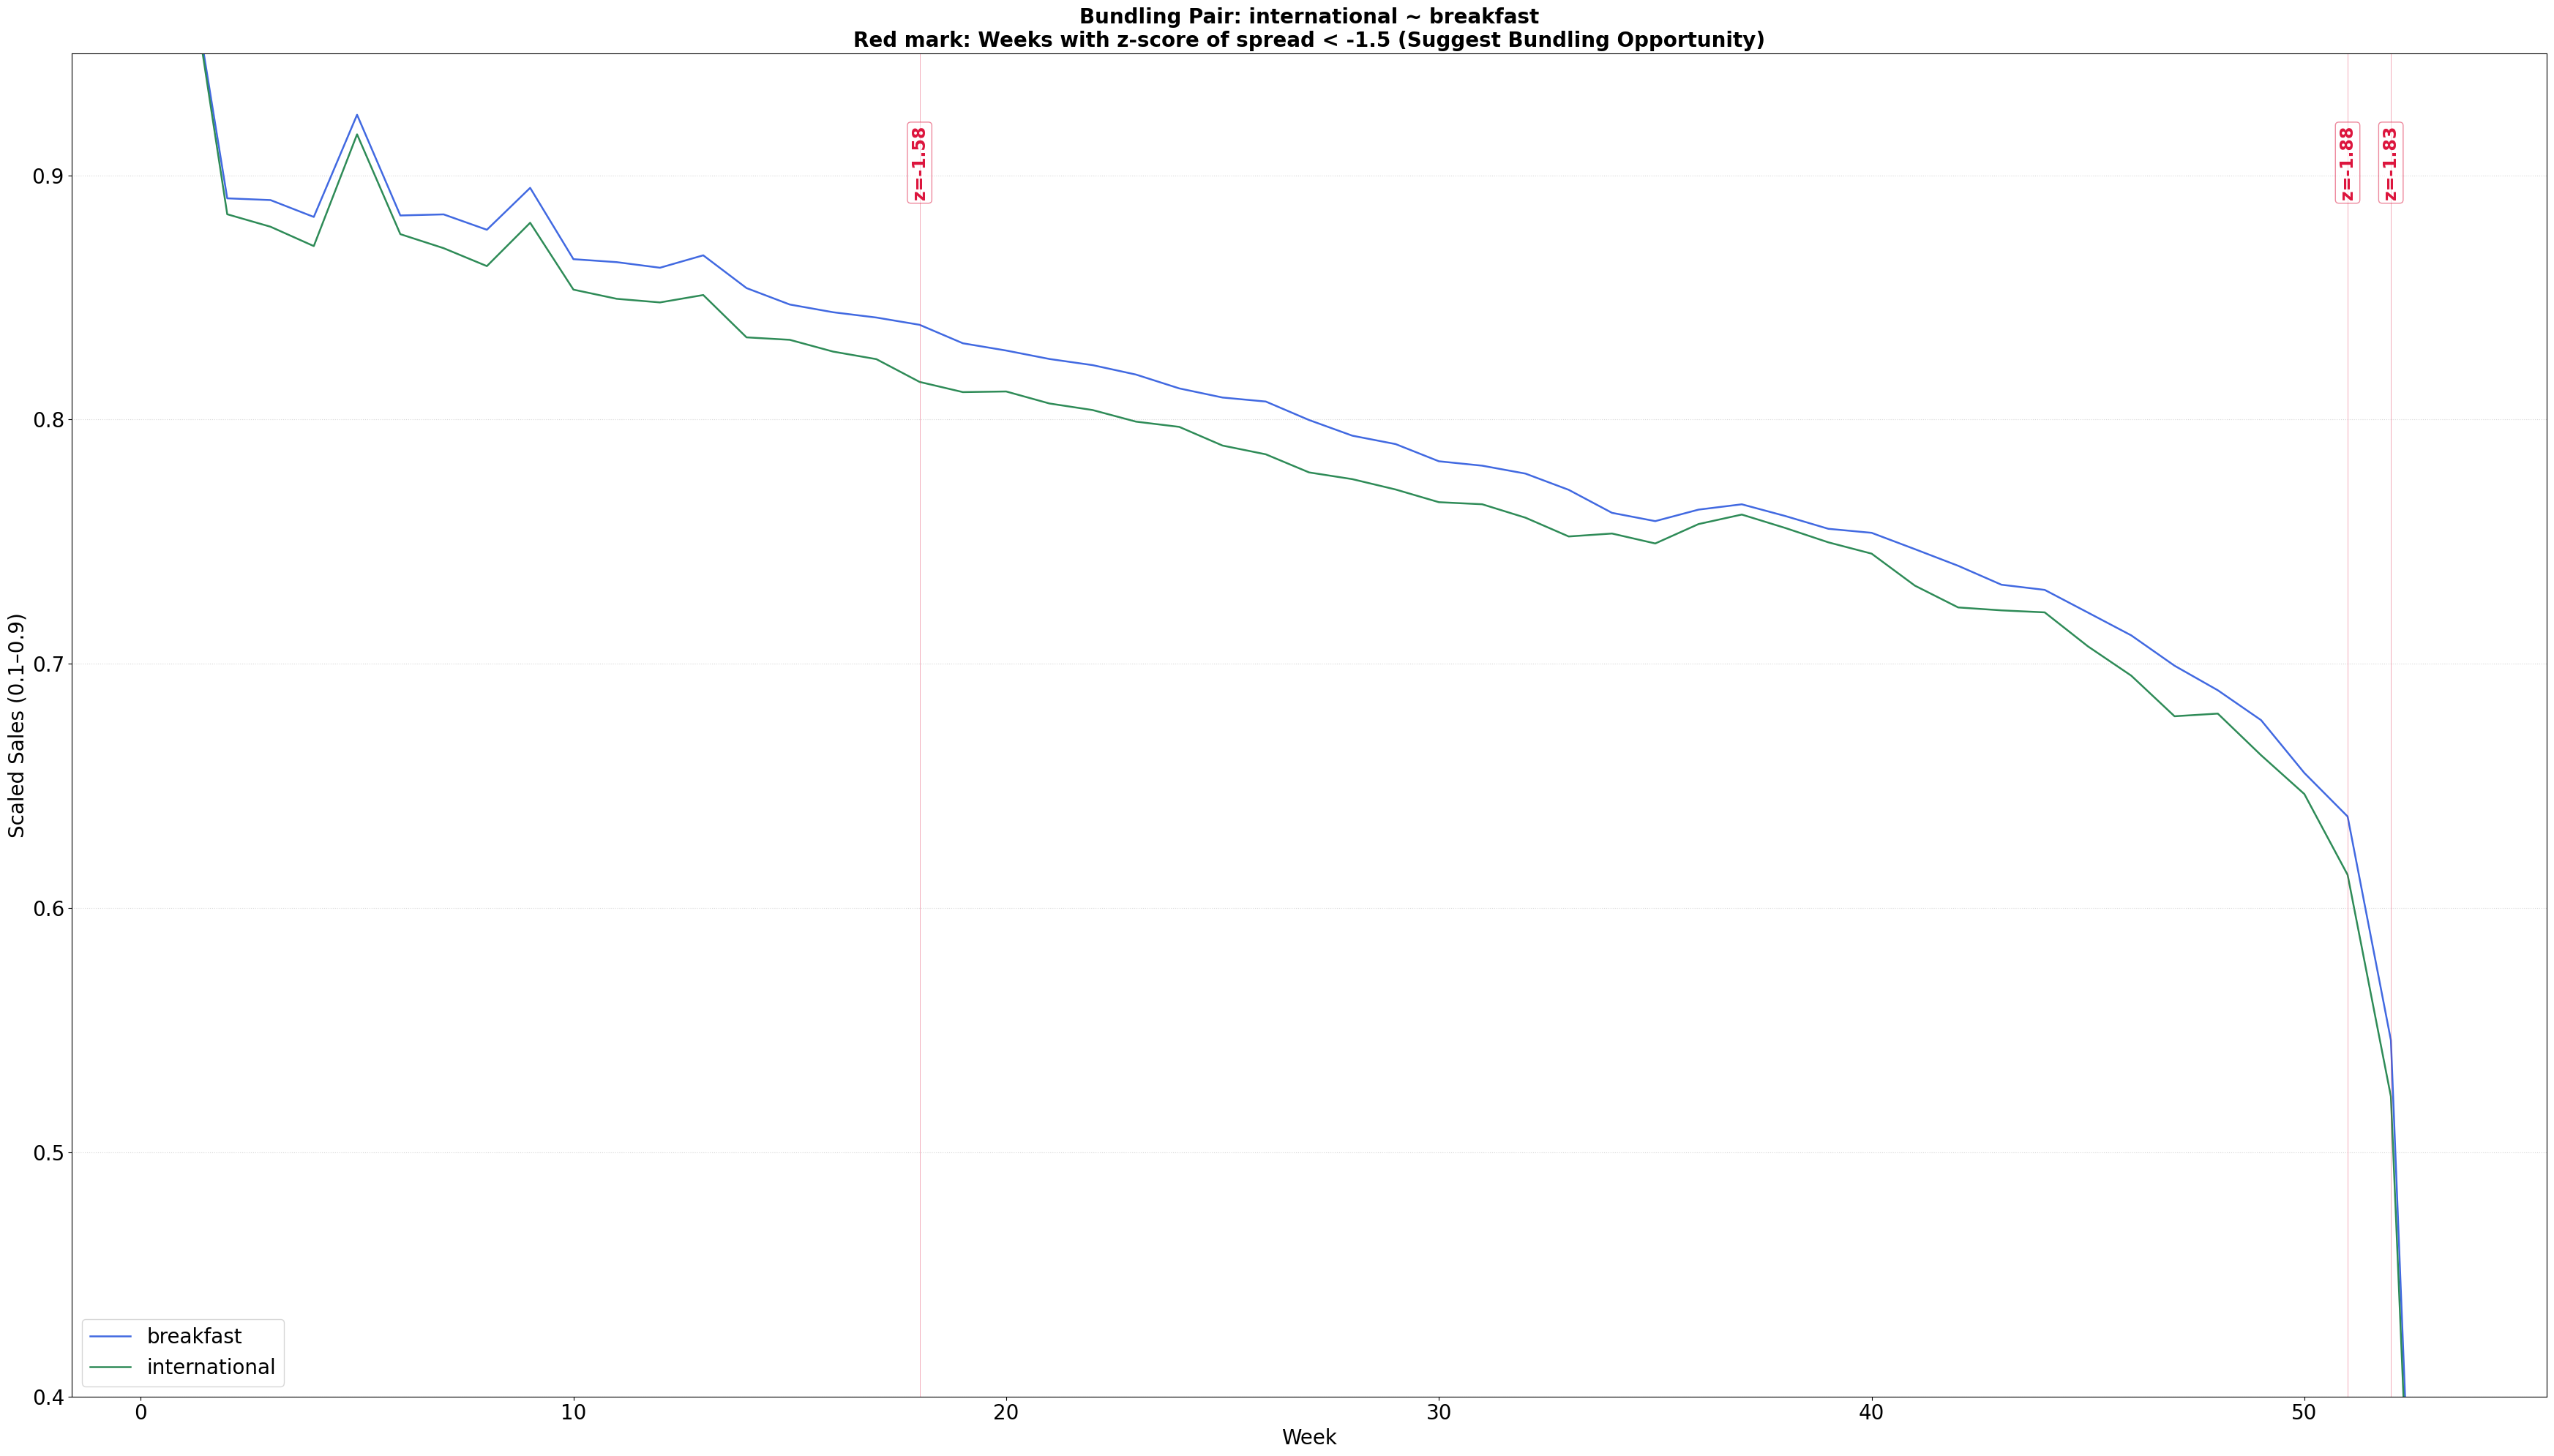

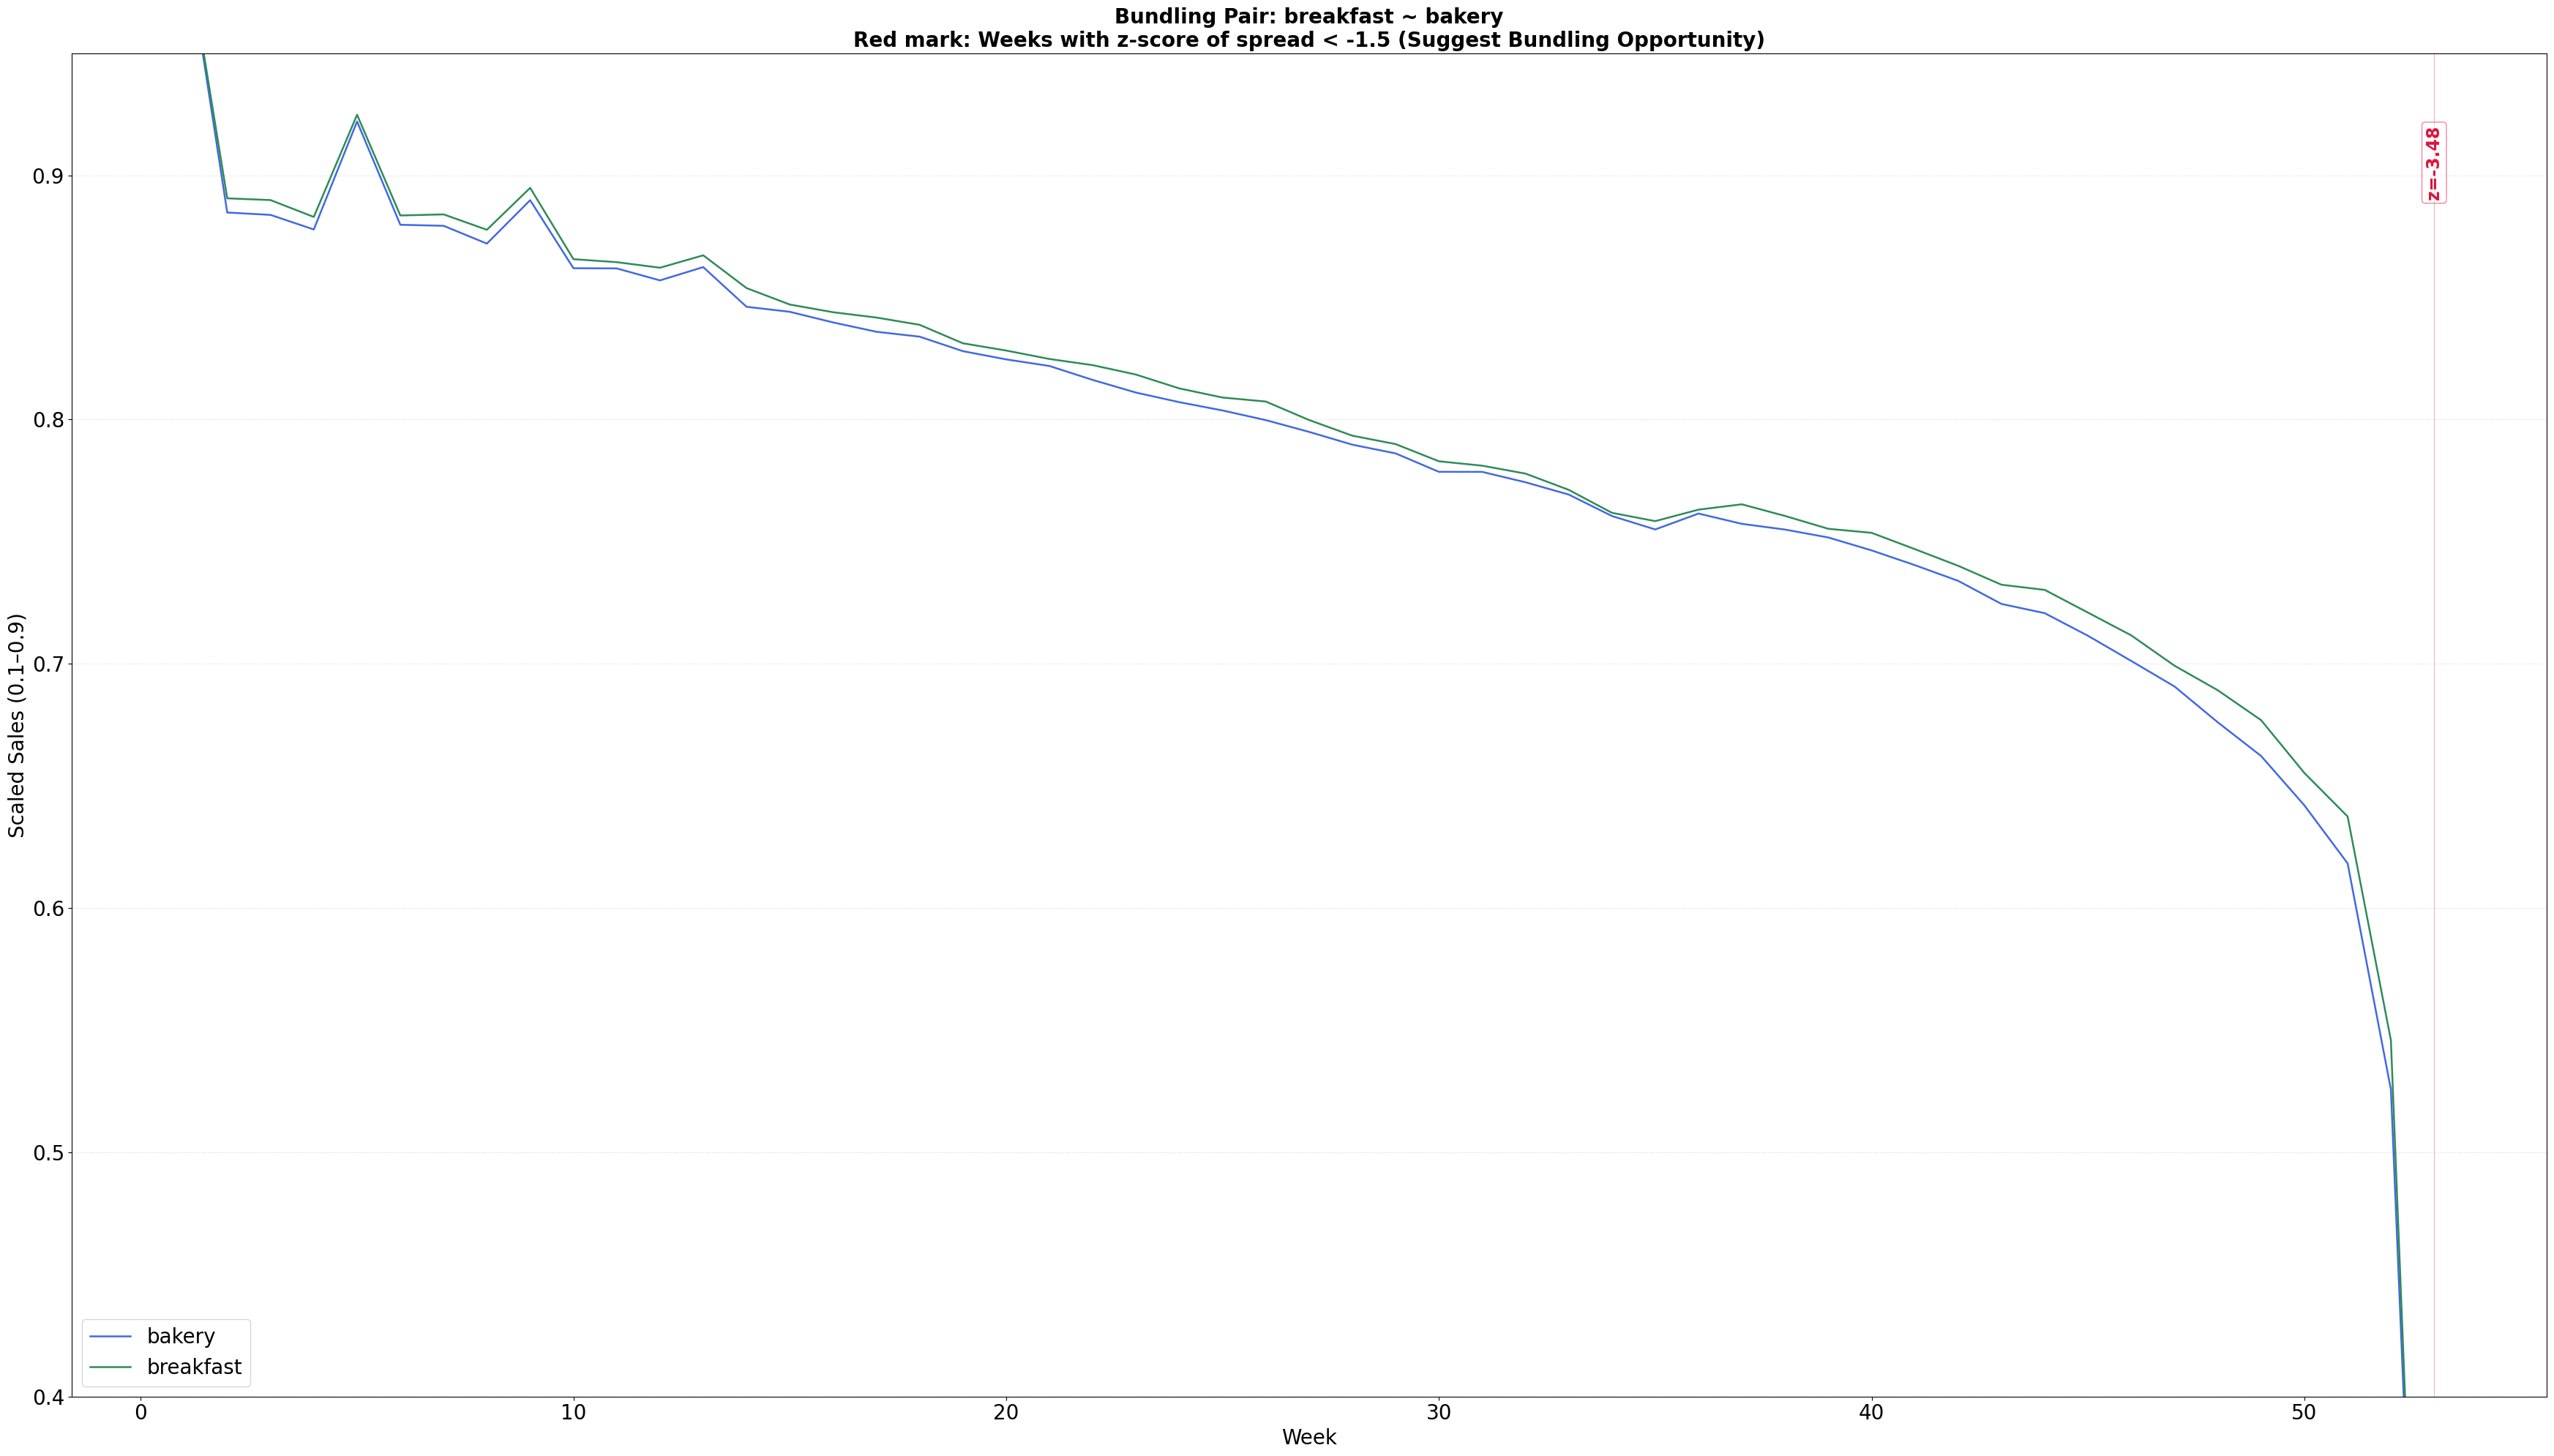

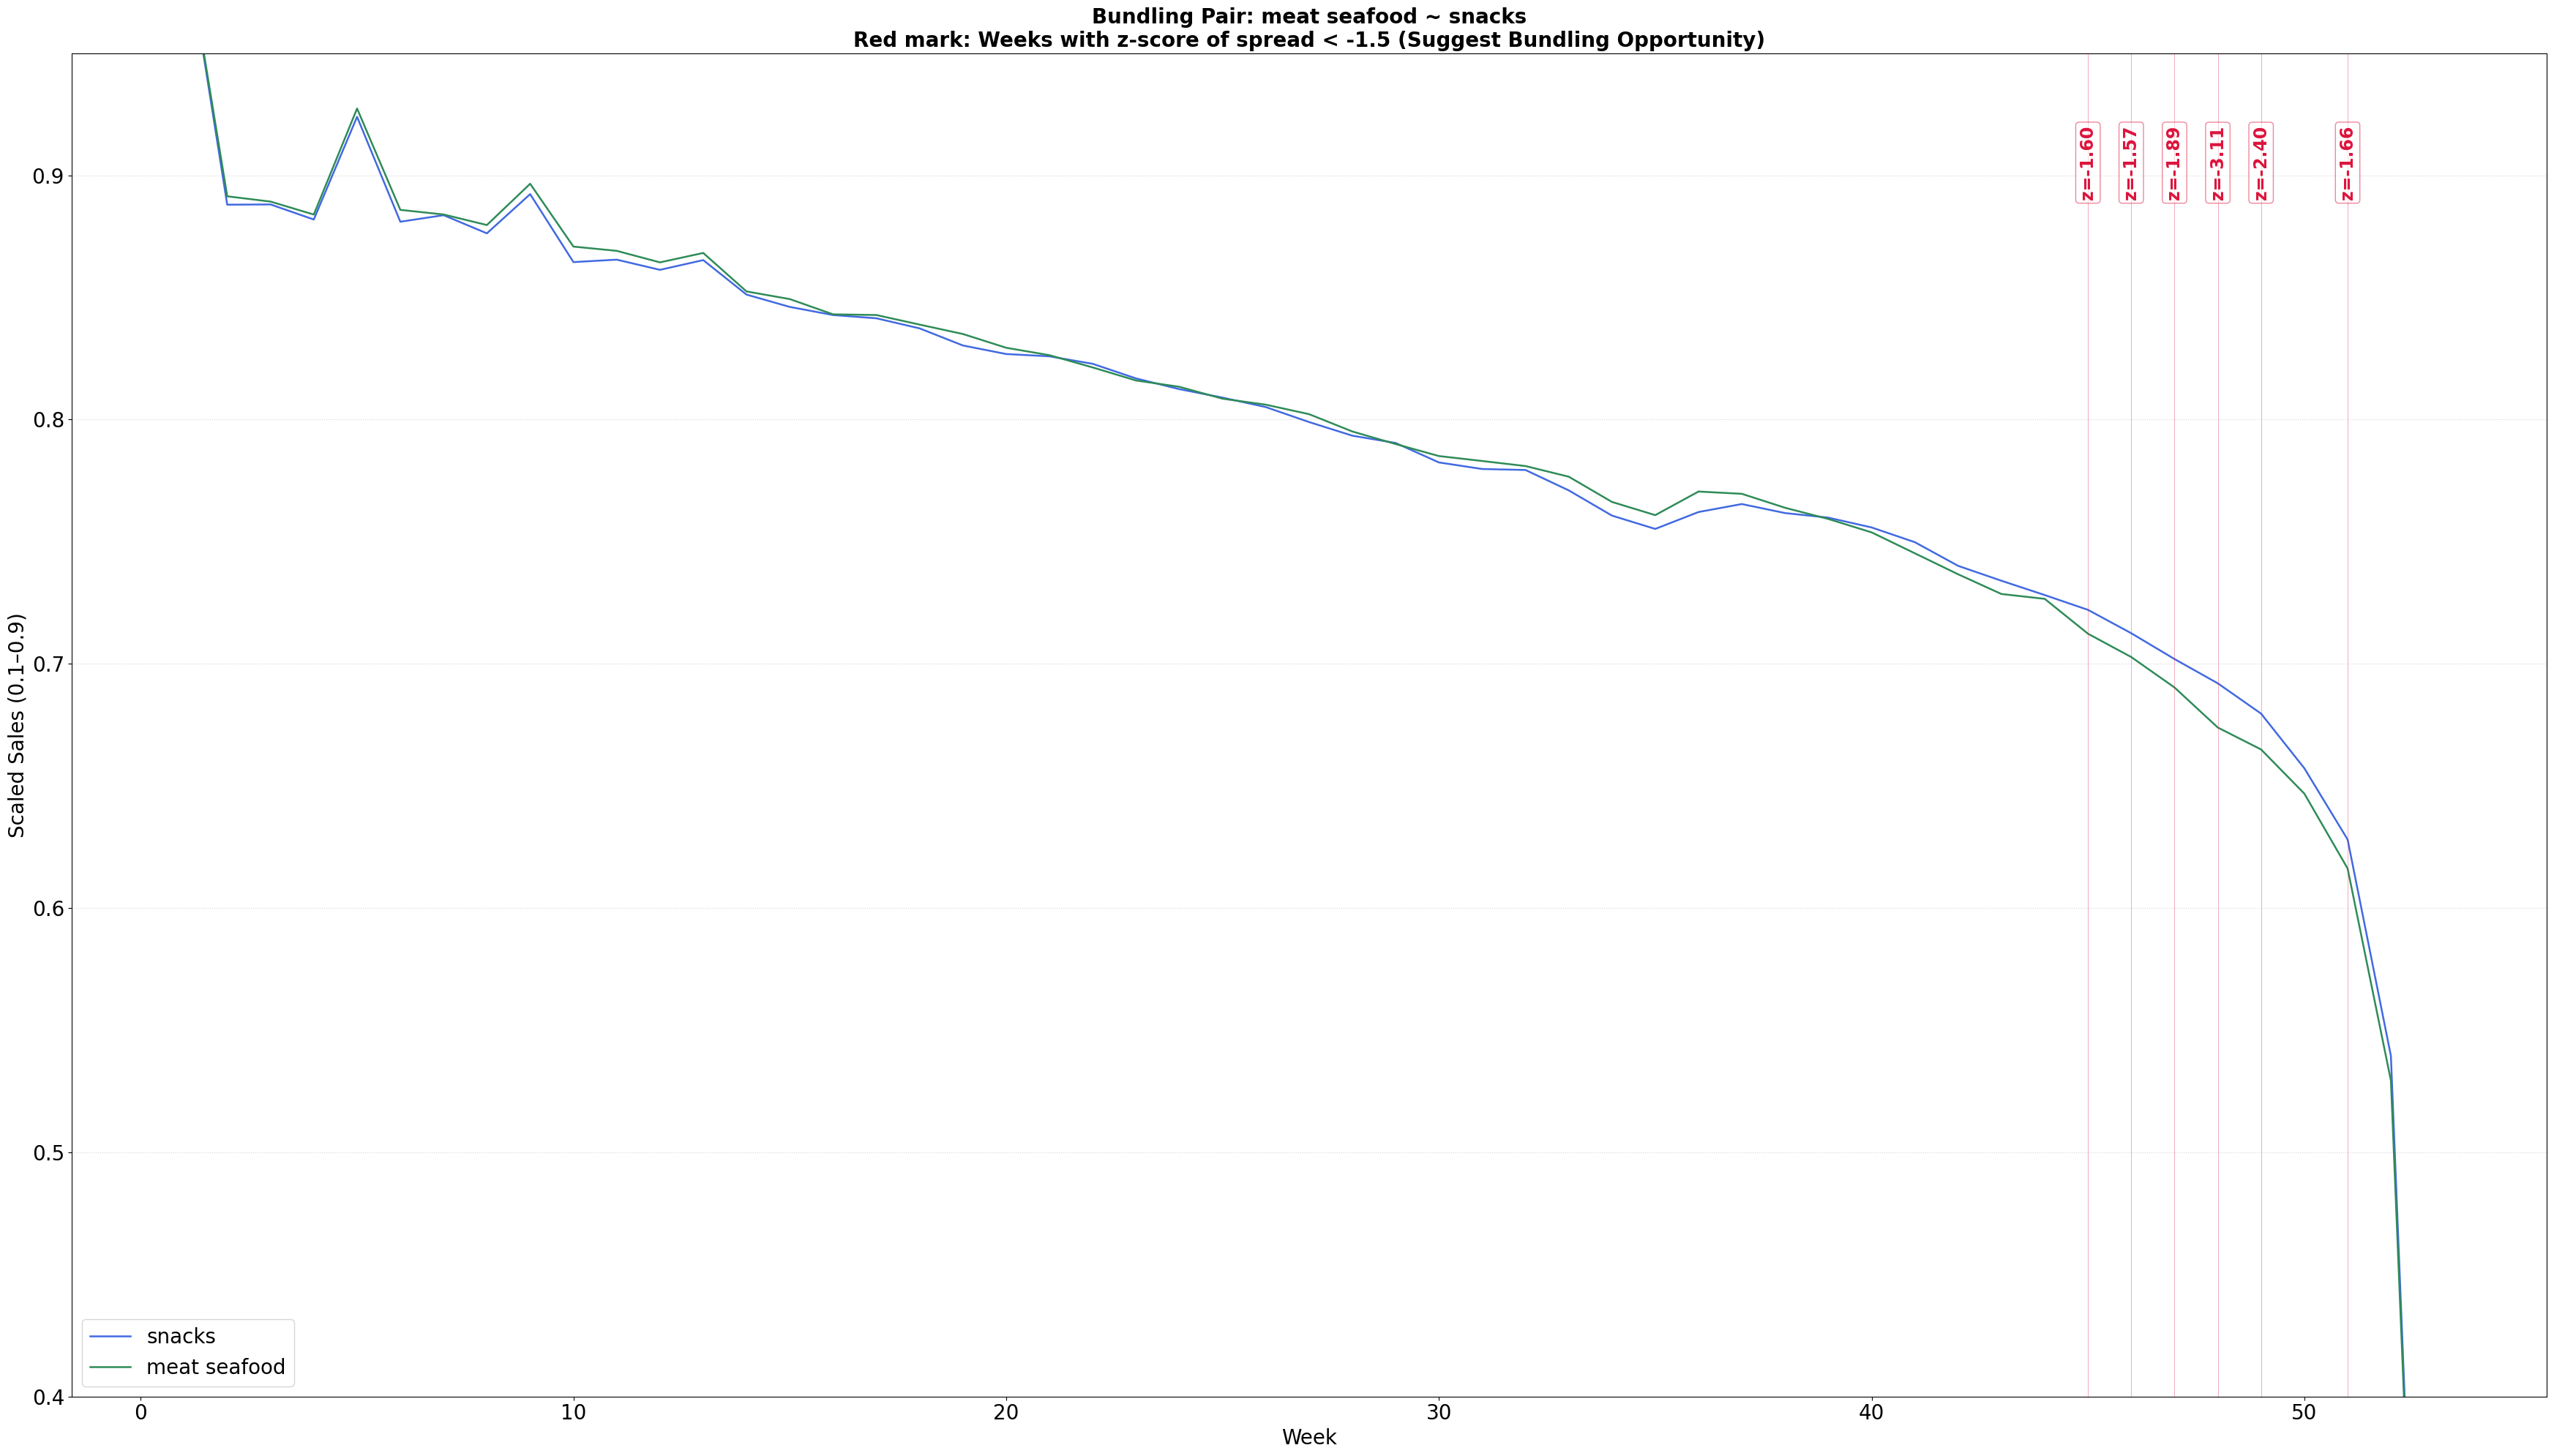

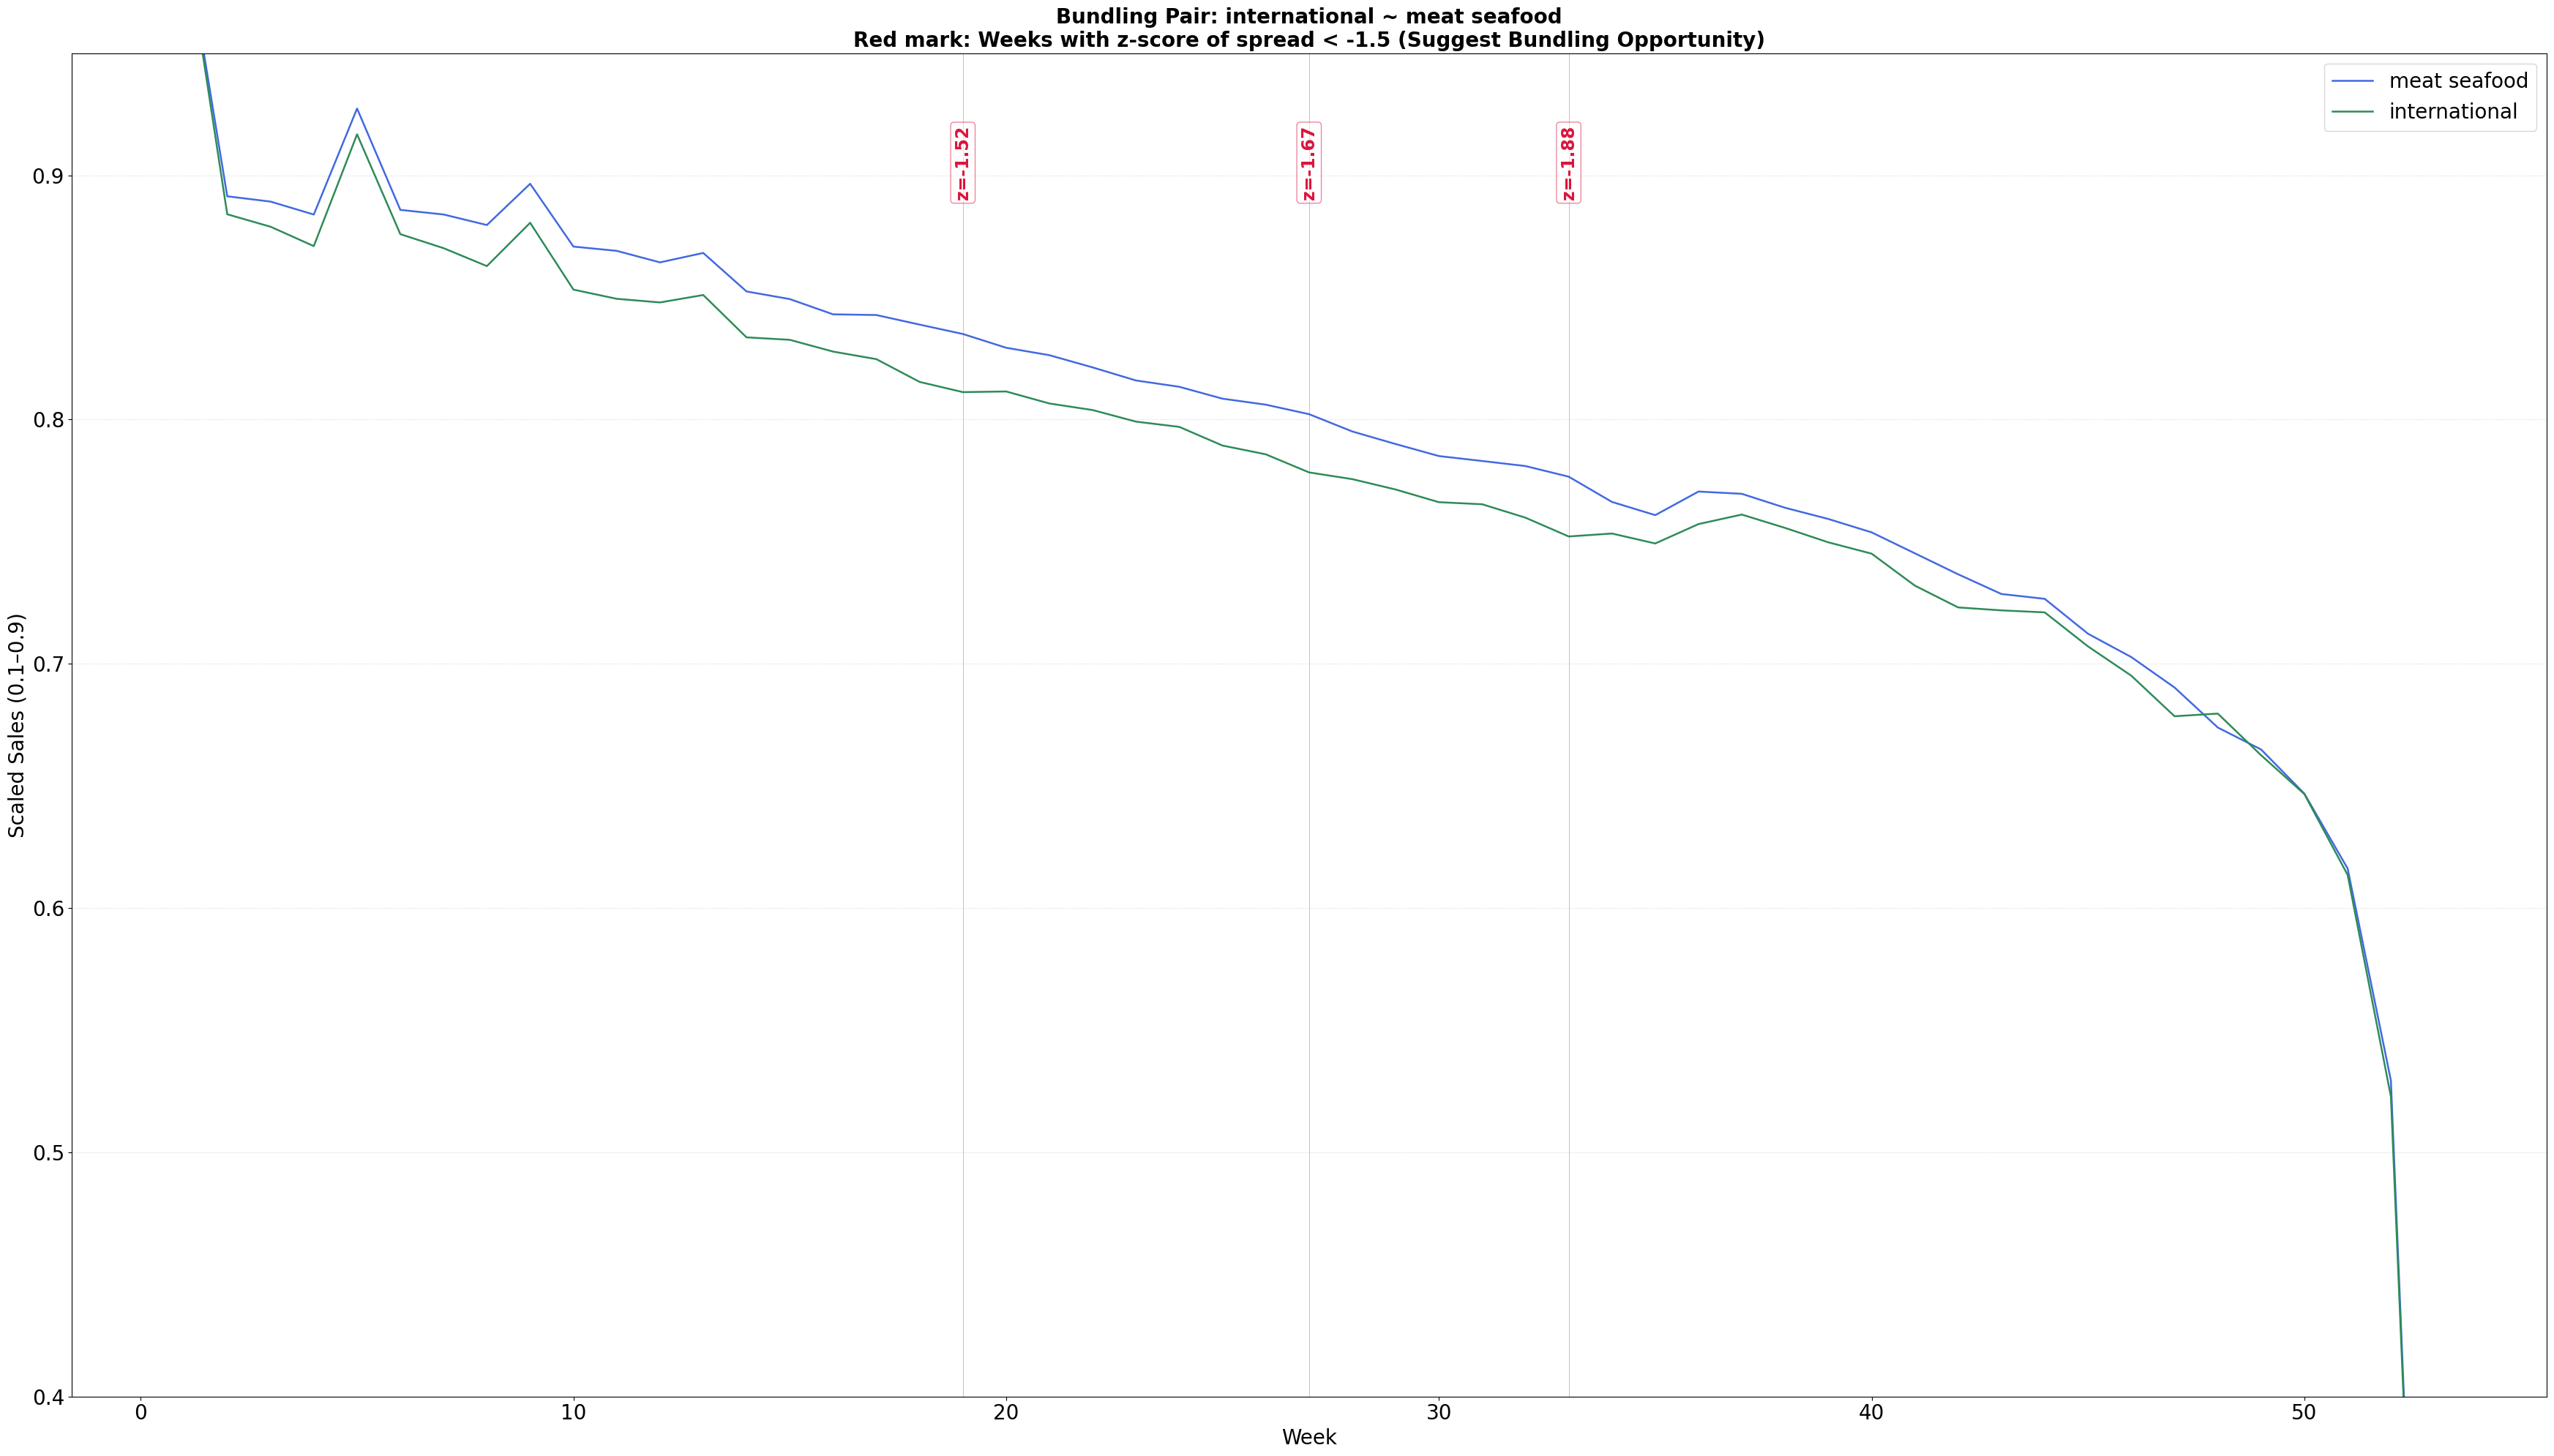

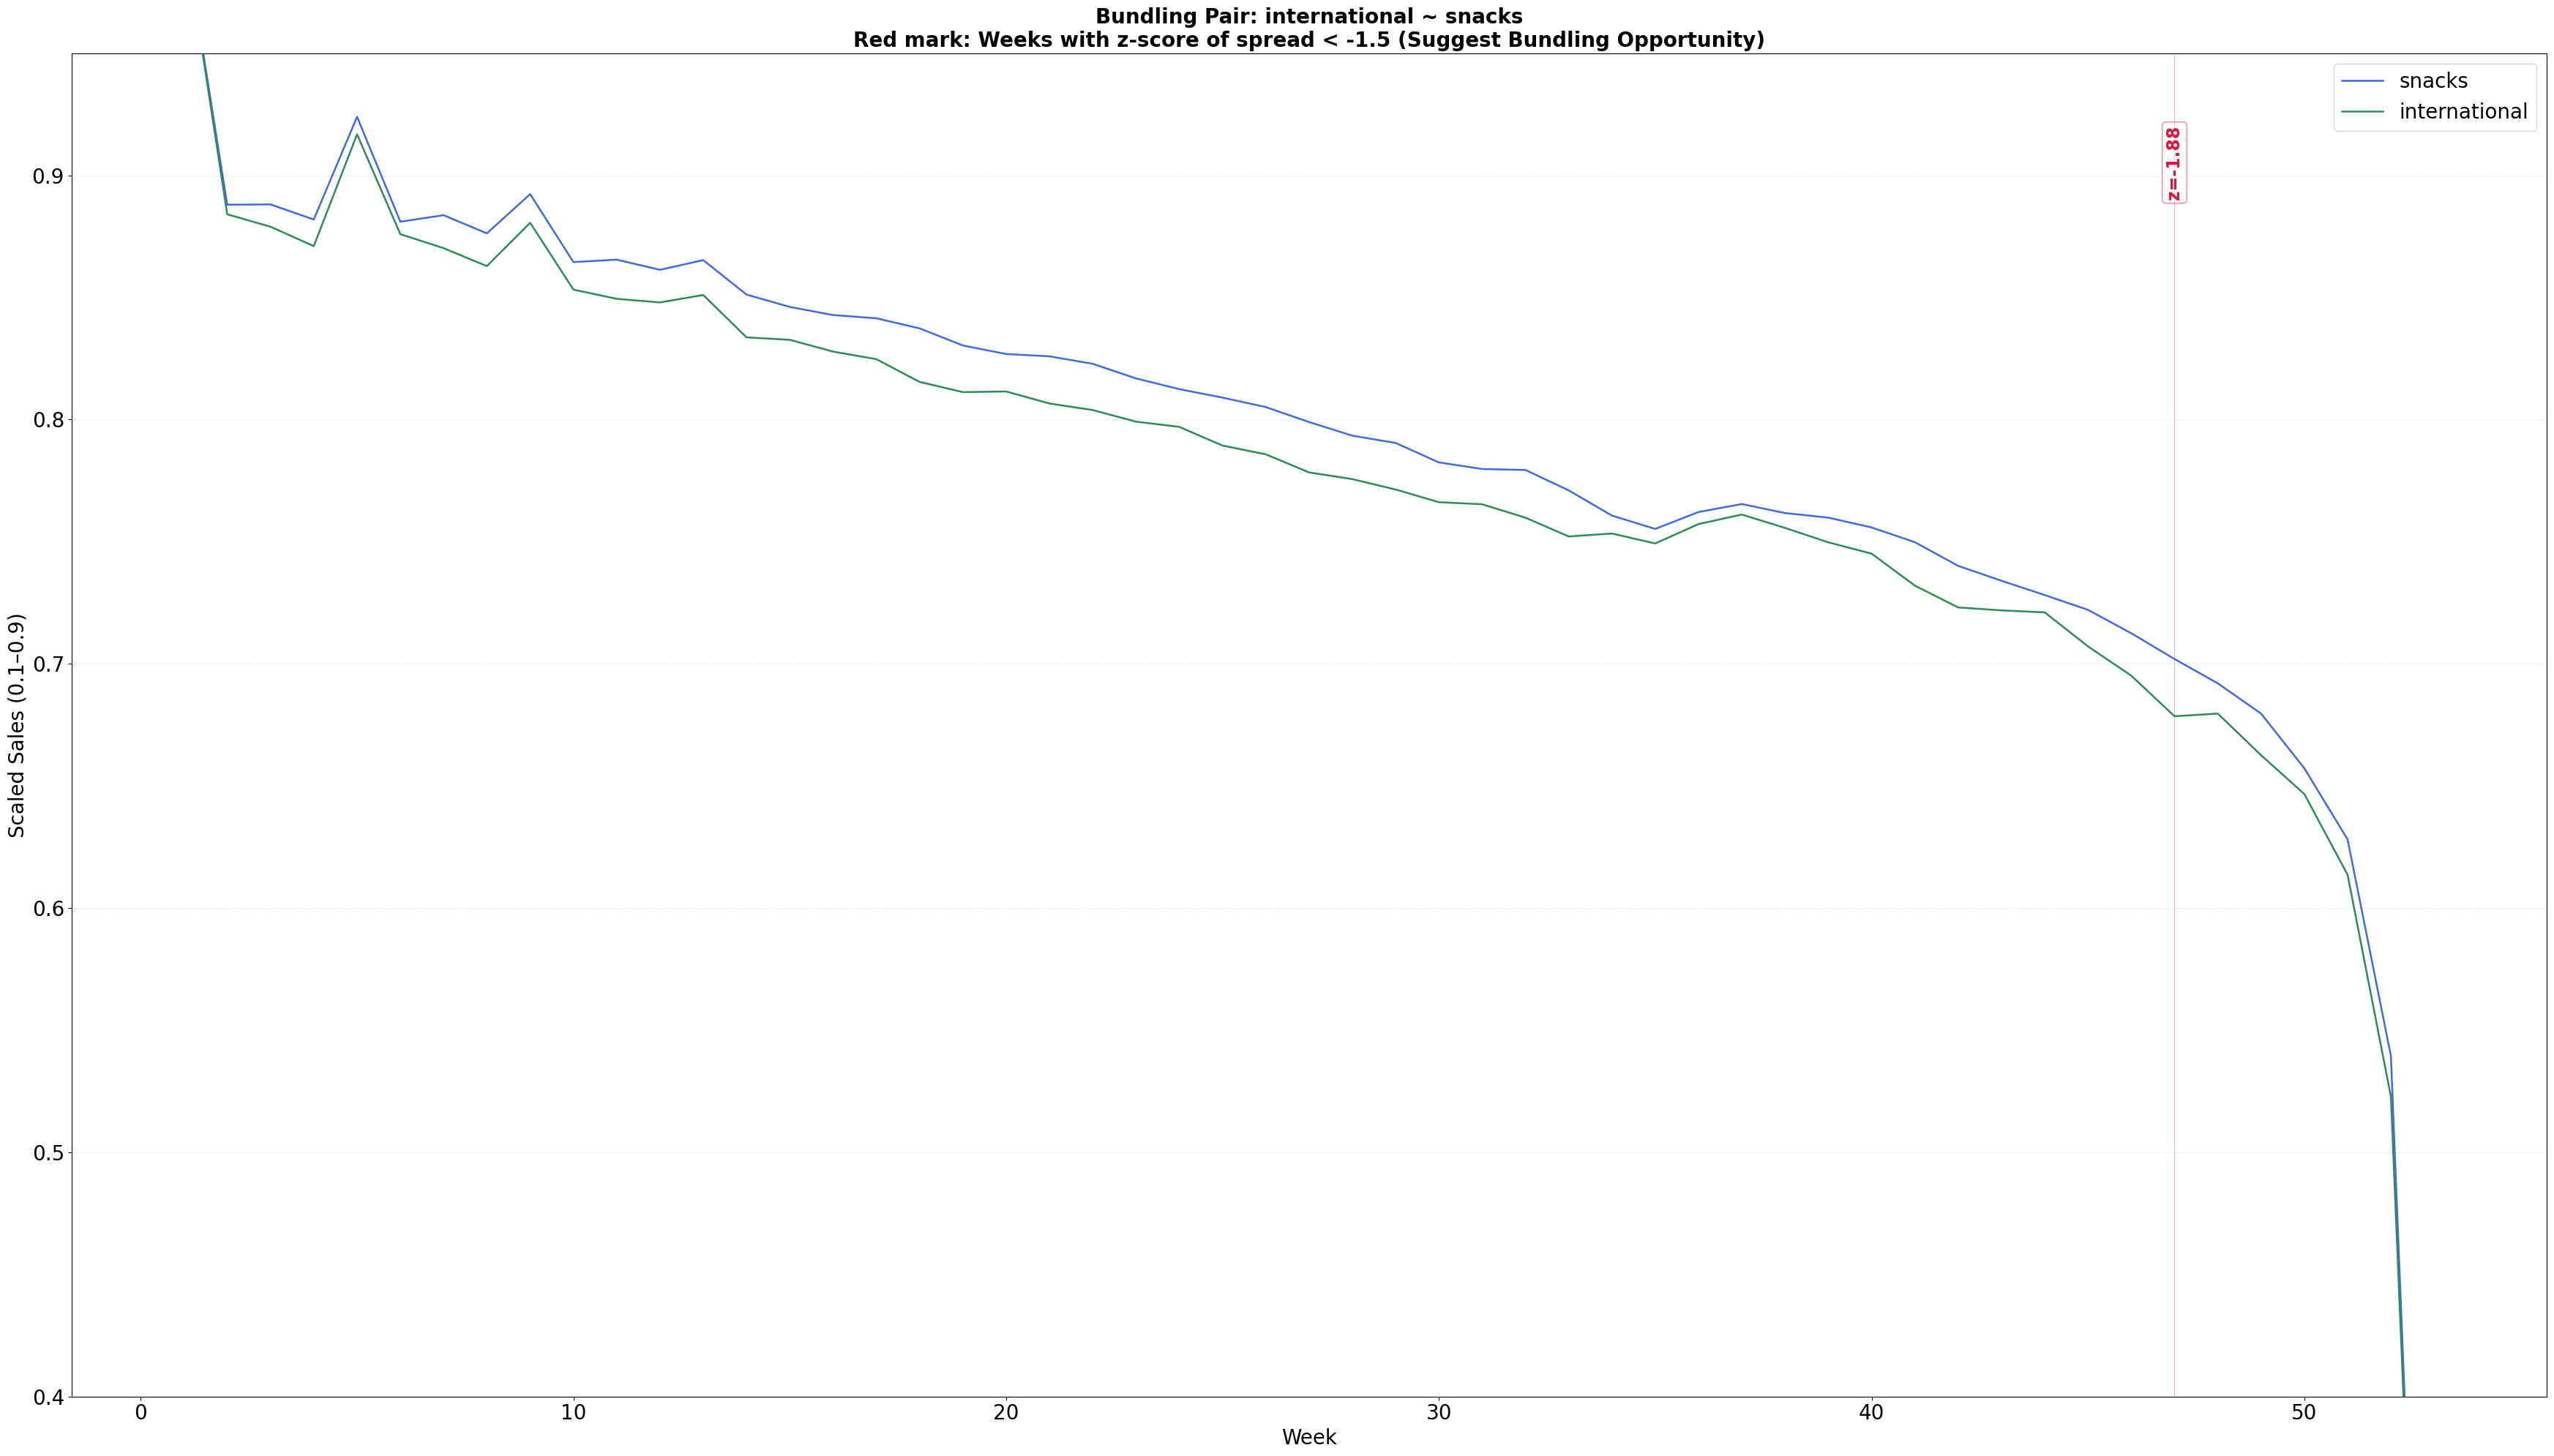

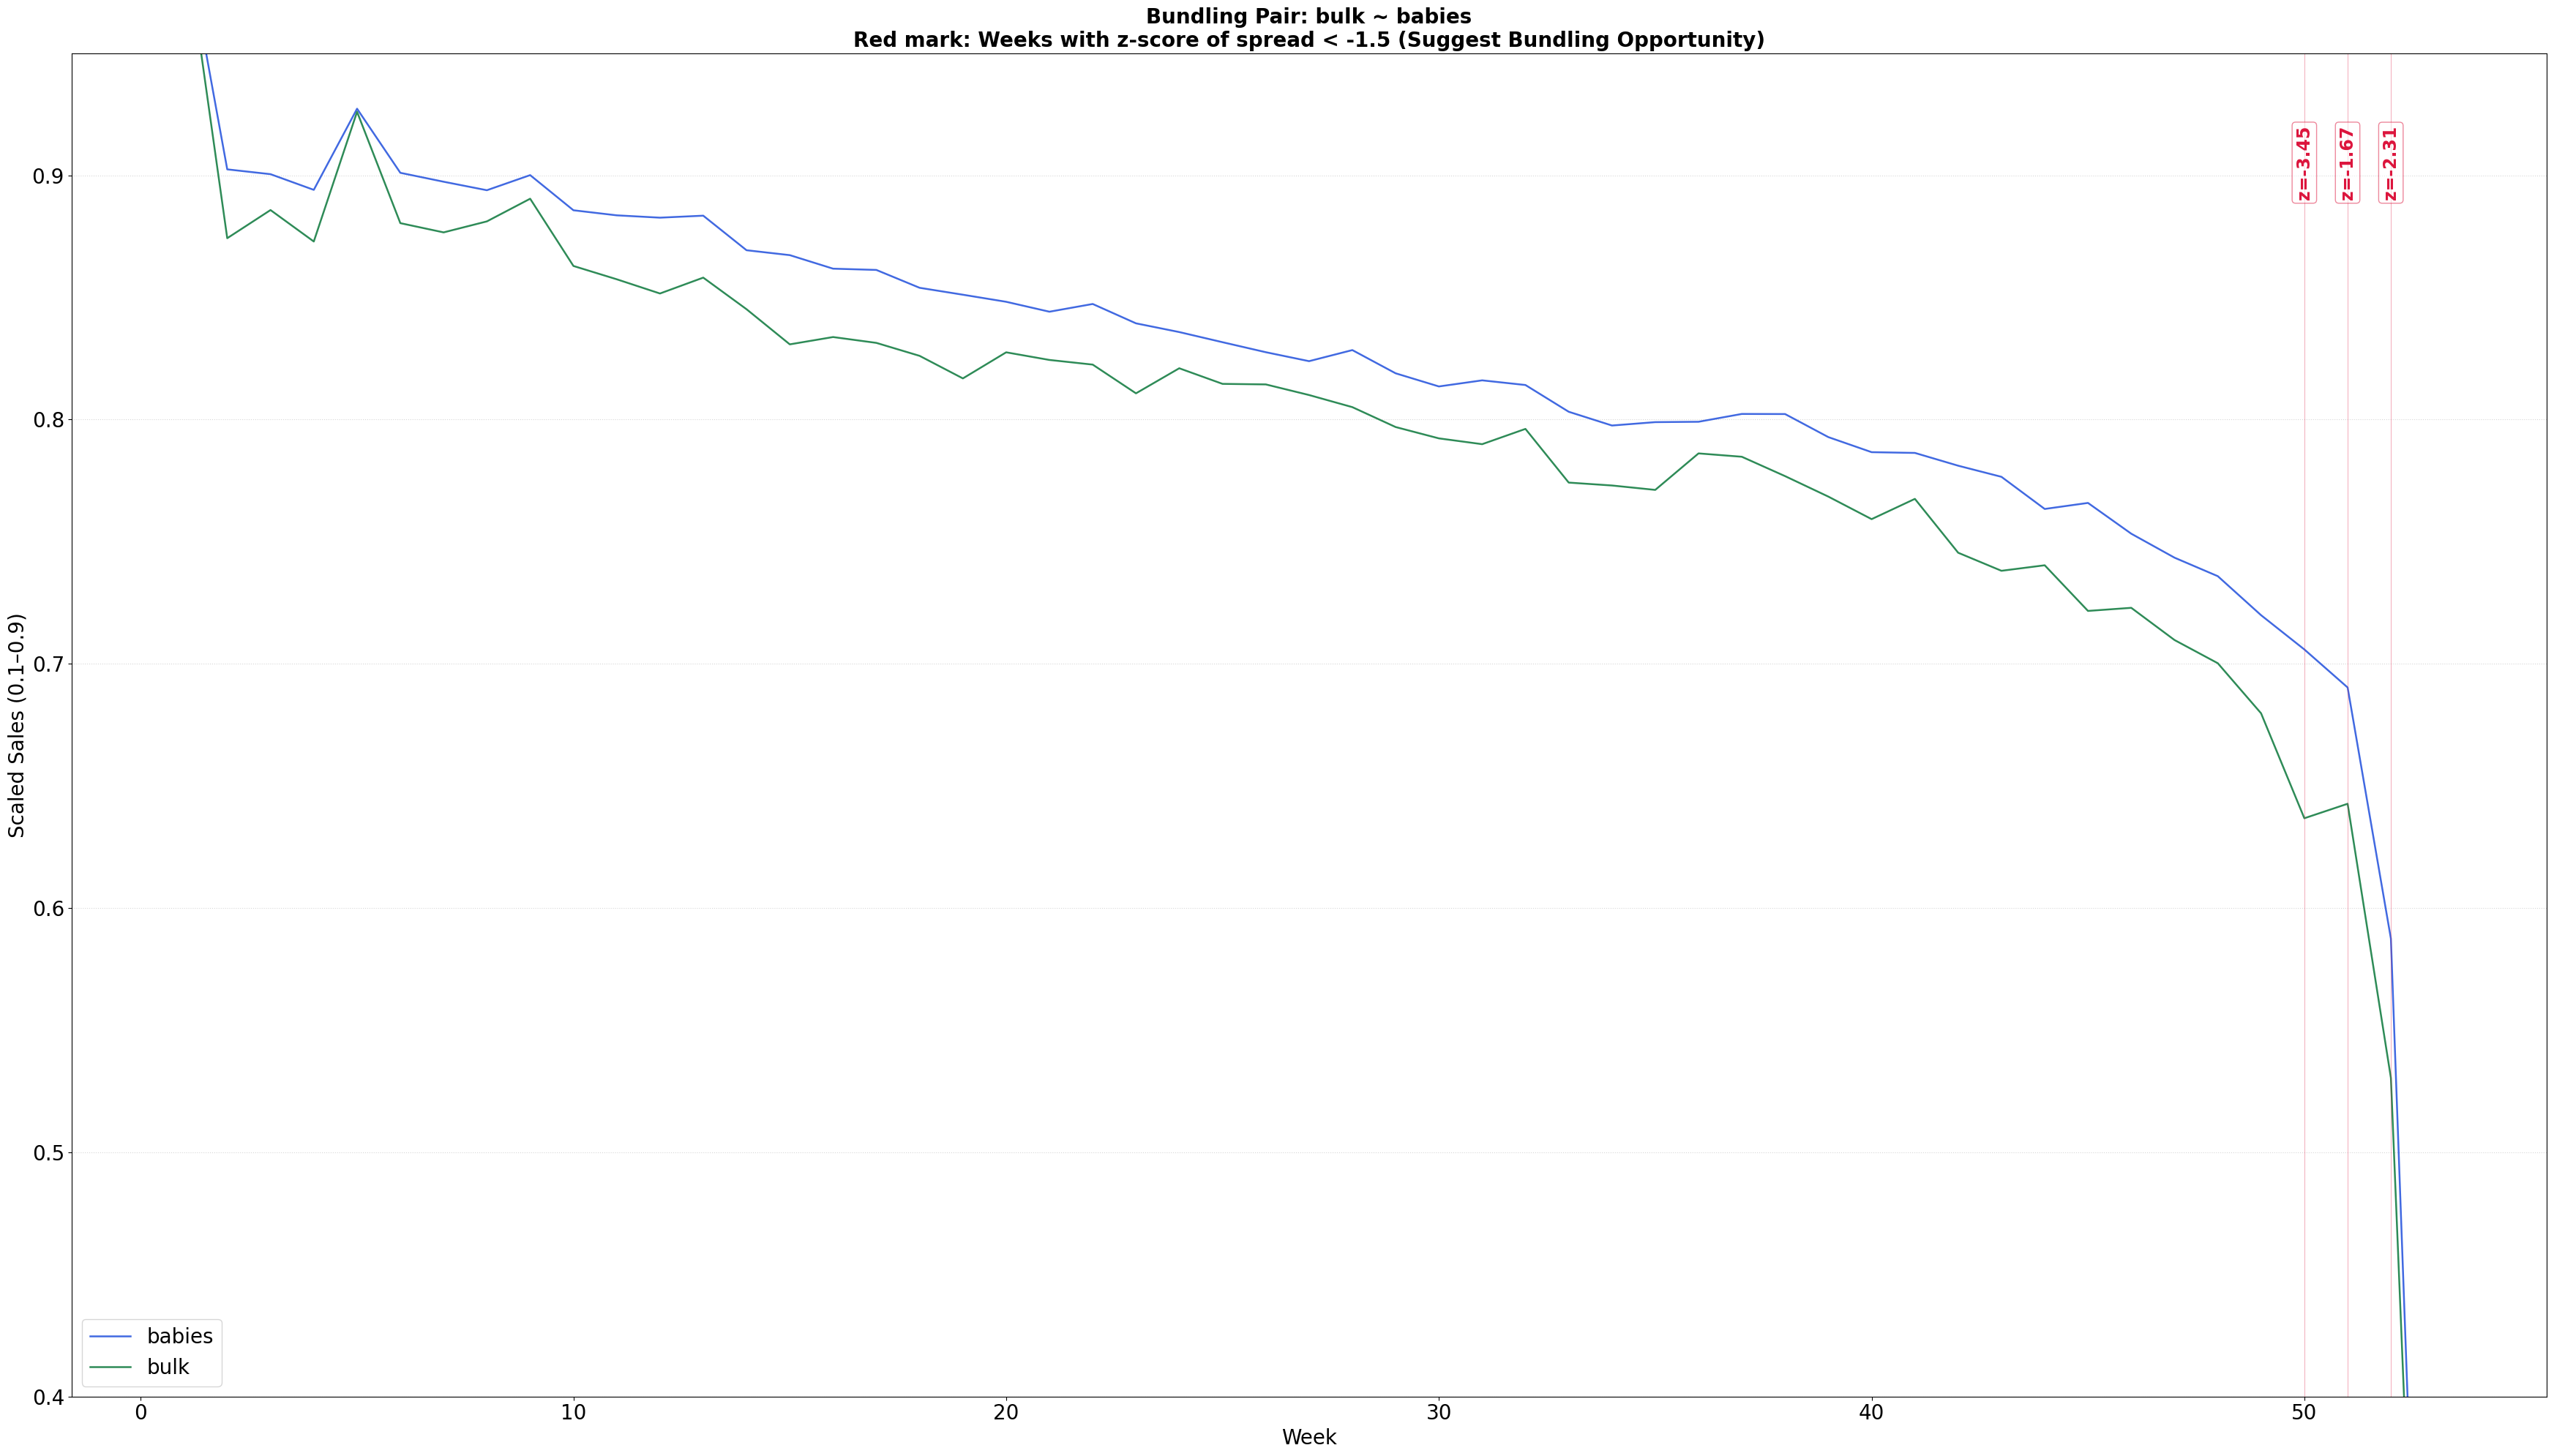

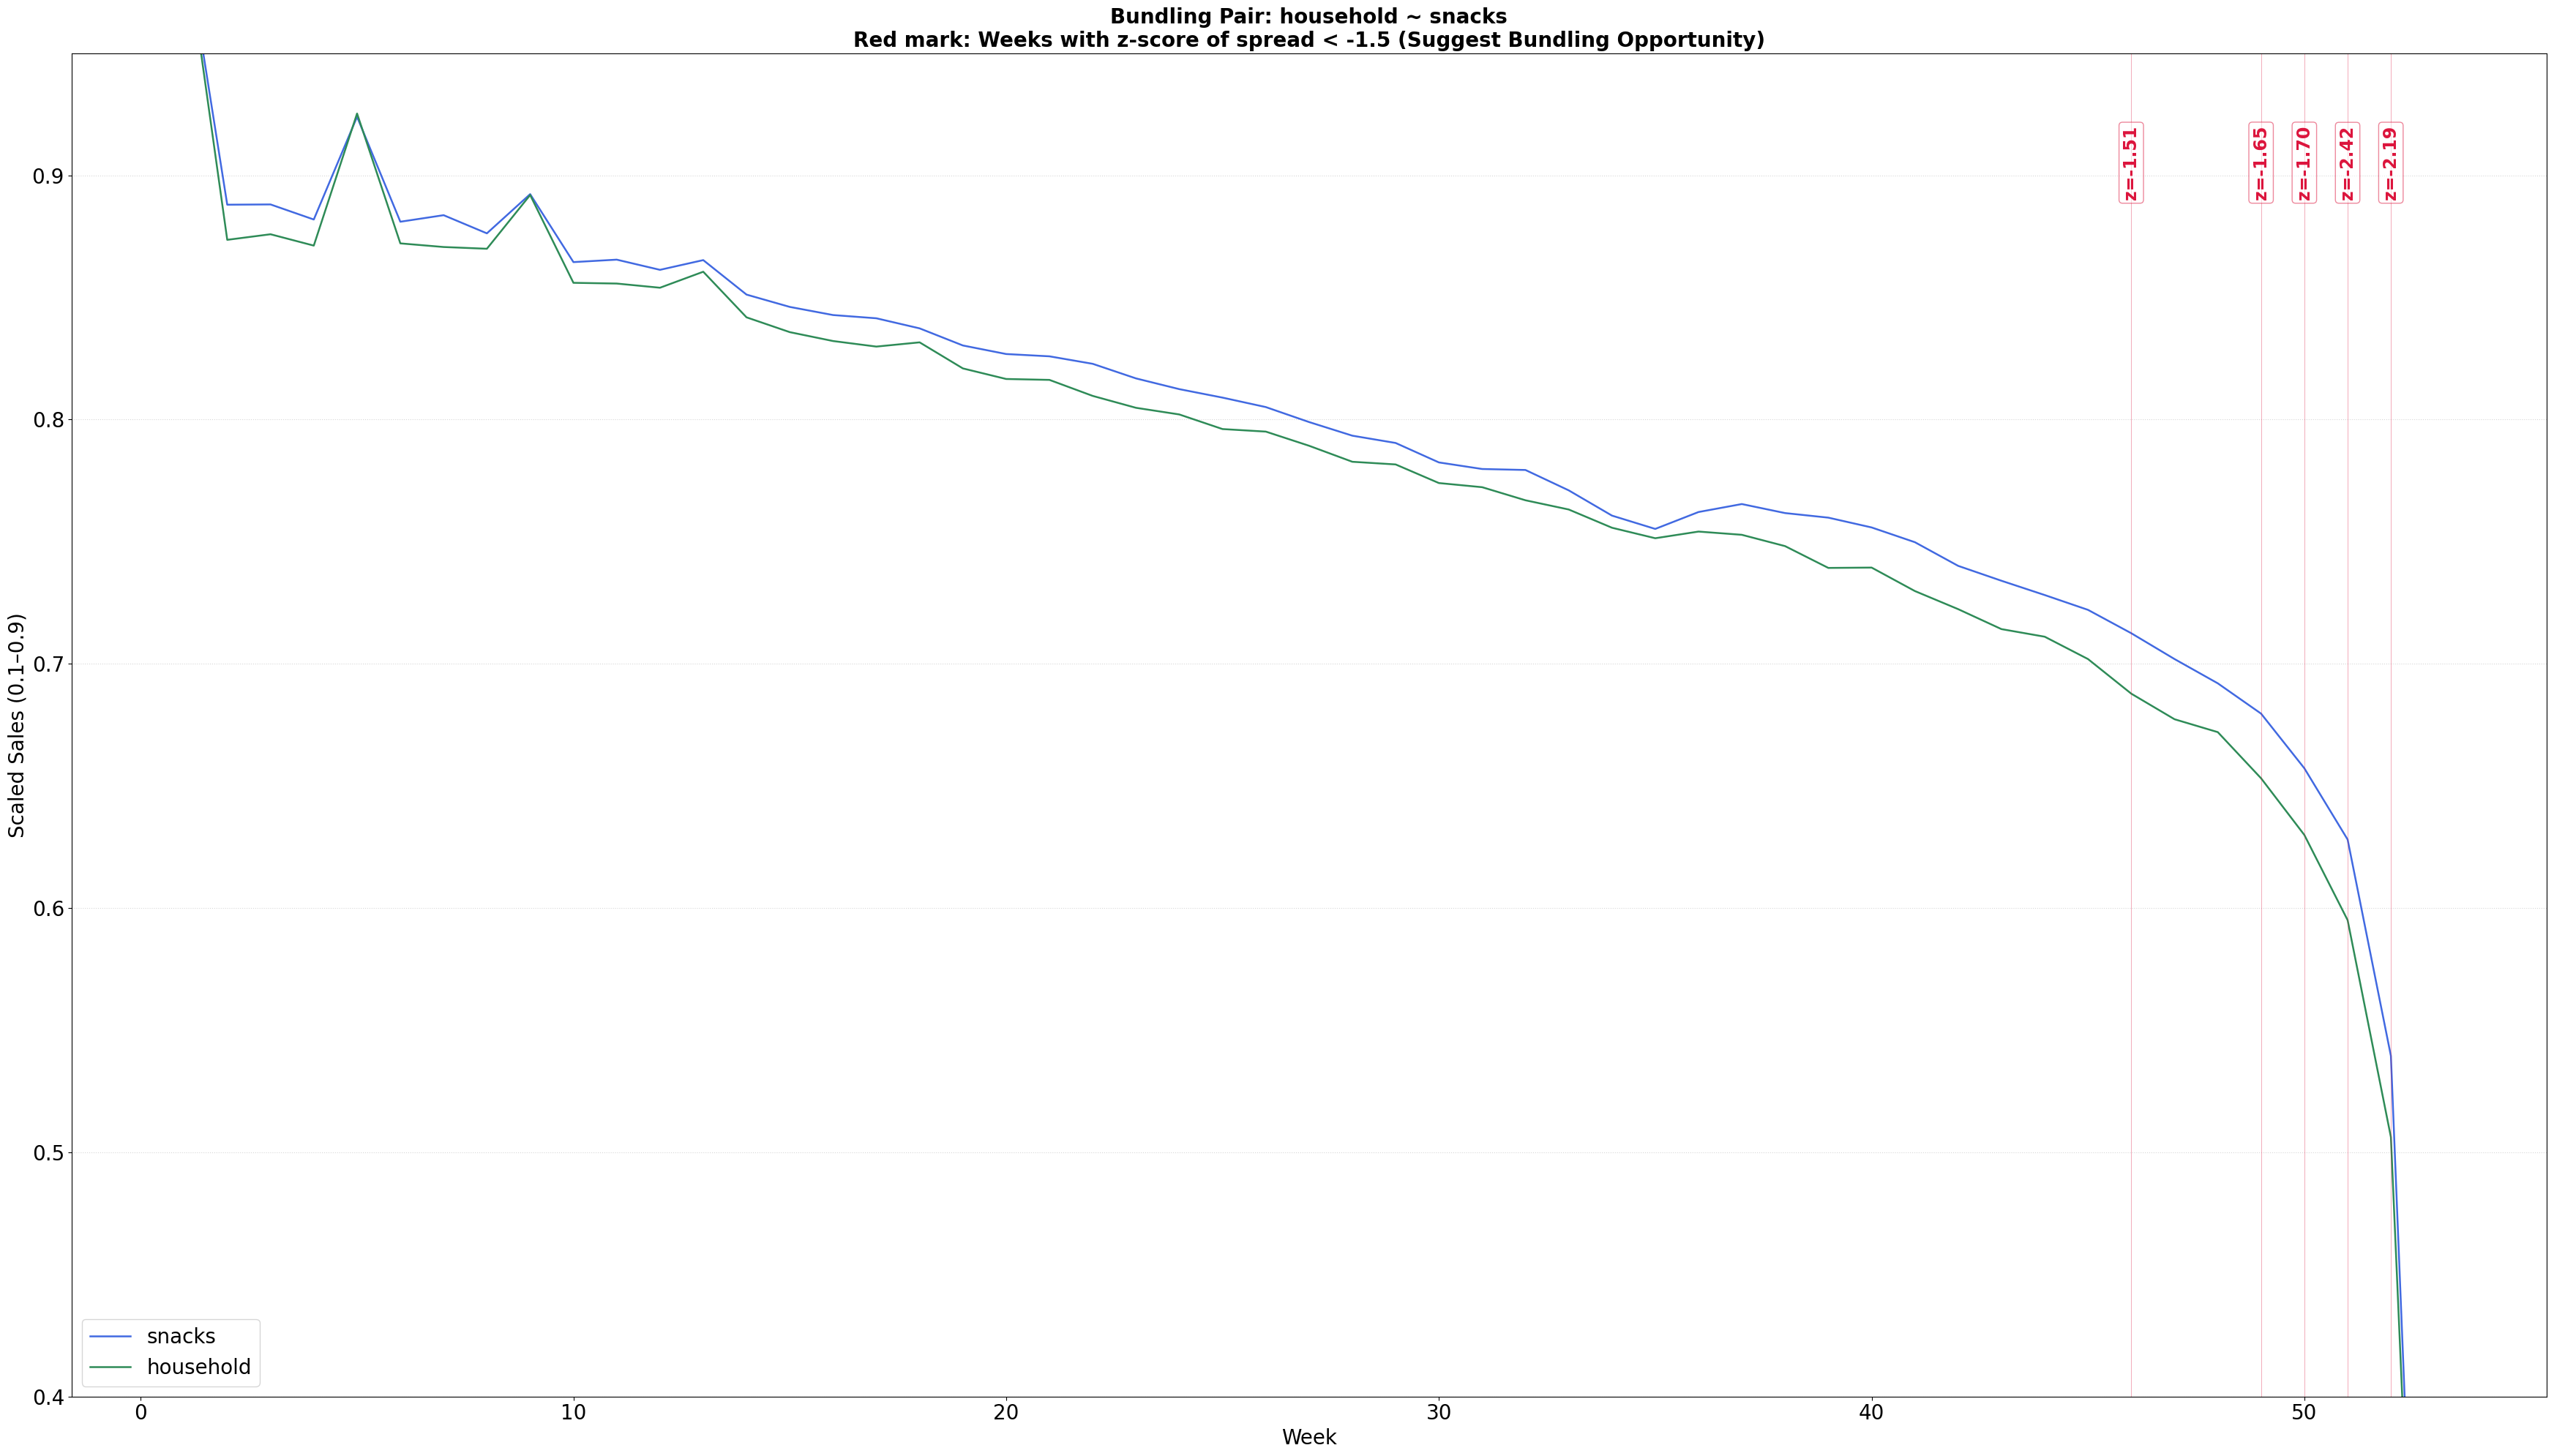

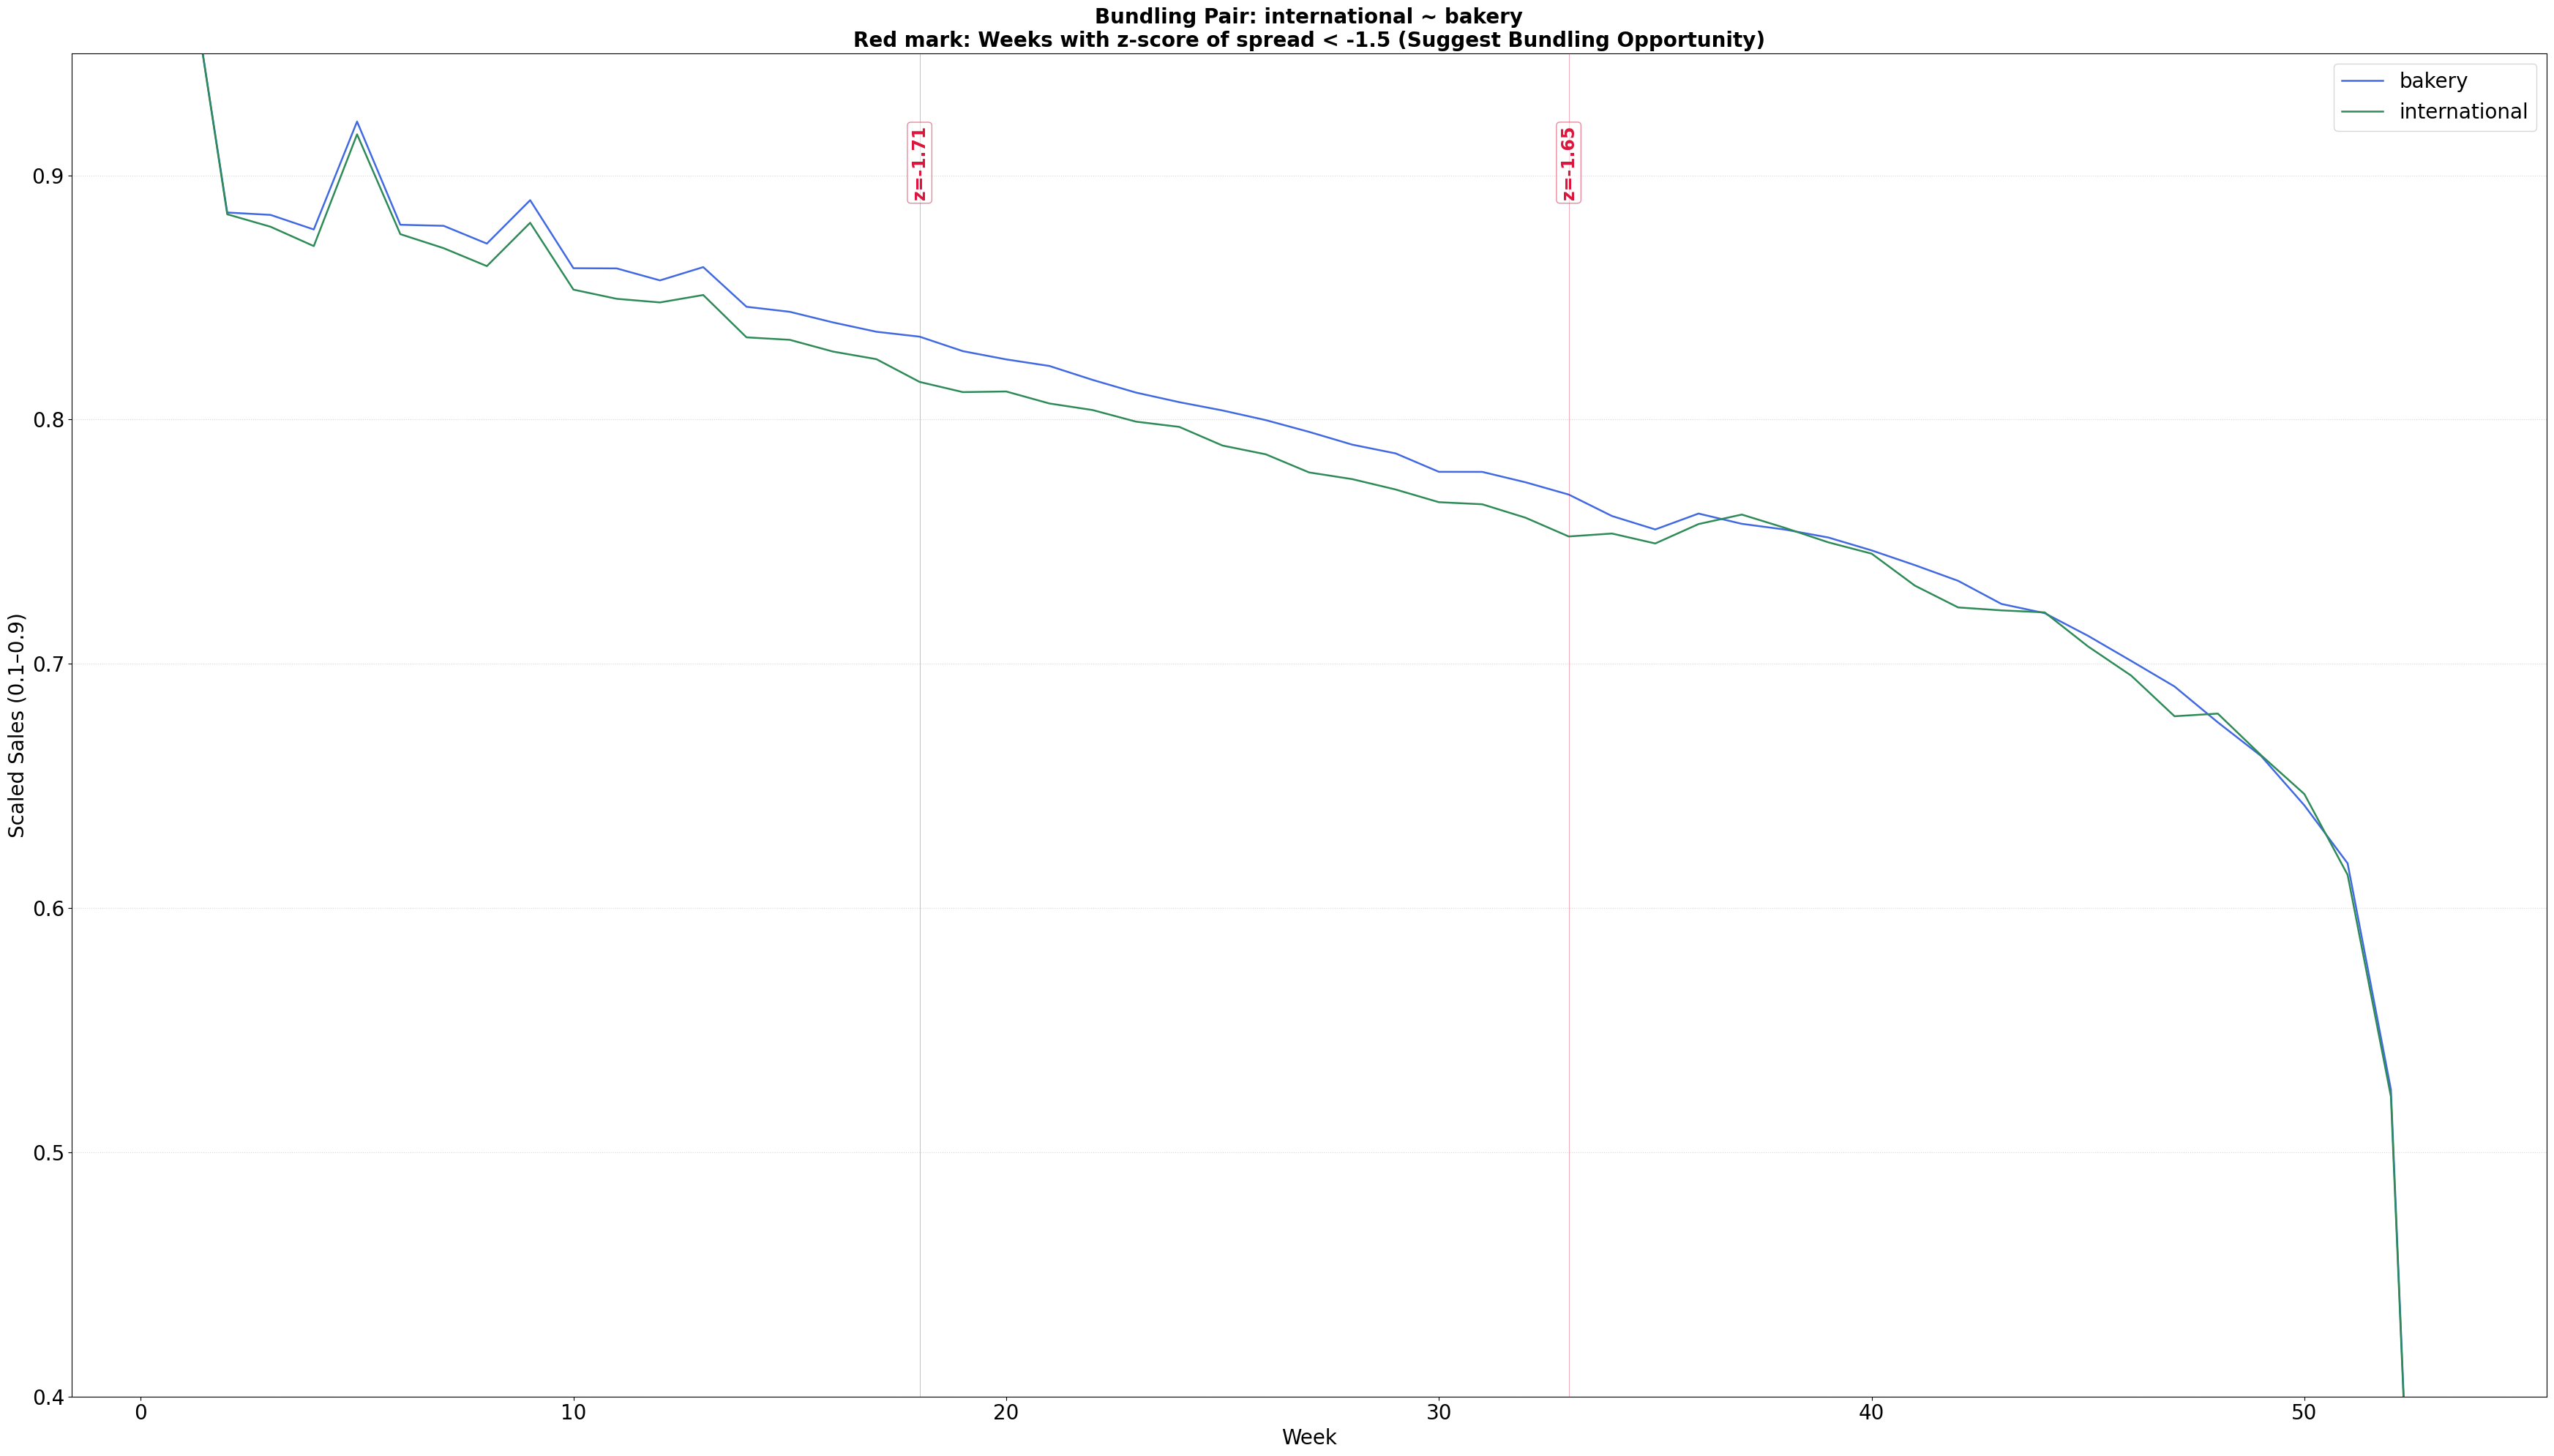

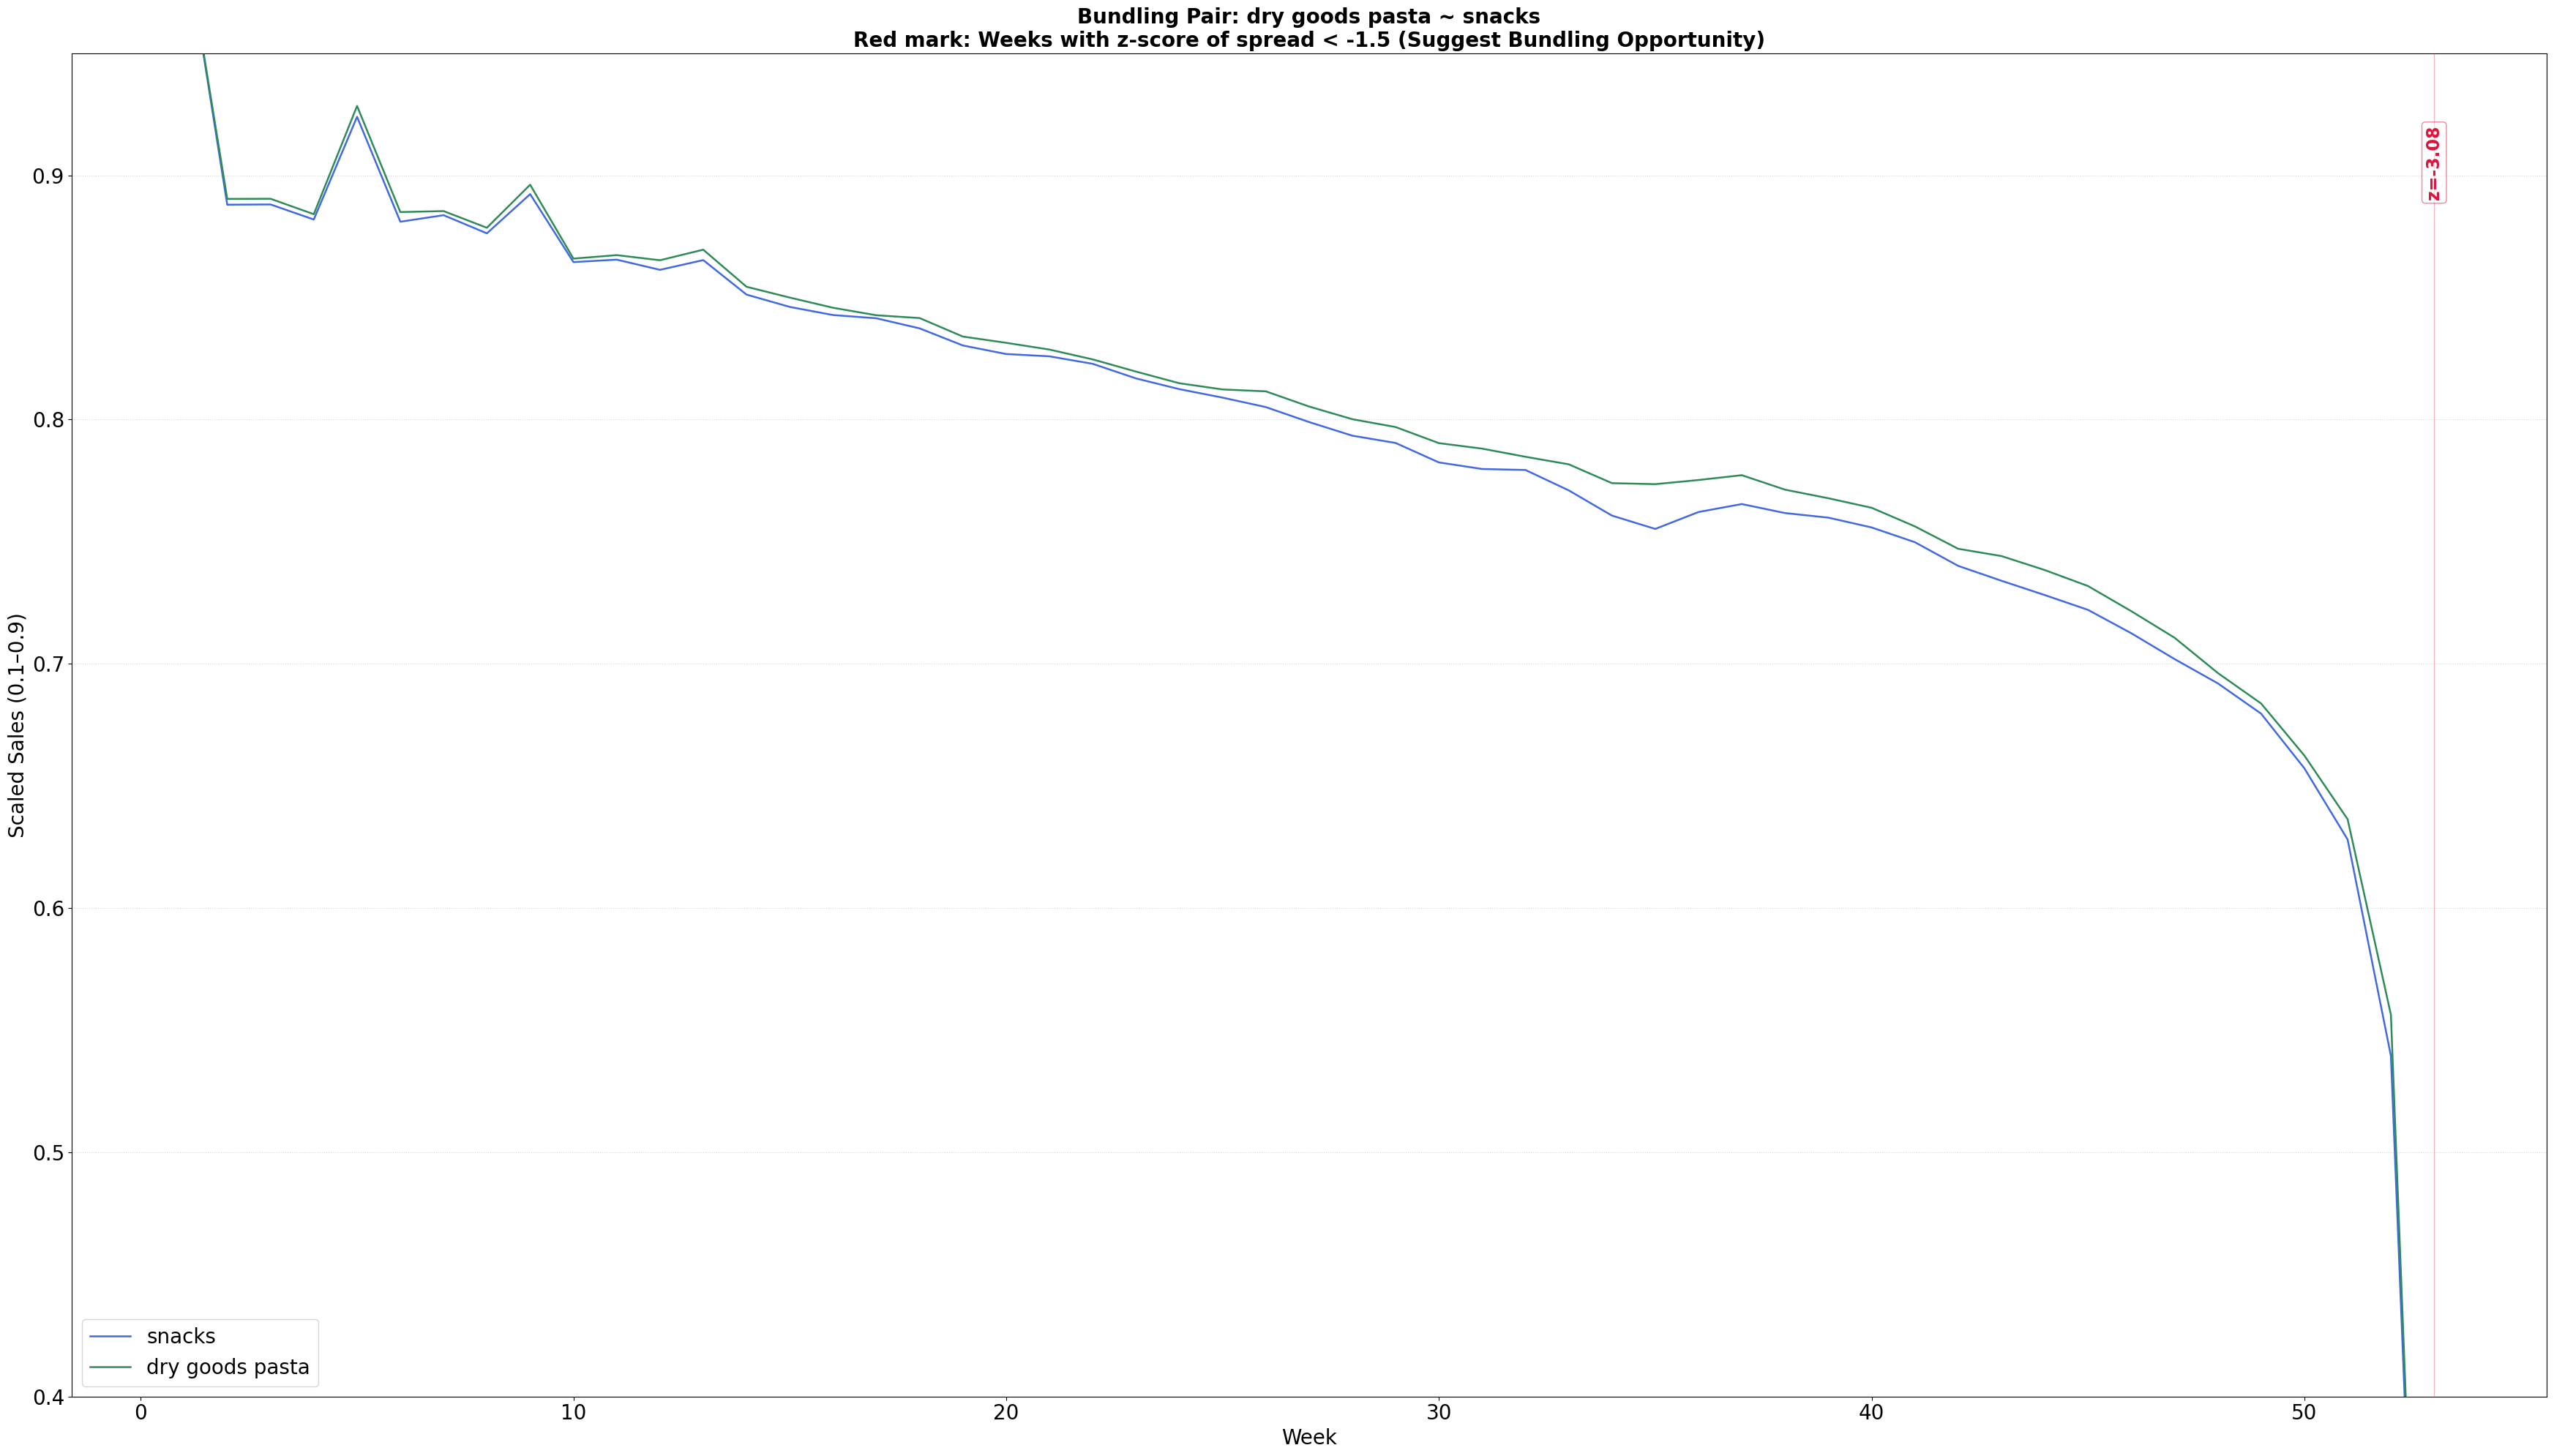

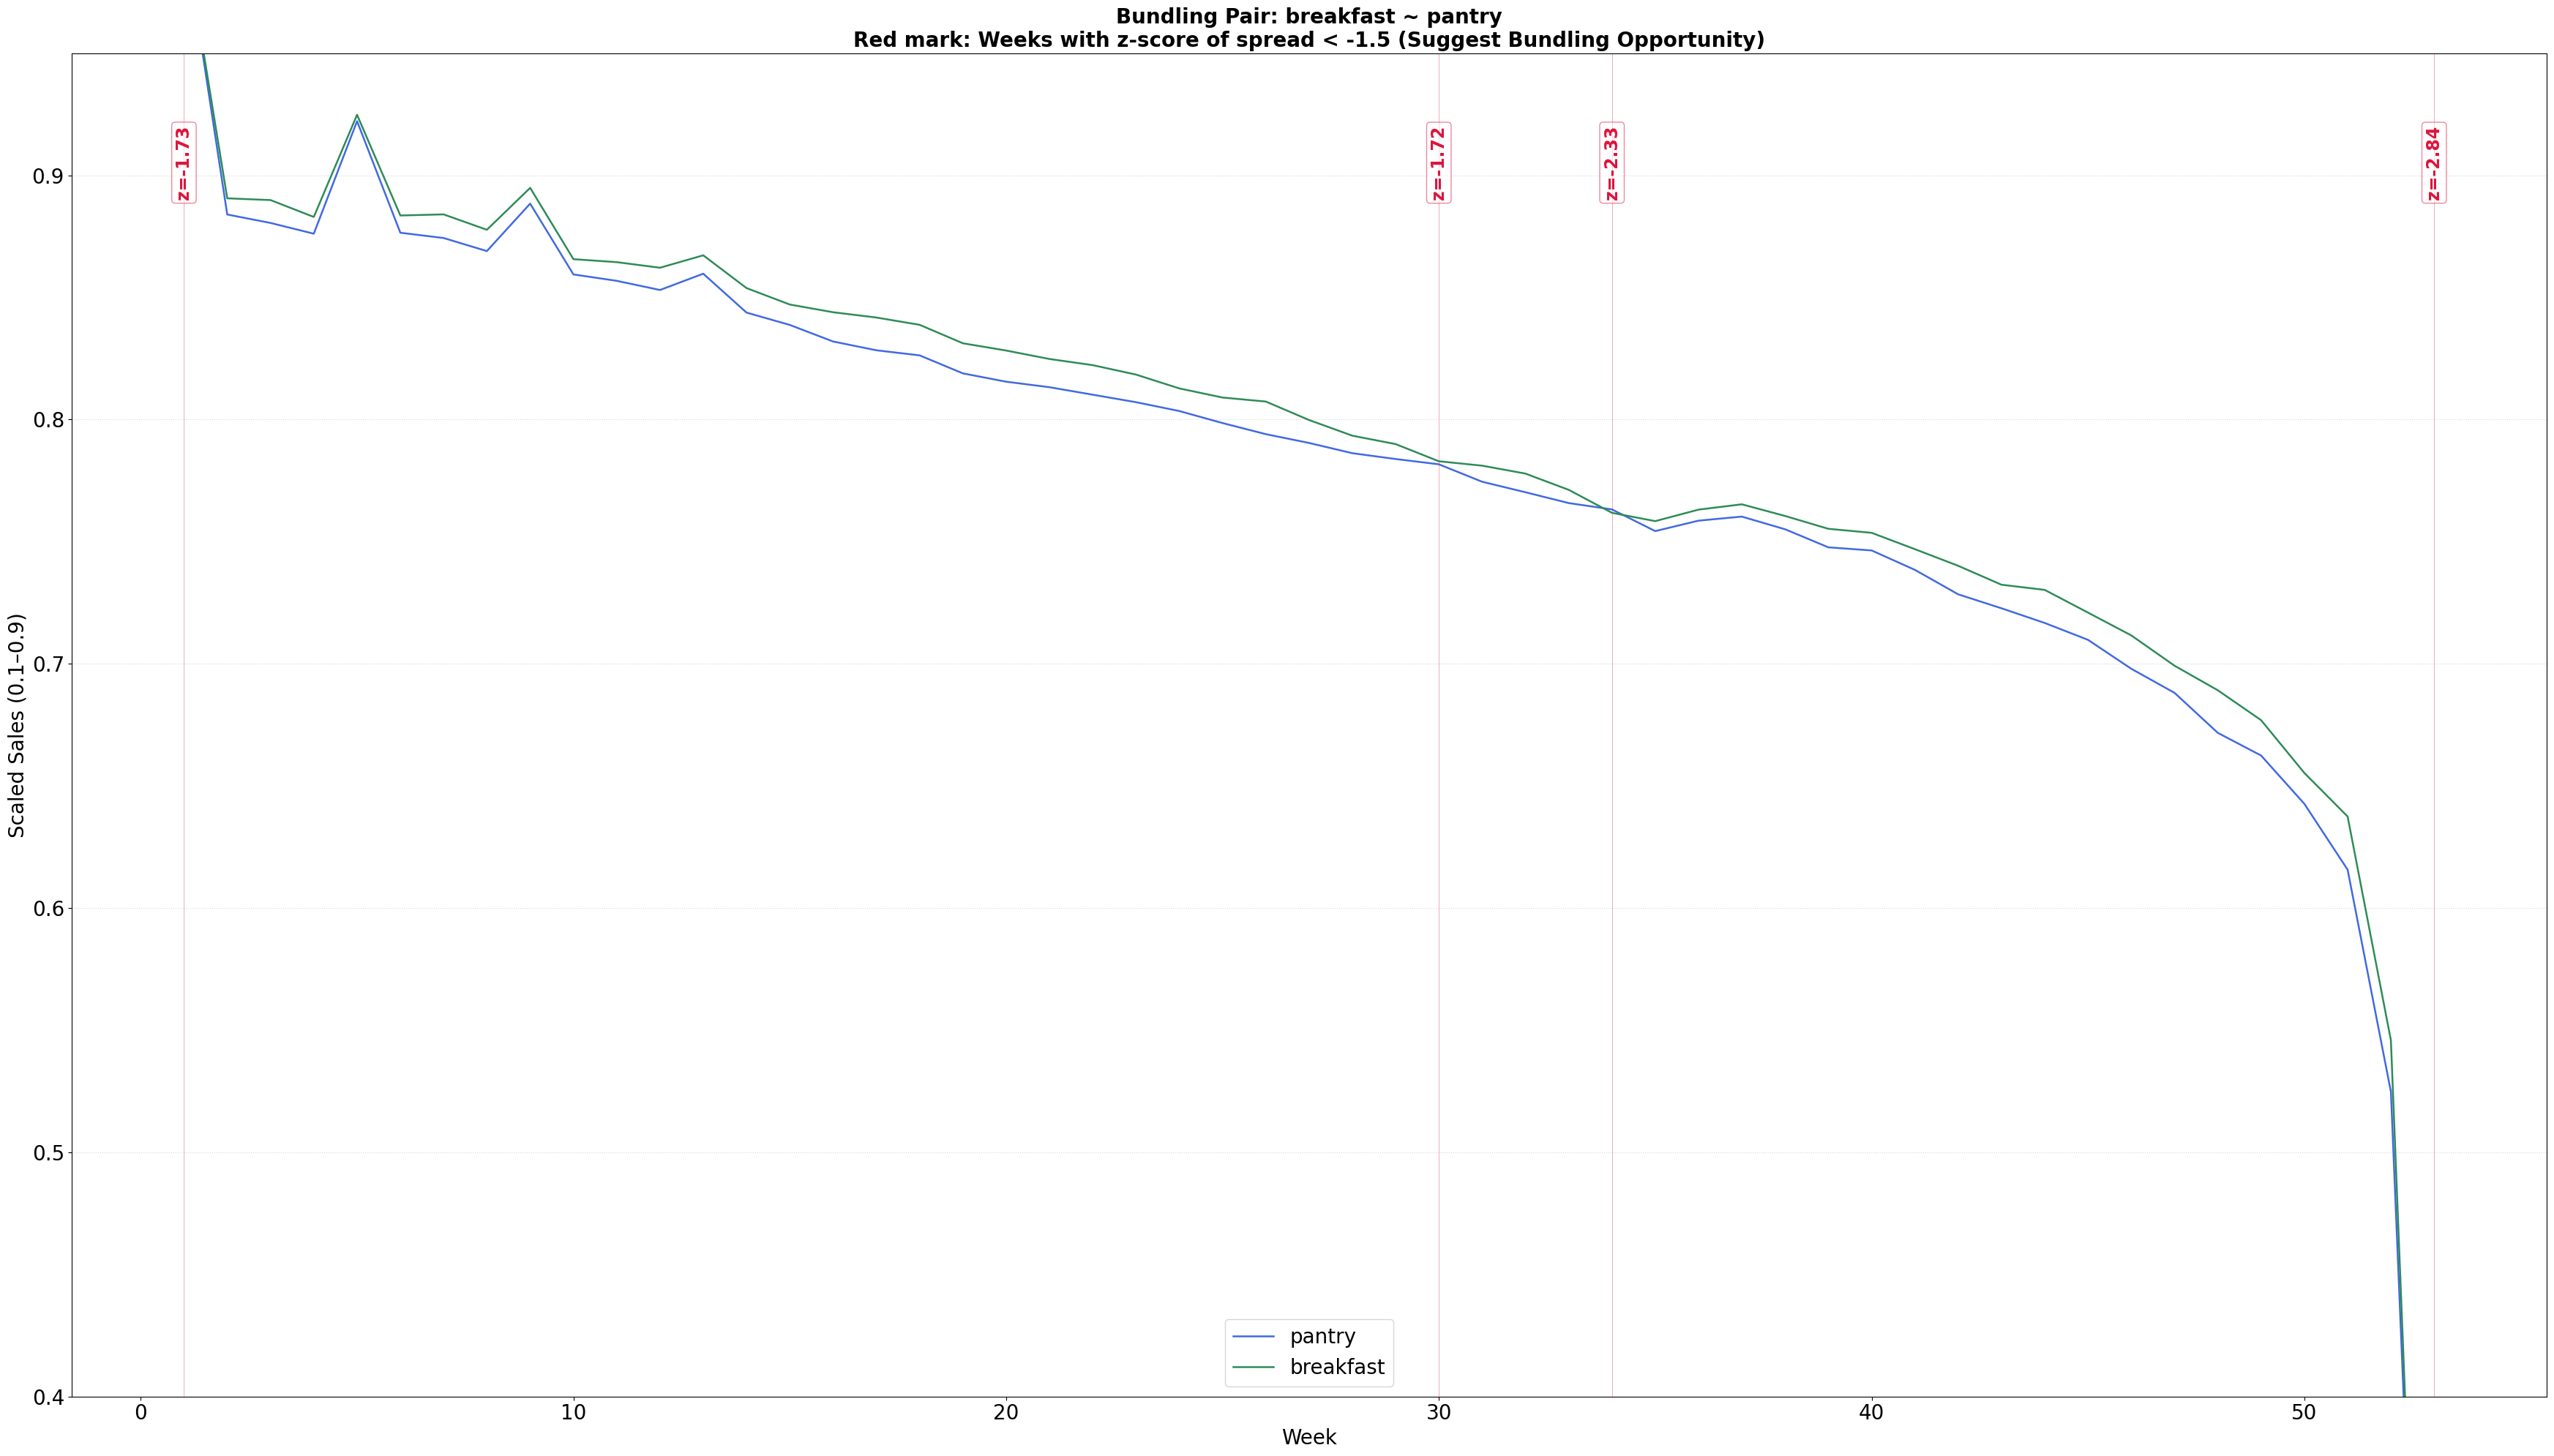

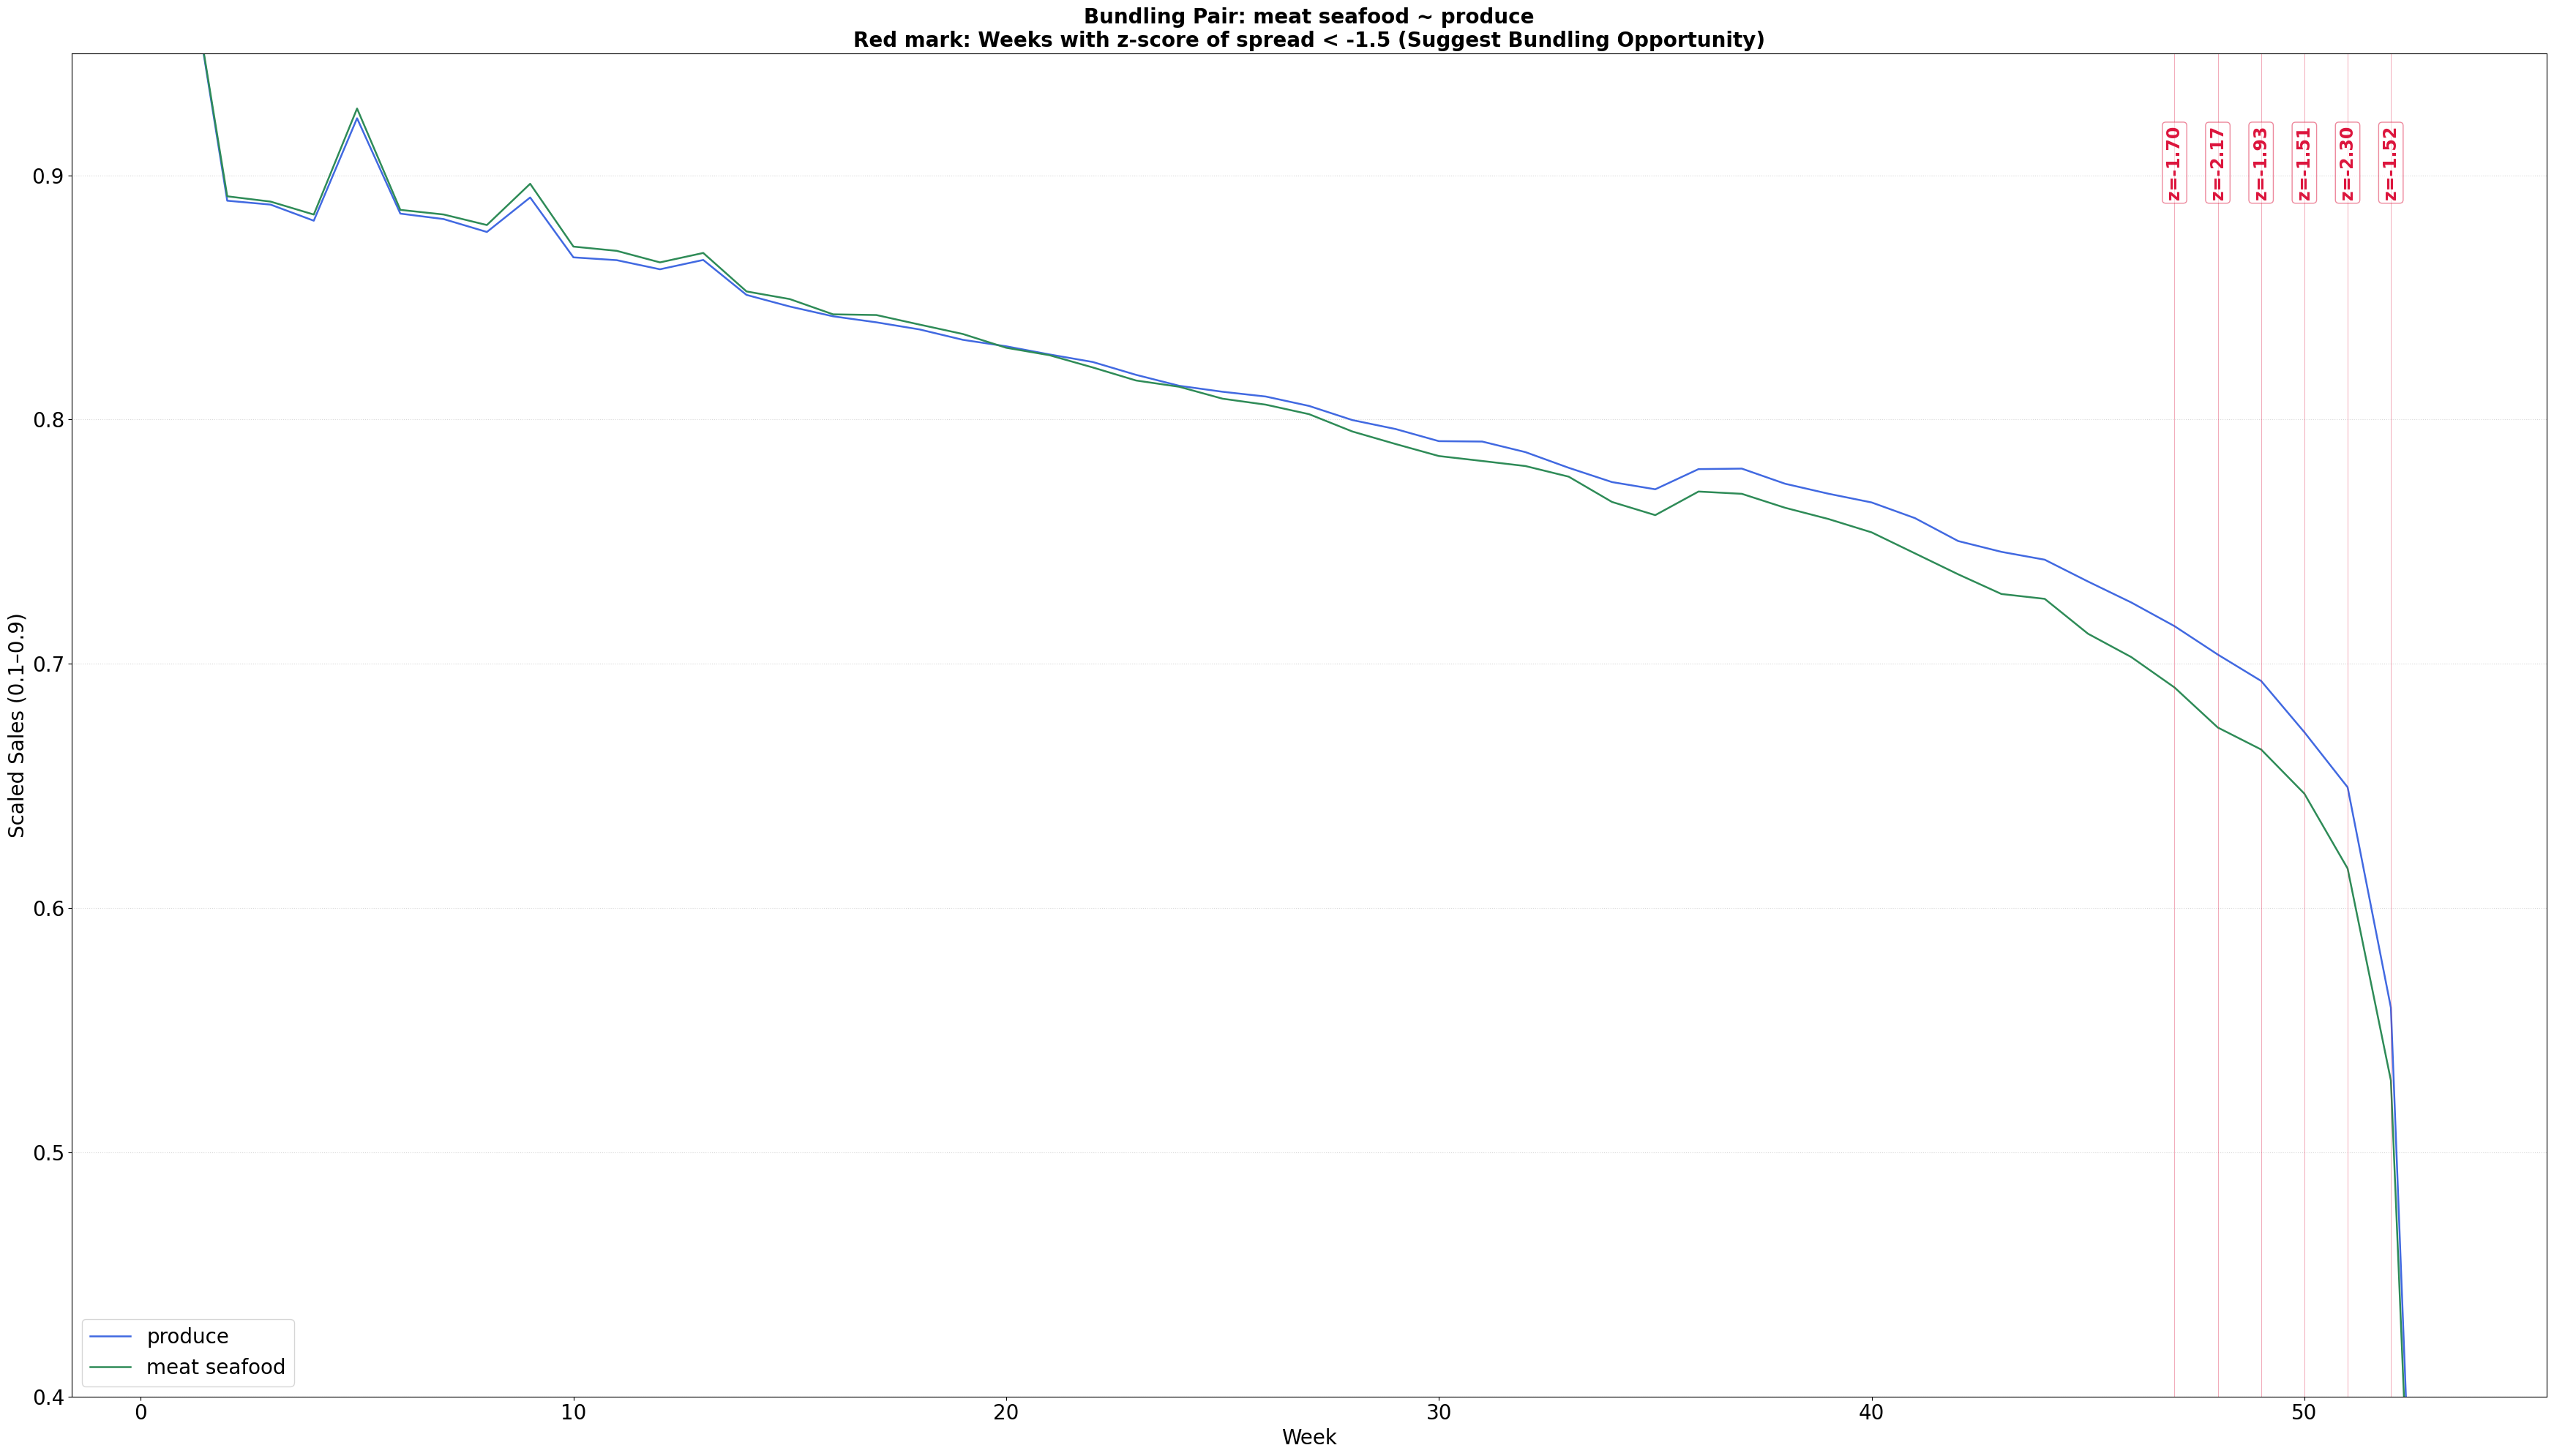

In [18]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

try:
    _ = weekly_sales_log.head()
    _ = sig_pairs.head()
except NameError:
    print("weekly_sales_log or sig_pairs not found. Please ensure the full notebook has been run.")
    print("Creating dummy data for demonstration purposes.")
    # Dummy data for demonstration if weekly_sales_log and sig_pairs are not defined
    np.random.seed(42)
    weeks = pd.RangeIndex(start=0, stop=100, name='Week')
    weekly_sales_log = pd.DataFrame(
        {
            'dept_A': np.log(np.random.rand(100) * 100 + 50 + np.arange(100) * 0.5),
            'dept_B': np.log(np.random.rand(100) * 100 + 60 + np.arange(100) * 0.6),
            'dept_C': np.log(np.random.rand(100) * 100 + 40 + np.arange(100) * 0.4),
            'dept_D': np.log(np.random.rand(100) * 100 + 70 + np.arange(100) * 0.7)
        },
        index=weeks
    )
    sig_pairs = pd.DataFrame({
        'dept_x': ['dept_A'],
        'dept_y': ['dept_B']
    })


for idx, row in sig_pairs.iterrows():
    indep = row['dept_x']
    dep = row['dept_y']

    # Regression and spread (same as your logic)
    X = sm.add_constant(weekly_sales_log[indep])
    y = weekly_sales_log[dep]
    model = sm.OLS(y, X).fit()
    spread = model.resid
    z_scores = zscore(spread)

    flagged_weeks = weekly_sales_log.index[z_scores < -1.5]
    flagged_zs = z_scores[z_scores < -1.5]

    # Improved MinMax scaling for distinct, close lines
    scaler = MinMaxScaler(feature_range=(0.1, 0.9999))
    data_scaled = pd.DataFrame(
        scaler.fit_transform(weekly_sales_log[[indep, dep]]),
        columns=[indep, dep], index=weekly_sales.index
    )

    # Adjusted figsize for a more balanced (taller and slightly less wide) look
    plt.figure(figsize=(35, 20)) # Current size from previous iteration
    plt.plot(data_scaled.index, data_scaled[indep], label=indep, linewidth=1.8, color='royalblue')
    plt.plot(data_scaled.index, data_scaled[dep], label=dep, linewidth=1.8, color='seagreen')

    # Enlarge marker size and visually space annotation
    for i, (week, z) in enumerate(zip(flagged_weeks, flagged_zs)):
        plt.axvline(week, color='crimson', linestyle='-', alpha=0.5, linewidth=0.5)
        # Removed the plt.scatter line to remove the red circular dots
        plt.text(week, 0.89, f'z={z:.2f}', color='crimson', fontsize=17, rotation=90,
                         ha='center', va='bottom', fontweight='bold', bbox=dict(facecolor='white', edgecolor='crimson', boxstyle='round,pad=0.2', alpha=0.5))

    # Expanded Y-axis for breathing room
    plt.ylim(0.4, 0.95)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Week", fontsize=20)
    plt.ylabel("Scaled Sales (0.1–0.9)", fontsize=20)
    plt.title(f"Bundling Pair: {dep} ~ {indep}\nRed mark: Weeks with z-score of spread < -1.5 (Suggest Bundling Opportunity)",
              fontsize=20, fontweight='semibold')
    plt.legend(fontsize=20)
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

Objective 4: Simulate Revenue Uplift from Bundling Strategy
--
Convert log sales back to original units using expm1(log1p(x)).\
Simulate a 5% uplift in total basket value during recommended weeks.\
Convert uplifted values back to log1p scale for statistical comparison.\
Checks if simulated bundle boosts revenue significantly (statistical significance of uplift).\


For each significant pair:\
Estimate OLS\
Simulate bundling using analyze_bundling_impact\

Print:\
Which weeks bundling is recommended\
Whether simulated uplift is statistically significant\

Interpretation Notes:\
Bundling signals are based on price-volume dynamics (via cointegration and z-score spread).\
Simulated 5% uplift checks if bundling leads to meaningful gain.\
Statistical tests (t-test) ensure any uplift isn’t by chance.



In [19]:
from scipy.stats import ttest_rel

ts_df = weekly_sales_log.copy()

# Ensure datetime index (This part is retained as it is)
if not isinstance(ts_df.index, pd.DatetimeIndex):
    try:
        # If it's truly a week number that needs mapping to a date, that logic would be needed here.
        # For simple indexing, it might be fine as is.
        # The original code's `pd.to_datetime(ts_df.index)` might fail if index is just int.
        # Let's keep it as is, assuming it handles an appropriate format if needed.
        ts_df.index = pd.to_datetime(ts_df.index)
        print("Converted ts_df index to DatetimeIndex.")
    except Exception as e:
        print(f"Error converting ts_df index to DatetimeIndex: {e}. Proceeding without DatetimeIndex.")


# Function to estimate OLS (retained as is)
def estimate_ols(ts, x_col, y_col):
    X = ts[[x_col]]
    y = ts[y_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

# Core analysis function - CORRECTED
def analyze_bundling_impact(ts, independent_var, dependent_var, ols_results,
                            lookback_window=30, z_score_threshold=-1, assumed_uplift_pct=0.05):

    df = ts[[independent_var, dependent_var]].copy()

    # Optional filter: Remove rows with 0 or NaN sales
    # IMPORTANT: Since ts are already log1p, original 0s are still 0 in log1p.
    # So (df[independent_var] > 0) & (df[dependent_var] > 0) effectively removes weeks where sales were 0.
    df = df[(df[independent_var] > 0) & (df[dependent_var] > 0)].dropna()

    alpha = ols_results.params['const']
    beta = ols_results.params[independent_var]

    # Spread and z-score (retained as is)
    df['spread'] = df[dependent_var] - (alpha + beta * df[independent_var])
    df['spread_mean'] = df['spread'].rolling(window=lookback_window, min_periods=lookback_window).mean()
    df['spread_std'] = df['spread'].rolling(window=lookback_window, min_periods=lookback_window).std()
    df['z_score'] = (df['spread'] - df['spread_mean']) / df['spread_std']
    df['recommend_bundle'] = (df['z_score'] < z_score_threshold).fillna(False)

    # Debug (remove if needed)
    # print(df[['spread', 'spread_std', 'z_score']].tail())

    # Positional indices (retained as is, though ts.index might need to be global_week for precise mapping)
    alert_timestamps = df[df['recommend_bundle']].index
    # Assuming ts.index contains the 'global_week' values that match df.index
    # If ts.index is DatetimeIndex and df.index is also DatetimeIndex then this works
    # If ts.index is integer global_week, ensure df.index is also integer global_week.
    # A safer way to get integer positions might be df.index.get_indexer(alert_timestamps)
    timestamp_to_position = {ts_val: i for i, ts_val in enumerate(ts.index)} # Using ts (full original log sales df) for index
    bundle_weeks = [timestamp_to_position[ts_val] for ts_val in alert_timestamps if ts_val in timestamp_to_position]

    # --- CORRECTED REVENUE UPLIFT SIMULATION ---
    # Convert log-transformed sales back to original units (expm1(log1p(x)) = x)
    original_sales_independent = np.expm1(df[independent_var])
    original_sales_dependent = np.expm1(df[dependent_var])

    # Calculate the 'base_basket' (sum of sales) in original units
    df['base_basket_original_units'] = original_sales_independent + original_sales_dependent
    
    # Create the 'bundle_basket' in original units, which will be modified for uplift
    df['bundle_basket_original_simulated_units'] = df['base_basket_original_units'].copy()

    # Apply the assumed uplift percentage directly to the original units for recommended bundles
    df.loc[df['recommend_bundle'], 'bundle_basket_original_simulated_units'] *= (1 + assumed_uplift_pct)

    # Now, convert both the base_basket and the simulated bundle_basket back to log1p scale
    # for consistency with the paired t-test on log data.
    # This ensures we are comparing log(1+original_sum) with log(1+uplifted_original_sum)
    df['base_basket'] = np.log1p(df['base_basket_original_units'])
    df['bundle_basket'] = np.log1p(df['bundle_basket_original_simulated_units'])
    # --------------------------------------------

    # Prepare data for paired t-test
    base = df['base_basket'].dropna()
    bundle = df['bundle_basket'].dropna()
    
    # Ensure alignment by common index
    common_index = base.index.intersection(bundle.index)
    base_aligned = base.loc[common_index]
    bundle_aligned = bundle.loc[common_index]

    t_stat, p_value = np.nan, np.nan
    if len(base_aligned) > 1: # t-test requires at least 2 observations
        try:
            t_stat, p_value = ttest_rel(bundle_aligned, base_aligned)
        except ValueError as e:
            print(f"  Warning: Could not perform t-test for {dependent_var} ~ {independent_var} due to: {e}")

    return {
        'pair': f"{independent_var} ~ {dependent_var}",
        'bundle_weeks': bundle_weeks,
        'simulated_t_stat': t_stat,
        'simulated_p_value': p_value,
        'analysis_df': df
    }

# Main loop (retained as is, assuming sig_pairs structure with 'dept_x' and 'dept_y')
print("--- Analyzing Bundling Opportunities and Simulated Impact for Cointegrated Pairs ---")
print("-" * 70)

all_impact_results = []

lookback_window_for_analysis = 30
z_score_threshold_for_analysis = -1
assumed_uplift_percentage = 0.05

for index, row in sig_pairs.iterrows():
    dept_x = row['dept_x']
    dept_y = row['dept_y']
    independent_var = dept_x # Assuming dept_x is the independent variable
    dependent_var = dept_y   # Assuming dept_y is the dependent variable

    print(f"\n===== Analyzing Pair: Independent='{independent_var}' vs. Dependent='{dependent_var}' =====")
    print("----------------------------------------------------------")

    try:
        if independent_var not in ts_df.columns or dependent_var not in ts_df.columns:
            print(f"  Warning: Missing columns ('{independent_var}', '{dependent_var}'). Skipping.")
            continue

        # Ensure that the data used for OLS estimation doesn't contain NaNs, especially for the chosen pair
        pair_data = ts_df[[independent_var, dependent_var]].dropna()
        if pair_data.empty:
            print(f"  Warning: No valid data for pair ('{independent_var}', '{dependent_var}') after dropping NaNs. Skipping.")
            continue

        ols_results = estimate_ols(pair_data, independent_var, dependent_var)

        impact = analyze_bundling_impact(
            pair_data, independent_var, dependent_var, ols_results, # Pass pair_data to analyze_bundling_impact
            lookback_window=lookback_window_for_analysis,
            z_score_threshold=z_score_threshold_for_analysis,
            assumed_uplift_pct=assumed_uplift_percentage
        )

        if impact['bundle_weeks']:
            print(f"  Bundling opportunities (indices): {impact['bundle_weeks']}")
        else:
            print(f"  No significant bundling opportunities (z-score < {abs(z_score_threshold_for_analysis)}) found.")

        if not np.isnan(impact['simulated_t_stat']):
            print(f"  Simulated t-test: t = {impact['simulated_t_stat']:.3f}, p = {impact['simulated_p_value']:.4f}")
            if impact['simulated_p_value'] < 0.05:
                print(f"  Conclusion: Simulated uplift is statistically significant.")
            else:
                print(f"  Conclusion: Simulated uplift is not statistically significant.")
        else:
            print("  Simulated Paired t-test could not be performed or returned NaN.")

        all_impact_results.append(impact)

    except Exception as e:
        print(f"  Error analyzing pair ({independent_var}, {dependent_var}): {e}")

    print("=" * 70)

# Final summary (retained as is)
print("\n--- Summary of Simulated Bundling Impact Across All Significant Pairs ---")
print("-" * 70)

summary_data = []
for result in all_impact_results:
    summary_data.append({
        'Pair': result['pair'],
        'Bundle_Alert_Weeks_Count': len(result['bundle_weeks']),
        'Simulated_T_Stat': f"{result['simulated_t_stat']:.3f}" if not np.isnan(result['simulated_t_stat']) else "N/A",
        'Simulated_P_Value': f"{result['simulated_p_value']:.4f}" if not np.isnan(result['simulated_p_value']) else "N/A",
        'Is_Sim_Significant': "Yes" if (not np.isnan(result['simulated_p_value']) and result['simulated_p_value'] < 0.05) else "No/N/A"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

print(f"\n**Note:** The simulated results assume a {int(assumed_uplift_percentage*100)}% uplift. Real-world validation (A/B test) is essential.")

Converted ts_df index to DatetimeIndex.
--- Analyzing Bundling Opportunities and Simulated Impact for Cointegrated Pairs ---
----------------------------------------------------------------------

===== Analyzing Pair: Independent='dry goods pasta' vs. Dependent='personal care' =====
----------------------------------------------------------
  Bundling opportunities (indices): [30, 31, 34, 35, 38, 42, 43, 44, 49, 50, 51]
  Simulated t-test: t = 3.690, p = 0.0005
  Conclusion: Simulated uplift is statistically significant.

===== Analyzing Pair: Independent='frozen' vs. Dependent='deli' =====
----------------------------------------------------------
  Bundling opportunities (indices): [33, 40, 41, 43, 44, 45, 52]
  Simulated t-test: t = 2.813, p = 0.0069
  Conclusion: Simulated uplift is statistically significant.

===== Analyzing Pair: Independent='bakery' vs. Dependent='meat seafood' =====
----------------------------------------------------------
  Bundling opportunities (indices): 